# PA005: High Value Customer Identification

Na cor preta: o que foi desenvolvido no ciclo. 


Na cor vermelha: o que não foi desenvolvido no ciclo ou que foi feito o mínimo necessário para gerar um resultado inicial no projeto.

# 0.0 Imports

In [148]:
# Biblioteca para manipulação dos dataframes
import pandas   as pd 
import re
# Biblioteca para trabalhar com vetores e arrays
import numpy    as np

# Bibliotecas para trabalhar com Gráficos
import seaborn  as sns
from matplotlib import pyplot  as plt 
import matplotlib.cm as cm
from plotly import express as px 

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para auxiliar na EDA
from ydata_profiling import ProfileReport

# Biblioteca para alterar nome das colunas de Kamel Case para Snake Case
import inflection

# Biblioteca para implementar e avaliar algoritmos 
from sklearn import ensemble as en
from sklearn import cluster as ct
from sklearn import mixture as mx
from sklearn import metrics as mt
from sklearn import preprocessing as pp
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster import hierarchy as hc
import plotly.graph_objs as go

# Biblioteca para redução de dimensionalidade dos dados
import umap.umap_ as umap
from sklearn import decomposition as dp
from sklearn import manifold as mf

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return None

jupyter_settings()

## 0.2 Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('C:/Users/alanc/Documents/repos/insiders_clustering/data/raw/ecommerce.csv', encoding = 'unicode_escape' )

# drop extra column
df_raw.drop(columns = ['Unnamed: 8'], inplace = True)

In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16      2.550   17850.000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16      3.390   17850.000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16      2.750   17850.000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16      3.390   17850.000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16      3.390   17850.000  United Kingdom

#  1.0 Descrição dos dados 

In [4]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_raw.copy()

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [27]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
snakecase = lambda x: inflection.underscore( x )

## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
cols_new = list( map( snakecase, cols_old ) )

## rename 
df1.columns = cols_new

In [6]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Columns Meanings

Objetivo é compreender o significado de cada coluna 

- **invoice_no:** identificador único de cada transação;


- **stock_code:** código do item;


- **description:** nome do item;


- **quantity:** quantidade de cada item comprado por transação;	


- **invoice_data:** data em que a transação ocorreu;


- **unit_price:** preço unitário do produto;


- **customer_id:** identificador único do cliente;


- **country:** país que o cliente reside.

## 1.3. Data Dimensions

Analisar a dimensão dos dados a serem trabalhados

In [8]:
print(f"Número de linhas: {df1.shape[0]}")
print(f"Número de colunas: {df1.shape[1]}")

Número de linhas: 541909
Número de colunas: 8


## 1.4. Data Types

Verificar se os tipos de dados correspondem corretamente a informação que as colunas estão apresentando 

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.5. Check NA

Verificar a existência de valores nulos 

In [15]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color = 'red'> 1.6.  Fillout NA </font>

Tratar os valores nulos  

In [6]:
## ESTRATÉGIA 1
## Tratar da maneira mais simples primeiramente -> remover na
df1.dropna( subset = ['customer_id'], inplace = True )

print("Dados Removidos: {:.2f}%".format( (1 - (df1.shape[0]/df_raw.shape[0]) )*100  ) )

Dados Removidos: 24.93%


In [7]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [12]:
## ESTRATÉGIA 2 - suponha que na mesmo registro de transação (invoice_no) para alguns produtos o código do cliente não apareceu (customer_id),
##  Dessa forma, basta pegar o customer_id das observações que tenham mesmo registro de transação para completar.

# conjunto de dados com dados faltantes de customer_id
df_missing_id = df1.loc[ df1['customer_id'].isna(), :]
# conjunto de dados sem dados faltantes de customer_id
df_not_missing_id = df1.loc[ ~df1['customer_id'].isna(), :]

In [13]:
df_missing_id

invoice_no stock_code                      description  quantity invoice_date  unit_price  customer_id         country
622        536414      22139                              NaN        56    29-Nov-16       0.000          NaN  United Kingdom
1443       536544      21773  DECORATIVE ROSE BATHROOM BOTTLE         1    29-Nov-16       2.510          NaN  United Kingdom
1444       536544      21774  DECORATIVE CATS BATHROOM BOTTLE         2    29-Nov-16       2.510          NaN  United Kingdom
1445       536544      21786               POLKADOT RAIN HAT          4    29-Nov-16       0.850          NaN  United Kingdom
1446       536544      21787            RAIN PONCHO RETROSPOT         2    29-Nov-16       1.660          NaN  United Kingdom
...           ...        ...                              ...       ...          ...         ...          ...             ...
541536     581498     85099B          JUMBO BAG RED RETROSPOT         5     7-Dec-17       4.130          NaN  United Kingdom
541537     581498     85099C   JUMBO  BAG BAROQUE BLACK WHITE         4     7-Dec-17       4.130          NaN  United Kingdom
541538     581498      85150    LADIES & GENTLEMEN METAL SIGN         1     7-Dec-17       4.960          NaN  United Kingdom
541539     581498      85174                S/4 CACTI CANDLES         1     7-Dec-17      10.790          NaN  United Kingdom
541540     581498        DOT                   DOTCOM POSTAGE         1     7-Dec-17    1714.170          NaN  United Kingdom

[135080 rows x 8 columns]

In [18]:
missid_invoice = df_missing_id['invoice_no'].unique().tolist()

df_not_missing_id.loc[ df_not_missing_id['invoice_no'].isin(missid_invoice), : ]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

Hipótese refutada, todos os códigos de transação que possui valores faltantes de códigos de clientes não existe o mesmo código no histórico de não faltantes.

In [6]:
## ESTRATÉGIA 3 - para não perder os 135.080 registros de comportamento de compra, o objetivo será gerar novos códigos de cliente
# em uma faixa de valores pré-estabelecida e ainda não explorada para designar um código de cliente por código de transação.

# conjunto de dados com dados faltantes de customer_id
df_missing_id = df1.loc[ df1['customer_id'].isna(), :]


In [39]:
df1['customer_id'].max()

18287.0

Completar valores faltantes de customer_id com valores a partir do 19000 (faixa de valores não existente nos dados). Assumindo a premissa que para cada transação, será um cliente diferente.

In [7]:
df_aux1 = pd.DataFrame( {'invoice_no': df_missing_id['invoice_no'].unique()} )
df_aux1['customer_id'] = np.arange(19000, 19000 + len(df_aux1), 1 )

# Merge com base de dados original
df1 = pd.merge(df1, df_aux1, how = 'left', on = 'invoice_no')

# coalesce em SQL - se já possui customer_id mantém, senão (== NaN) usa a segunda coluna
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'])

# verificar existência de NA
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.7. Change Data Types

 

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [12]:
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16       2.550  United Kingdom    17850.000
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16       3.390  United Kingdom    17850.000
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16       2.750  United Kingdom    17850.000
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16       3.390  United Kingdom    17850.000
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16       3.390  United Kingdom    17850.000

In [8]:
# arrumar coluna para ficar com tipo de dado de date 
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# passar coluna de float64 -> int64, não tem necessidade de ser float 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [45]:
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29       2.550  United Kingdom        17850
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29       3.390  United Kingdom        17850
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29       2.750  United Kingdom        17850
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29       3.390  United Kingdom        17850
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29       3.390  United Kingdom        17850

##  1.8. Descriptive Statistical 


Resumo Geral dos dados com o objetivo de compreender comportamento , outliers e anormalidades nos valores dos atributos. Sempre que adicionar novos dados, seja, tratamento de NA ou nova base, deve-se analisar novamente.

In [19]:
num_attributes = df1.select_dtypes( include = ['int64','float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

### 1.8.1. Numerical Attributes

In [20]:
# OPTION 1

# Central Tendency - mean, median

# ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
# ct2 = pd.DataFrame( num_attributes.apply( np.median ) )
# 
# # Dispersion - std, min, max, range, skew, kurtosis
# d1 = pd.DataFrame( num_attributes.apply( np.std ) )
# d2 = pd.DataFrame( num_attributes.apply( min ) )
# d3 = pd.DataFrame( num_attributes.apply( max ) )
# d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
# d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) )
# d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )
# 
# m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
# 
# m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

# OPTION  2

## Min, Max, Range, Mean, Median, Std, Skew, Kurtosis
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

attributes        min       max      range      mean    median      std    skew   kurtosis
0     quantity -80995.000 80995.000 161990.000    12.061     5.000  248.693   0.183  94317.564
1   unit_price      0.000 38970.000  38970.000     3.460     1.950   69.315 452.219 246924.543
2  customer_id  12346.000 18287.000   5941.000 15287.691 15152.000 1713.600   0.030     -1.180

Investigar:
    
1. Quantidade negativa de produtos; ( hipótese que possa ser devolução )
2. Quantidade muito elevada (max quantity) de um único produto em uma transação; (hipótese de outlier)
3. Preço unitário de produto negativo;(brindes ou promoções?)
4. Máximo Preço unitário de produto. (hipótese de outlier)

### 1.8.2. Categorical Attributes

In [21]:
# Quantidade Valores únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.unique() ) } \n")

Quantidade de valores únicos em cada atributo: 
 invoice_no     22190
stock_code      3684
description     3896
country           37
dtype: int64 

Valores únicos em cada atributo: 
 invoice_no     [536365, 536366, 536367, 536368, 536369, 53637...
stock_code     [85123A, 71053, 84406B, 84029G, 84029E, 22752,...
description    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
country        [United Kingdom, France, Australia, Netherland...
dtype: object 



In [22]:
cat_attributes.head()

invoice_no stock_code                          description         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
1     536365      71053                  WHITE METAL LANTERN  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom

Investigar:
    
1. Códigos de transação (invoice_no) com letras e números e outros apenas com números; 
2. Verificar porque nº únicos de stock_code está diferente do description;
3. Países que estão no conjunto de dados existem de fato.

#### invoice_no

In [24]:
df_let_invoice = df1.loc[ df1['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) ), :] 

df_let_invoice['quantity'].max()

-1

In [25]:
df_let_invoice.loc[ df_let_invoice['quantity'] > 0 , :]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

**Conclusão:**

Todos os registros de quantidades de produtos em que o código da transação possui caracter diferente de números são descontados (negativos). 

In [41]:
cat_attributes

invoice_no stock_code                          description         country
0          536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
1          536365      71053                  WHITE METAL LANTERN  United Kingdom
2          536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3          536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4          536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom
...           ...        ...                                  ...             ...
541904     581587      22613          PACK OF 20 SPACEBOY NAPKINS          France
541905     581587      22899         CHILDREN'S APRON DOLLY GIRL           France
541906     581587      23254        CHILDRENS CUTLERY DOLLY GIRL           France
541907     581587      23255      CHILDRENS CUTLERY CIRCUS PARADE          France
541908     581587      22138        BAKING SET 9 PIECE RETROSPOT           France

[406829 rows x 4 columns]

In [26]:
### INVOICE_NO

## Variável condicional para encontrar nos valores da coluna 'invoice_no' se existe um caracter diferente de numérico
val_c = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

## Quantidade de valores únicos com código de transação com a letra C
cat_attributes.loc[ val_c , 'invoice_no'].nunique()

3654

In [27]:
# Valores únicos com código de transação contendo letras
cat_attributes.loc[ val_c , 'invoice_no'].unique()

array(['C536379', 'C536383', 'C536391', ..., 'C581499', 'C581568',
       'C581569'], dtype=object)

In [28]:
## Variável condicional para encontrar apenas valores da coluna 'invoice_no' contendo uma letra
let_in = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('^[a-zA-Z]$', x) ) )
 
cat_attributes.loc[let_in, 'invoice_no'].unique()

array([], dtype=object)

Não possui código de transação com uma letra apenas

In [29]:
## Variável condicional para encontrar apenas valores da coluna 'invoice_no' contendo letras
let_inf = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('[a-zA-Z]^', x) ) )

cat_attributes.loc[let_inf, 'invoice_no'].unique()

array([], dtype=object)

**Conclusão:** Para código de transações existem alguns que são apenas números que são as retiradas (saídas/compras) e as devoluções com a letra C na frente de um outro número representando o cancelamento. 

- Dos 22.190 registros únicos de transações existentes, 3.654 são de devoluções.

#### stock_code

In [30]:
## Variável condicional para encontrar nos valores da coluna 'stock_code' digitos além de números
let = cat_attributes['stock_code'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

In [31]:
## Valores com código de produto contendo letras
cat_attributes.loc[ let , 'stock_code']

0         85123A
2         84406B
3         84029G
4         84029E
45          POST
           ...  
541778    84997C
541809    85099C
541838    84993A
541844    85049A
541853    85049E
Name: stock_code, Length: 35809, dtype: object

In [32]:
## Quantidade de valores únicos com código de produto que possuam letras
cat_attributes.loc[ let , 'stock_code'].nunique()

886

In [33]:
## Valores únicos com código de produto que possuam letras
cat_attributes.loc[ let , 'stock_code'].unique()

array(['85123A', '84406B', '84029G', '84029E', 'POST', '82494L', '85099C',
       '84997B', '84997C', '84519A', '85183B', '85071B', '37444A',
       '37444C', '84971S', '15056BL', '15056N', 'D', '35004C', '85049A',
       '85099B', '35004G', '85014B', '85014A', '84970S', '84030E',
       '35004B', '85049E', '17091A', '84509A', '84510A', '84709B',
       '84625C', '84625A', '47570B', '85049C', '85049D', '85049G',
       '84970L', '90199C', '90129F', '90210B', '72802C', '85169B',
       '85099F', '85184C', '35591T', '84032B', '85049H', '72800E',
       '84849B', '90200B', '90059B', '90185C', '90059E', '90059C',
       '90200C', '90200D', '90200A', '16258A', '85231B', '85231G',
       '48173C', '47563A', '84558A', '46000M', '71406C', '84985A',
       '84596E', '84997D', '47599A', '47599B', '85035B', '84968C',
       '72800B', '84563A', '47504H', '17164B', '15044B', '84569B',
       '85114B', '85114C', '85199L', '85199S', '85019A', '85019C',
       '85071A', '85071C', '85135B', '85136A', '

In [43]:
## Valores únicos com código de produto que possuam letras
cat_attributes.loc[ let , 'stock_code'].size

35809

In [34]:
## Variável condicional para encontrar apenas valores da coluna 'stock_code' contendo uma letra
let_just = cat_attributes['stock_code'].apply(lambda x: bool( re.search('^[a-zA-Z]$', x) ) )

In [35]:
## Valores com código de produto contendo apenas uma letra
cat_attributes.loc[ let_just , 'stock_code'].unique()

array(['D', 'M'], dtype=object)

In [36]:
## Quantidade total de registros com código de produto contendo apenas uma letra
cat_attributes.loc[ let_just , 'stock_code'].size

542

In [37]:
## Variável condicional para encontrar apenas valores da coluna 'stock_code' contendo letras
let_full = cat_attributes['stock_code'].apply(lambda x: bool( re.search('^[a-zA-Z]+', x) ) )

In [38]:
## Valores únicos com código de produto contendo letras
cat_attributes.loc[ let_full , 'stock_code'].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [39]:
## Quantidade de valores únicos com código de produto contendo letras
cat_attributes.loc[ let_full , 'stock_code'].nunique()

8

In [40]:
## Quantidade total de registros com código de produto contendo letras
cat_attributes.loc[ let_full , 'stock_code'].size

1920

- Dos 3.684 valores únicos de código de produtos: 
- 886 possuem letras nos códigos; 
    - Dessas, 8 são valores específicos: ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'] ;
    - O restante são valores que possuem número na frente e uma letra após que aparentemente significam compras normais de produtos. 

- Dos 35.809 registros totais de códigos de produtos contendo letras 1.920 representam registros com códigos ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'], o restante são produtos normais com apenas uma letra no final do número. 

In [ ]:
### 2. Verificar porque nº únicos de stock_code está diferente do description;

In [68]:
aux1 = df1[['stock_code','description']].groupby(by = 'stock_code').nunique().reset_index()

In [69]:
aux1.loc[aux1['description'] > 1, : ]

stock_code  description
1            10080            2
8            10133            2
26          15058A            2
28          15058C            2
31           16008            2
...            ...          ...
3972        90195A            2
4008        90210D            2
4043      DCGS0003            2
4050      DCGS0069            2
4065  gift_0001_20            2

[650 rows x 2 columns]

In [70]:
prod_rep = aux1.loc[aux1['description'] > 1, 'stock_code' ]

In [71]:
df1.loc[df1['stock_code'].isin(prod_rep), :].drop_duplicates(subset = 'description').sort_values(by = 'stock_code')

invoice_no    stock_code                          description  quantity invoice_date  unit_price         country  customer_id
103332     545060         10080             GROOVY CACTUS INFLATABLE         2   2017-02-25       0.850  United Kingdom        15547
741        536446         10133         COLOURING PENCILS BROWN TUBE         5   2016-11-29       0.850  United Kingdom        15983
23437      538200        15058A         BLUE POLKADOT GARDEN PARASOL         1   2016-12-08       7.950  United Kingdom        17912
192289     553394        15058A                            wet/rusty       -30   2017-05-14       0.000  United Kingdom        20643
81425      543126        15058C      ICE CREAM DESIGN GARDEN PARASOL         4   2017-02-01       7.950  United Kingdom        13581
...           ...           ...                                  ...       ...          ...         ...             ...          ...
24906      538349      DCGS0003                  BOXED GLASS ASHTRAY         1   2016-12-08       2.510  United Kingdom        19195
279254     561252      DCGS0069                                 ebay        -5   2017-07-24       0.000  United Kingdom        21337
75053      542541      DCGS0069                OOH LA LA DOGS COLLAR         1   2017-01-26      15.790  United Kingdom        19514
228807     556955  gift_0001_20  to push order througha s stock was         10   2017-06-14       0.000  United Kingdom        20948
44794      540238  gift_0001_20   Dotcomgiftshop Gift Voucher £20.00         1   2017-01-03      17.020  United Kingdom        19341

[1052 rows x 8 columns]

**Conclusão:**
    
Existem 650 produtos que seu código possui mais de uma descrição no conjunto de dados por mudança na escrita do produto.

#### description

In [72]:
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29       2.550  United Kingdom        17850
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29       3.390  United Kingdom        17850
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29       2.750  United Kingdom        17850
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29       3.390  United Kingdom        17850
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29       3.390  United Kingdom        17850

Não é uma variável relevante para clusterização dos clientes

#### country

In [23]:
# % de volume de compras de clientes por país comprando
df1['country'].value_counts(normalize = True)

United Kingdom         0.890
Germany                0.023
France                 0.021
EIRE                   0.018
Spain                  0.006
Netherlands            0.006
Belgium                0.005
Switzerland            0.005
Portugal               0.004
Australia              0.003
Norway                 0.003
Italy                  0.002
Channel Islands        0.002
Finland                0.002
Cyprus                 0.002
Sweden                 0.001
Austria                0.001
Denmark                0.001
Japan                  0.001
Poland                 0.001
USA                    0.001
Israel                 0.001
Unspecified            0.001
Singapore              0.001
Iceland                0.000
Canada                 0.000
Greece                 0.000
Malta                  0.000
United Arab Emirates   0.000
European Community     0.000
RSA                    0.000
Lebanon                0.000
Lithuania              0.000
Brazil                 0.000
Czech Republic

Mais de 90% de volume de compras de clientes é de United Kingdom.

In [74]:
df1[['customer_id','country']].groupby(by = 'country').nunique().reset_index().sort_values(by = 'customer_id', ascending = False)

country  customer_id
36        United Kingdom         7587
14               Germany           95
13                France           90
10                  EIRE           44
31                 Spain           31
3                Belgium           25
33           Switzerland           24
27              Portugal           20
19                 Italy           15
16             Hong Kong           15
12               Finland           12
1                Austria           11
25                Norway           10
24           Netherlands            9
0              Australia            9
37           Unspecified            9
9                Denmark            9
6        Channel Islands            9
7                 Cyprus            8
32                Sweden            8
20                 Japan            8
18                Israel            7
26                Poland            6
5                 Canada            4
34                   USA            4
2                Bahrain            4
15                Greece            4
23                 Malta            2
35  United Arab Emirates            2
8         Czech Republic            1
22             Lithuania            1
11    European Community            1
21               Lebanon            1
28                   RSA            1
29          Saudi Arabia            1
30             Singapore            1
17               Iceland            1
4                 Brazil            1

Ação:

- Excluir da base os registros de European Community e Unspecified	

- Trocar essa os valores da variável por seu lat-long para encodar a feature(variável).

### 1.8.3. Temporal Attributes

- O histórico de transações (compras) existentes no Outlet vai do período de 29 de Novembro de 2016 à 7 de Dezembro de 2017. 


- Representa um período de aproximadamente um ano (373 dias).

In [44]:
# Data máxima 
df1['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [45]:
# Data mínima 
df1['invoice_date'].min()

Timestamp('2016-11-29 00:00:00')

In [46]:
# Range 
df1['invoice_date'].max() - df1['invoice_date'].min()

Timedelta('373 days 00:00:00')

#  2.0 Filtragem de Variáveis 

Limpeza da base de dados original, tratamento das inconsistências encontradas na estatística descritiva

In [9]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = df1.copy()

In [76]:
## Caso em que devido a limitação do histórico, aparece inicialmente os produtos que o cliente devolveu, mas não temos a informação 
# de quanto ele comprou sendo assim, não temos como descontar os produtos cancelados

df2.loc[ df2['customer_id'] == 17548 , :]
# df2['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

invoice_no stock_code                        description  quantity invoice_date  unit_price         country  customer_id
235       C536391      22556     PLASTERS IN TIN CIRCUS PARADE        -12   2016-11-29       1.650  United Kingdom        17548
236       C536391      21984   PACK OF 12 PINK PAISLEY TISSUES        -24   2016-11-29       0.290  United Kingdom        17548
237       C536391      21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   2016-11-29       0.290  United Kingdom        17548
238       C536391      21980  PACK OF 12 RED RETROSPOT TISSUES        -24   2016-11-29       0.290  United Kingdom        17548
239       C536391      21484        CHICK GREY HOT WATER BOTTLE       -12   2016-11-29       3.450  United Kingdom        17548
240       C536391      22557   PLASTERS IN TIN VINTAGE PAISLEY        -12   2016-11-29       1.650  United Kingdom        17548
241       C536391      22553             PLASTERS IN TIN SKULLS       -24   2016-11-29       1.650  United Kingdom        17548
165024     550755      22585          PACK OF 6 BIRDY GIFT TAGS        24   2017-04-18       1.250  United Kingdom        17548
165025     550755      22082        RIBBON REEL STRIPES DESIGN         10   2017-04-18       1.650  United Kingdom        17548
165026     550755      22081         RIBBON REEL FLORA + FAUNA         10   2017-04-18       1.650  United Kingdom        17548
165027     550755      22079         RIBBON REEL HEARTS DESIGN         10   2017-04-18       1.650  United Kingdom        17548
165028     550755      22926     IVORY GIANT GARDEN THERMOMETER         4   2017-04-18       5.950  United Kingdom        17548
177223    C552049      22926     IVORY GIANT GARDEN THERMOMETER        -4   2017-05-04       5.950  United Kingdom        17548
177224    C552049      22585          PACK OF 6 BIRDY GIFT TAGS       -24   2017-05-04       1.250  United Kingdom        17548
177225    C552049      22082        RIBBON REEL STRIPES DESIGN        -10   2017-05-04       1.650  United Kingdom        17548
177226    C552049      22081         RIBBON REEL FLORA + FAUNA        -10   2017-05-04       1.650  United Kingdom        17548
177227    C552049      22079         RIBBON REEL HEARTS DESIGN        -10   2017-05-04       1.650  United Kingdom        17548

In [53]:
# caso em que o cliente comprou uma quantia e devolveu outra do mesmo produto
df2.loc[ df2['customer_id'] == 12818 , :].head(50)


invoice_no stock_code  quantity invoice_date  unit_price  country  customer_id
130480     547493      22582       144   2017-03-21       2.100  Austria        12818
130481     547493      22584       144   2017-03-21       2.100  Austria        12818
130482     547493      22139        24   2017-03-21       4.250  Austria        12818
130483     547493      22546       240   2017-03-21       0.360  Austria        12818
130484     547493      21918       288   2017-03-21       0.360  Austria        12818
130485     547493      21875        24   2017-03-21       1.250  Austria        12818
130486     547493      22357        12   2017-03-21       3.750  Austria        12818
130487     547493      22963        12   2017-03-21       0.850  Austria        12818
130488     547493      22960        12   2017-03-21       3.750  Austria        12818
130489     547493      22846         4   2017-03-21      14.950  Austria        12818
130490     547493      22849         4   2017-03-21      14.950  Austria        12818
130491     547493      22699         6   2017-03-21       2.950  Austria        12818
130492     547493      22697         6   2017-03-21       2.950  Austria        12818
226384    C556793      22697        -1   2017-06-12       2.950  Austria        12818
226385    C556793      22357        -5   2017-06-12       4.250  Austria        12818

In [77]:
## Pesquisando clientes que não possuem histórico de faturamento na empresa (gross_revenue = 0)

up_zero = df2['unit_price'] == 0 
q_zero = df2['quantity'] == 0

df2.loc[ up_zero | q_zero  , :]

invoice_no stock_code                   description  quantity invoice_date  unit_price         country  customer_id
622        536414      22139                           NaN        56   2016-11-29       0.000  United Kingdom        19000
1970       536545      21134                           NaN         1   2016-11-29       0.000  United Kingdom        19002
1971       536546      22145                           NaN         1   2016-11-29       0.000  United Kingdom        19003
1972       536547      37509                           NaN         1   2016-11-29       0.000  United Kingdom        19004
1987       536549     85226A                           NaN         1   2016-11-29       0.000  United Kingdom        19005
...           ...        ...                           ...       ...          ...         ...             ...          ...
536981     581234      72817                           NaN        27   2017-12-06       0.000  United Kingdom        22698
538504     581406     46000M  POLYESTER FILLER PAD 45x45cm       240   2017-12-06       0.000  United Kingdom        22701
538505     581406     46000S  POLYESTER FILLER PAD 40x40cm       300   2017-12-06       0.000  United Kingdom        22701
538554     581408      85175                           NaN        20   2017-12-06       0.000  United Kingdom        22702
538919     581422      23169                       smashed      -235   2017-12-06       0.000  United Kingdom        22703

[2515 rows x 8 columns]



(MELHORAR A IDEIA)

- agruparia por clientes por produto e somaria as quantidades:
    - Se quantity < 0 , excluo todas essas linhas com esse produto pois considero que ele devolveu mais que comprou desse produto o que pode configurar limitação da base. E não tem como comprar 10 e depois devolver 11. 
    - Se a quantity == 0 e , pode ter dado coincidência em devolver um produto numa data A e comprar em uma B mas a lógica normal 

**Filtragens:**

Próximo ciclo: 
- Excluir dois clientes outliers
- Refazer feature avg_period_purc

In [10]:
# === Categorical_Attributes ===

stock_del = ['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
           'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
           'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
           'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
           'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
           'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK']

# stock_code - tiro da base registros com código de produto fora do padrão
df2 = df2.loc[ ~df2['stock_code'].isin(stock_del) , : ]

# description - feature sem relevância para clusterizar clientes, excluir 
df2 = df2.drop(columns = 'description')

# country - excluir Comunidade Europeia e Não especificado pois temos que analisar melhor próximos ciclos essa designação.
df2 = df2.loc[~df2['country'].isin(['European Community','Unspecified']) , :]

# === Numerical_Attributes ===

# unit price - filtro na base registros de transações maiores que 1 centavo
df2 = df2.loc[ df2['unit_price'] > 0.010 , : ]

# quantity - divisão em conjunto de dados de compras e de devoluções
# Negative number means product returns
# Positive number means product purchases
df2_returns = df2.loc[ df2['quantity'] < 0 , :]
df2_purchases = df2.loc[ df2['quantity'] > 0 , :]


In [11]:
df2_purchases.shape

(396036, 7)

In [12]:
df2_returns.shape

(8538, 7)

#  3.0 Feature Engineering 

O objetivo é criar/ajustar atributos por meio dos já existentes os quais possam ser relevantes para explicar o fenômeno de análise.

In [13]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df2.copy()

## 3.1. Creation Features

- Ciclo 1: Criar features RFM (Recency, Frequency, Monetary);
- Ciclo 2: Criar feature Ticket Médio
- Ciclo 3: Number of Returns

In [ ]:
### Ideias

 

In [52]:
df3.head()   

invoice_no stock_code  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A         6   2016-11-29       2.550        17850  United Kingdom
1     536365      71053         6   2016-11-29       3.390        17850  United Kingdom
2     536365     84406B         8   2016-11-29       2.750        17850  United Kingdom
3     536365     84029G         6   2016-11-29       3.390        17850  United Kingdom
4     536365     84029E         6   2016-11-29       3.390        17850  United Kingdom

- Conjunto de dados originalmente é detalhado em produtos por transação;


- A chave primária de cada amostra/obs. (granularidade) do conjunto de dados é o conjunto ( invoice_no (transação) | stock_code (produtos) )  pois é o que varia;


- Transações diferentes no mesmo dia podem ter clientes iguais;


- O objetivo é ajustar a granularidade da tabela por cliente, colocando as variáveis que interessam para realizar a clusterização.

In [14]:
## Determinando coluna referência para unir informações na tabela  

df_ref = df3[['customer_id']].drop_duplicates(ignore_index = True).copy()

### 3.1.1. Revenue Purchases (Monetary)

Receita devido as compras (entrada) por cada cliente 

In [15]:
## MONETARY ------------------------------------------------

# Faturamento total por cliente

df2_purchases.loc[:, 'revenue_purc'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


df_monetary = df2_purchases[['revenue_purc', 'customer_id']].groupby(by = 'customer_id').sum().reset_index()


df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

C:\Users\alanc\AppData\Local\Temp\ipykernel_14280\2051367884.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'revenue_purc'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id      0
revenue_purc    28
dtype: int64

### 3.1.2. Recency - days from last purchase

número de dias que cada cliente está sem comprar

In [16]:
## RECENCY ------------------------------------------------

# Quantidade de dias desde a última compra por cliente

df_recency = df2_purchases[['customer_id','invoice_date']].groupby(by = 'customer_id').max().reset_index()

df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days

# Preparar para juntar com dados referencia

df_recency.drop(columns = 'invoice_date', inplace = True)

# unir com dados referencia 

df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id      0
revenue_purc    28
recency_days    28
dtype: int64

### 3.1.3. Quantity of total products  purchased

Quantidade total de produtos comprados ao longo do período de registro por cliente

In [17]:
# Quantidade total de produtos comprados por cliente

df_prod = df2_purchases[['customer_id','quantity']].groupby(by = 'customer_id').sum().reset_index().rename(columns = {'quantity':'volume_products_purc'})

# unir frequencia com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id              0
revenue_purc            28
recency_days            28
volume_products_purc    28
dtype: int64

### 3.1.4. Quantity of distinct products  purchased

Quantidade de produtos distintos comprados ao longo do período de registro por cliente

In [18]:
# Quantidade total de produtos comprados por cliente

df_prod = df2_purchases[['customer_id','stock_code']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'stock_code':'assort_products_purc'})

# unir frequencia com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_prod, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id              0
revenue_purc            28
recency_days            28
volume_products_purc    28
assort_products_purc    28
dtype: int64

### 3.1.5. Quantity of total purchases

Número de transações abertas para compra por cliente 

In [19]:
## PURCHASES------------------------------------------------

# Quantidade total de compras por cliente

df_frequency = df2_purchases[['customer_id','invoice_no']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'invoice_no':'purchases'})

# unir frequencia com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id              0
revenue_purc            28
recency_days            28
volume_products_purc    28
assort_products_purc    28
purchases               28
dtype: int64

### 3.1.6. Average period between purchases

Média de dias entre as compras, para clientes que fizeram apenas uma compra ao longo do período de registro dos dados, considerou-se o valor de 400 acima do período possível entre compras para significar que fez apenas uma compra.

Da pra modelar melhor essa feature -> 

- quem comprou zero vezes considerar 400
- quem comprou uma vez traz a recência
- quem comprou mais de 1 vez só que no mesmo dia, considerar período entre compras de 0.

In [20]:
df2_purchases[['customer_id','invoice_no' ,'invoice_date']].drop_duplicates().sort_values(by = ['customer_id', 'invoice_date'])

customer_id invoice_no invoice_date
61619         12346     541431   2017-01-16
14938         12347     537626   2016-12-05
72246         12347     542237   2017-01-24
148285        12347     549222   2017-04-05
220572        12347     556201   2017-06-07
...             ...        ...          ...
514067        18283     579673   2017-11-28
530454        18283     580872   2017-12-04
198716        18287     554065   2017-05-20
392716        18287     570715   2017-10-10
423939        18287     573167   2017-10-26

[18391 rows x 3 columns]

In [21]:
df_date_cust = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(by = ['customer_id', 'invoice_date']).reset_index( drop = True)

# next customer in the raw
df_date_cust['next_customer_id'] = df_date_cust['customer_id'].shift(periods = -1)
# next date in the raw
df_date_cust['next_invoice_date'] = df_date_cust['invoice_date'].shift(periods = -1)


# lógica condicional - se customer id for igual subtrai datas entre compras
df_date_cust['avg_period_purc'] = df_date_cust.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days 
                                                         if (x['next_customer_id'] == x['customer_id']) else np.nan, axis = 1 )

# lista de clientes com compra única
unique_purchase = df_date_cust[['customer_id']].value_counts() == 1
df_boolean = pd.DataFrame(unique_purchase).reset_index()
customer_unique_purchase = df_boolean.loc[df_boolean[0] == True, 'customer_id'].tolist()

# inputando valor de 400 para clientes com compra única
df_date_cust.loc[df_date_cust['customer_id'].isin(customer_unique_purchase) , 'avg_period_purc'] = 400.0

# drop NaN raw - excluindo registros de últimas datas de clientes que fizeram mais de uma compra e que o período até a próxima data não existe
df_date_cust.dropna(subset = 'avg_period_purc', inplace = True)

# drop columns not important
df_date_cust.drop( columns = ['invoice_date', 'next_customer_id', 'next_invoice_date'], inplace = True)

# mean period between purchases per customer
df_avg_days_recency = df_date_cust.groupby('customer_id').mean().reset_index()

# unir com dados referencia 
df_ref = pd.merge(df_ref, df_avg_days_recency, how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id              0
revenue_purc            28
recency_days            28
volume_products_purc    28
assort_products_purc    28
purchases               28
avg_period_purc         28
dtype: int64

### 3.1.7.  Frequency purchase

Taxa que considera a quantidade de compras realizadas desde a primeira compra até a última data de registro de compras geral do conjunto de dados 

In [22]:
## registro de compra mais novo da base de dados
near_date_purchase = df2_purchases['invoice_date'].max()

## Calculo a frequencia de compra pelo data mais recente existente nos registros do conjunto de dados e não apenas o tempo entre compras, pois 
## senão quem fizer uma compra apenas irá ter frequência mais alta 

df_freq_purc = ( df2_purchases[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                            .groupby(by = 'customer_id')
                                                            .agg(max_ = ( 'invoice_date' , 'max' ),
                                                                 min_ = ( 'invoice_date' , 'min' ),
                                                                 days_ = ( 'invoice_date', lambda x: ( near_date_purchase - x.min() ).days + 1),
                                                                 buy_ =  ('invoice_no', 'count'))).reset_index()

df_freq_purc['max_'] = near_date_purchase

# Frequency
df_freq_purc['frequency_purc'] = df_freq_purc['buy_'] / df_freq_purc['days_']

# unir com base de dados referência
df_ref = pd.merge(df_ref, df_freq_purc[['customer_id','frequency_purc']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id              0
revenue_purc            28
recency_days            28
volume_products_purc    28
assort_products_purc    28
purchases               28
avg_period_purc         28
frequency_purc          28
dtype: int64

### 3.1.8.  Basket Size (volume)

Tamanho do cesto: Quantidade média de produtos em cada compra por cliente.


Total de produtos  /  Total de transações (compras)

In [23]:
df_ref['volume_basket_size_purc'] = df_ref['volume_products_purc'] / df_ref['purchases']

df_ref.isna().sum()

customer_id                 0
revenue_purc               28
recency_days               28
volume_products_purc       28
assort_products_purc       28
purchases                  28
avg_period_purc            28
frequency_purc             28
volume_basket_size_purc    28
dtype: int64

### 3.1.9.  Basket Size (assortment)

Tamanho do cesto: Quantidade média de produtos distintos em cada compra por cliente.


Total de produtos distintos /  Total de transações (compras)

In [24]:
df_ref['assort_basket_size_purc'] = df_ref['assort_products_purc'] / df_ref['purchases']

df_ref.isna().sum()

customer_id                 0
revenue_purc               28
recency_days               28
volume_products_purc       28
assort_products_purc       28
purchases                  28
avg_period_purc            28
frequency_purc             28
volume_basket_size_purc    28
assort_basket_size_purc    28
dtype: int64

### 3.1.10. Average Ticket Value purchases

Ticket Médio = Faturamento (revenue_purchase) no período / Quantidade de compras (purchases) no período  

In [25]:
df_ref['avg_ticket_purc'] = df_ref['revenue_purc'] / df_ref['purchases']

df_ref.isna().sum()

customer_id                 0
revenue_purc               28
recency_days               28
volume_products_purc       28
assort_products_purc       28
purchases                  28
avg_period_purc            28
frequency_purc             28
volume_basket_size_purc    28
assort_basket_size_purc    28
avg_ticket_purc            28
dtype: int64

### 3.1.11. Returns purchases

Número de transações abertas para devolução por cliente

In [26]:
## RETURNS ----------------------------

# Quantidade de transações por cliente em que houve devolução de produto

df_return = df2_returns[['customer_id','invoice_no']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'invoice_no':'returns'})

# unir com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_return, on = 'customer_id', how = 'left')


df_ref.isna().sum()

customer_id                   0
revenue_purc                 28
recency_days                 28
volume_products_purc         28
assort_products_purc         28
purchases                    28
avg_period_purc              28
frequency_purc               28
volume_basket_size_purc      28
assort_basket_size_purc      28
avg_ticket_purc              28
returns                    2824
dtype: int64

### 3.1.12. Returns products

Quantidade de produtos devolvidos por cliente

In [27]:
# Quantidade de produtos devolvidos por cliente 

df_return = df2_returns[['customer_id','quantity']].groupby(by = 'customer_id').sum().reset_index().rename(columns = {'quantity':'volume_products_ret'})

# unir com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_return, on = 'customer_id', how = 'left')


df_ref.isna().sum()

customer_id                   0
revenue_purc                 28
recency_days                 28
volume_products_purc         28
assort_products_purc         28
purchases                    28
avg_period_purc              28
frequency_purc               28
volume_basket_size_purc      28
assort_basket_size_purc      28
avg_ticket_purc              28
returns                    2824
volume_products_ret        2824
dtype: int64

In [28]:
# Transformar em valores positivos, valores negativos da quantidade de produtos em devolução
df_ref['volume_products_ret'] = df_ref['volume_products_ret'].abs() 

df_ref

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret
0           17850      5391.210       372.000              1733.000                21.000     34.000            1.000           0.091                   50.971                    0.618          158.565    1.000               40.000
1           13047      3232.590        56.000              1390.000               105.000      9.000           52.833           0.024                  154.444                   11.667          359.177    7.000               35.000
2           12583      6705.380         2.000              5028.000               114.000     15.000           26.500           0.040                  335.200                    7.600          447.025    2.000               50.000
3           13748       948.250        95.000               439.000                24.000      5.000           92.667           0.013                   87.800                    4.800          189.650      NaN                  NaN
4           15100       876.000       333.000                80.000                 1.000      3.000           20.000           0.008                   26.667                    0.333          292.000    3.000               22.000
...           ...           ...           ...                   ...                   ...        ...              ...             ...                      ...                      ...              ...      ...                  ...
4352        13436       196.890         1.000                76.000                12.000      1.000          400.000           0.500                   76.000                   12.000          196.890      NaN                  NaN
4353        15520       343.500         1.000               314.000                18.000      1.000          400.000           0.500                  314.000                   18.000          343.500      NaN                  NaN
4354        13298       360.000         1.000                96.000                 2.000      1.000          400.000           0.500                   96.000                    2.000          360.000      NaN                  NaN
4355        14569       227.390         1.000                79.000                10.000      1.000          400.000           0.500                   79.000                   10.000          227.390      NaN                  NaN
4356        12713       794.550         0.000               505.000                37.000      1.000          400.000           1.000                  505.000                   37.000          794.550      NaN                  NaN

[4357 rows x 13 columns]

### 3.1.13. Revenue Returns 

Receita de saída da empresa devido a produtos devolvidos por cliente

In [29]:
# Dinheiro despendido pela empresa por cliente devido as devoluções

df2_returns.loc[:, 'revenue_ret'] = df2_returns.loc[:, 'quantity'] * df2_returns.loc[:, 'unit_price']


df_rev_ret = df2_returns[['revenue_ret', 'customer_id']].groupby(by = 'customer_id').sum().reset_index()


df_ref = pd.merge(df_ref, df_rev_ret, on = 'customer_id', how = 'left')

# Transformar em valores positivos
df_ref['revenue_ret'] = df_ref['revenue_ret'].abs() 

df_ref.isna().sum()

C:\Users\alanc\AppData\Local\Temp\ipykernel_14280\2003293573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_returns.loc[:, 'revenue_ret'] = df2_returns.loc[:, 'quantity'] * df2_returns.loc[:, 'unit_price']


customer_id                   0
revenue_purc                 28
recency_days                 28
volume_products_purc         28
assort_products_purc         28
purchases                    28
avg_period_purc              28
frequency_purc               28
volume_basket_size_purc      28
assort_basket_size_purc      28
avg_ticket_purc              28
returns                    2824
volume_products_ret        2824
revenue_ret                2824
dtype: int64

- Existem 28 clientes que não compraram (saída) produtos, apenas devolveram (entrada)

    Ação: 1)Manter na base e calcular apenas métricas de devolução para esses e completar com valores a serem definidos
    
    2)excluir esses registros da base, pois não temos em um ano informações sobre comportamento de compra.

----------------------------------------------------------------------------------------

- Existem 2824 clientes que não devolveram (entrada) produtos, apenas compraram (saída)

    Ação: colocar esses registros de clientes para 0 retornos.
    


Hipóteses: 
    
    - Recorte no tempo dos registros fez com que alguns clientes estivessem registrado apenas o histórico de devolução ou compra
    - Algum brinde para incentivar compra
    
----------------------------------------------------------------------------------------

- Existem clientes que devolveram (entrada) alguns produtos primeiro, e após compraram outros (saída)

    Ação: manter na base e registrar receita de entrada com compras e receita saída com devoluções para se ter análise comportamento consumidor na geração de faturamento para a empresa mediante conjunto de dados o qual se tem acesso.

In [30]:
# colocar 0 transações se o cliente não realizou devoluções
df_ref.loc[ df_ref['returns'].isna() , 'returns'] = 0
df_ref.loc[ df_ref['volume_products_ret'].isna() , 'volume_products_ret'] = 0
df_ref.loc[ df_ref['revenue_ret'].isna() , 'revenue_ret'] = 0

# Manter na base e completar com valores a serem definidos
# 400 pois como não fez compra será valor que excede o período de registro de compras da base

values = {'revenue_purc': 0.0, 'recency_days':400.0 , 'volume_products_purc':0.0 ,'assort_products_purc':0.0, 'purchases':0.0, 
          'avg_period_purc':400.0, 'frequency_purc':0.0, 'volume_basket_size_purc':0.0, 'assort_basket_size_purc':0.0, 'avg_ticket_purc': 0.0}

df_ref.fillna( value = values ,inplace = True )

# excluir clientes que não compraram (saída) produtos na base, ou seja, existe apenas o registro de devolução na base
#df_ref.dropna( inplace = True )

df_ref.isna().sum()

customer_id                0
revenue_purc               0
recency_days               0
volume_products_purc       0
assort_products_purc       0
purchases                  0
avg_period_purc            0
frequency_purc             0
volume_basket_size_purc    0
assort_basket_size_purc    0
avg_ticket_purc            0
returns                    0
volume_products_ret        0
revenue_ret                0
dtype: int64

### 3.1.14. Revenue Real 

Receita de entrada (compras) - Receita de devolções (saída) do comportamento de compra por cliente

In [31]:
df_ref['revenue_real'] = df_ref['revenue_purc'] - df_ref['revenue_ret']

df_ref.isna().sum()

customer_id                0
revenue_purc               0
recency_days               0
volume_products_purc       0
assort_products_purc       0
purchases                  0
avg_period_purc            0
frequency_purc             0
volume_basket_size_purc    0
assort_basket_size_purc    0
avg_ticket_purc            0
returns                    0
volume_products_ret        0
revenue_ret                0
revenue_real               0
dtype: int64

In [32]:
df_ref

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
0           17850      5391.210       372.000              1733.000                21.000     34.000            1.000           0.091                   50.971                    0.618          158.565    1.000               40.000      102.580      5288.630
1           13047      3232.590        56.000              1390.000               105.000      9.000           52.833           0.024                  154.444                   11.667          359.177    7.000               35.000      143.490      3089.100
2           12583      6705.380         2.000              5028.000               114.000     15.000           26.500           0.040                  335.200                    7.600          447.025    2.000               50.000       76.040      6629.340
3           13748       948.250        95.000               439.000                24.000      5.000           92.667           0.013                   87.800                    4.800          189.650    0.000                0.000        0.000       948.250
4           15100       876.000       333.000                80.000                 1.000      3.000           20.000           0.008                   26.667                    0.333          292.000    3.000               22.000      240.900       635.100
...           ...           ...           ...                   ...                   ...        ...              ...             ...                      ...                      ...              ...      ...                  ...          ...           ...
4352        13436       196.890         1.000                76.000                12.000      1.000          400.000           0.500                   76.000                   12.000          196.890    0.000                0.000        0.000       196.890
4353        15520       343.500         1.000               314.000                18.000      1.000          400.000           0.500                  314.000                   18.000          343.500    0.000                0.000        0.000       343.500
4354        13298       360.000         1.000                96.000                 2.000      1.000          400.000           0.500                   96.000                    2.000          360.000    0.000                0.000        0.000       360.000
4355        14569       227.390         1.000                79.000                10.000      1.000          400.000           0.500                   79.000                   10.000          227.390    0.000                0.000        0.000       227.390
4356        12713       794.550         0.000               505.000                37.000      1.000          400.000           1.000                  505.000                   37.000          794.550    0.000                0.000        0.000       794.550

[4357 rows x 15 columns]

#  4.0 EDA (Exploratory Data Analysis) 

In [33]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df4 = df_ref.copy()

In [77]:
df4.loc[ df4['customer_id'] == 17548 , : ]

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
16        17548       103.300       233.000                58.000                 5.000      1.000          400.000           0.004                   58.000                    5.000          103.300    2.000              190.000      244.780      -141.480

**Objetivo para solucionar problema de clusterização:**

- Possuir observações coesas e separadas
 

## 4.1. Univariate Analysis

Objetivo é verificar o comportamento de cada variável estatisticamente e inspecionar os valores outliers (naturais, erros).

In [ ]:
# Verificar valor máximo de cada feature criada na EDA (inspecionar outliers)

- Para isso, na análise univariada o interessante é analisar métricas relacionadas a dispersão (variância) das variáveis pois sendo assim, combinadas podem ter mais chances de formar clusters:
    - Min, Max, Range 
    - Média e Mediana
    - Desvio Padrão e Variância 
    - Coeficiente de Variação (CV) - (Desvio Padrão / Média )
         - Quanto maior o CV, maior a variabilidade das informações em relação à média, o que indica um grupo de dados mais heterogêneo.

In [73]:
profile = ProfileReport( df4 )

profile.to_file('../reports/EDA2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4357 entries, 0 to 4356
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              4357 non-null   int64  
 1   revenue_purc             4357 non-null   float64
 2   recency_days             4357 non-null   float64
 3   volume_products_purc     4357 non-null   float64
 4   assort_products_purc     4357 non-null   float64
 5   purchases                4357 non-null   float64
 6   avg_period_purc          4357 non-null   float64
 7   frequency_purc           4357 non-null   float64
 8   volume_basket_size_purc  4357 non-null   float64
 9   assort_basket_size_purc  4357 non-null   float64
 10  avg_ticket_purc          4357 non-null   float64
 11  returns                  4357 non-null   float64
 12  volume_products_ret      4357 non-null   float64
 13  revenue_ret              4357 non-null   float64
 14  revenue_real            

### 4.1.1.  Revenue Purchase

- Mínimo: 0
- Máximo: 279.138,02
- Range: 279.138,02
- Média : 2.009,92
- Mediana: 662,08
- Skew: 19,61
- Desvio Padrão: 8.885,31
- Coeficiente de Variação (CV):4,42

Muitos clientes com baixos faturamentos gerados no e-commerce

In [75]:
df4.sort_values(by = 'revenue_purc', ascending = False).head(10)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
907         14646    279138.020         1.000            196844.000               699.000     72.000            8.023           0.203                 2733.944                    9.708         3876.917    1.000              288.000      360.000    278778.020
448         18102    259657.300         0.000             64124.000               150.000     60.000           14.680           0.163                 1068.733                    2.500         4327.622    0.000                0.000        0.000    259657.300
401         17450    194550.790         8.000             69993.000               124.000     46.000           13.808           0.125                 1521.587                    2.696         4229.365    3.000              952.000     4815.260    189735.530
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
66          14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
978         12415    124564.530        24.000             77373.000               443.000     20.000           22.357           0.059                 3868.650                   22.150         6228.226    4.000              427.000      926.350    123638.180
179         14156    116729.630         9.000             57872.000               713.000     54.000            8.619           0.145                 1071.704                   13.204         2161.660   10.000              859.000     2874.310    113855.320
15          17511     91062.380         2.000             64549.000               453.000     31.000           13.741           0.083                 2082.226                   14.613         2937.496   14.000             1535.000     2924.180     88138.200
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
12          16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850

In [82]:
df2[df2['customer_id'] == 14646 ]

invoice_no stock_code  quantity invoice_date  unit_price      country  customer_id
37952      539491      21981        12   2016-12-18       0.290  Netherlands        14646
37953      539491      21986        12   2016-12-18       0.290  Netherlands        14646
37954      539491      22720         2   2016-12-18       4.950  Netherlands        14646
37955      539491      21931         1   2016-12-18       1.950  Netherlands        14646
37956      539491      22613         2   2016-12-18       0.850  Netherlands        14646
...           ...        ...       ...          ...         ...          ...          ...
534958     581176      22908        96   2017-12-05       0.720  Netherlands        14646
534959     581176      22907        96   2017-12-05       0.720  Netherlands        14646
534960     581176      22029        72   2017-12-05       0.360  Netherlands        14646
534961     581176      22712        72   2017-12-05       0.360  Netherlands        14646
537783     581338      23344       140   2017-12-06       1.790  Netherlands        14646

[2062 rows x 7 columns]

### 4.1.2. Recency days

- Mínimo: 0
- Máximo: 400
- Range: 400
- Média : 94,15
- Mediana: 51
- Desvio Padrão: 102,88
- Coeficiente de Variação (CV):1,092


Existem mais clientes com baixos valores de dias desde a última compra. 

### 4.1.3. Volume Products

- Mínimo: 0
- Máximo: 196.844
- Range: 196.844
- Média : 1.183,17
- Mediana: 375
- Skew: 20,43
- Desvio Padrão: 5.030,46
- Coeficiente de Variação (CV):4,25


Muitos clientes com histórico de baixas quantidades de produtos comprados. 

In [76]:
# Analisar valores altos
df4.sort_values(by = 'volume_products_purc', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
907         14646    279138.020         1.000            196844.000               699.000     72.000            8.023           0.203                 2733.944                    9.708         3876.917    1.000              288.000      360.000    278778.020
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
66          14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
978         12415    124564.530        24.000             77373.000               443.000     20.000           22.357           0.059                 3868.650                   22.150         6228.226    4.000              427.000      926.350    123638.180
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
401         17450    194550.790         8.000             69993.000               124.000     46.000           13.808           0.125                 1521.587                    2.696         4229.365    3.000              952.000     4815.260    189735.530
15          17511     91062.380         2.000             64549.000               453.000     31.000           13.741           0.083                 2082.226                   14.613         2937.496   14.000             1535.000     2924.180     88138.200
448         18102    259657.300         0.000             64124.000               150.000     60.000           14.680           0.163                 1068.733                    2.500         4327.622    0.000                0.000        0.000    259657.300
36          13694     65039.620         3.000             63312.000               366.000     50.000           10.882           0.134                 1266.240                    7.320         1300.792    7.000             1504.000     2115.520     62924.100
751         14298     51527.300         8.000             58343.000               884.000     44.000           14.667           0.122                 1325.977                   20.091         1171.075    1.000              322.000      664.860     50862.440
179         14156    116729.630         9.000             57872.000               713.000     54.000            8.619           0.145                 1071.704                   13.204         2161.660   10.000              859.000     2874.310    113855.320
862         16684     66653.560         4.000             50255.000               119.000     28.000           23.600           0.078                 1794.821                    4.250         2380.484    2.000              864.000      733.440     65920.120
12          16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850
8           15311     60767.900         0.000             38194.000               567.000     91.000            4.191           0.243                  419.714                    6.231          667.779   27.000              474.000     1348.560     59419.340
313         16422     34684.400        17.000             33704.000                68.000     51.000            7.489           0.138   

In [93]:
# compraram um produto apenas

df4.loc[df4['volume_products_purc'] == 1, :]

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
233         19026         8.470       371.000                 1.000                 1.000      1.000          400.000           0.003                    1.000                    1.000            8.470    0.000                0.000        0.000         8.470
340         19067         3.350       369.000                 1.000                 1.000      1.000          400.000           0.003                    1.000                    1.000            3.350    0.000                0.000        0.000         3.350
347         19068         2.950       368.000                 1.000                 1.000      1.000          400.000           0.003                    1.000                    1.000            2.950    0.000                0.000        0.000         2.950
686         19189         2.950       364.000                 1.000                 1.000      1.000          400.000           0.003                    1.000                    1.000            2.950    0.000                0.000        0.000         2.950
806         19211         2.950       360.000                 1.000                 1.000      1.000          400.000           0.003                    1.000                    1.000            2.950    0.000                0.000        0.000         2.950
...           ...           ...           ...                   ...                   ...        ...              ...             ...                      ...                      ...              ...      ...                  ...          ...           ...
5523        22477         4.250        21.000                 1.000                 1.000      1.000          400.000           0.045                    1.000                    1.000            4.250    0.000                0.000        0.000         4.250
5559        22486         2.950        18.000                 1.000                 1.000      1.000          400.000           0.053                    1.000                    1.000            2.950    0.000                0.000        0.000         2.950
5622        22567         3.750        14.000                 1.000                 1.000      1.000          400.000           0.067                    1.000                    1.000            3.750    0.000                0.000        0.000         3.750
5623        22568         4.250        14.000                 1.000                 1.000      1.000          400.000           0.067                    1.000                    1.000            4.250    0.000                0.000        0.000         4.250
5705        22643         7.950         5.000                 1.000                 1.000      1.000          400.000           0.167                    1.000                    1.000            7.950    0.000                0.000        0.000         7.950

[114 rows x 15 columns]

### 4.1.4. Distinct Products

- Mínimo: 0
- Máximo: 1.785
- Range: 1.785
- Média : 61,039
- Mediana: 35
- Desvio Padrão: 85,21
- Coeficiente de Variação (CV):1,39


Mais clientes com histórico de baixas variedades de produtos comprados. 

### 4.1.5. Purchases

- Mínimo: 0
- Máximo: 206
- Range: 206
- Média : 4,22
- Mediana: 2
- Desvio Padrão: 7,62
- Coeficiente de Variação (CV):1,80




34,5% (1.505) dos clientes fizeram uma única compra.


Aprox. 75% dos clientes fizeram até 4 compras.

In [77]:
# Analisar valores altos
df4.sort_values(by = 'purchases', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
47         12748     32317.320         0.000             25511.000              1766.000    206.000            3.330           0.551                  123.840                    8.573          156.880   11.000             1535.000     1830.790     30486.530
66         14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
68         17841     40967.720         1.000             23053.000              1322.000    124.000            3.351           0.332                  185.911                   10.661          330.385   45.000              203.000      634.500     40333.220
256        13089     58825.830         2.000             31070.000               636.000     97.000            5.646           0.262                  320.309                    6.557          606.452   21.000              283.000     1439.950     57385.880
8          15311     60767.900         0.000             38194.000               567.000     91.000            4.191           0.243                  419.714                    6.231          667.779   27.000              474.000     1348.560     59419.340
92         14606     12006.650         1.000              6214.000               816.000     90.000            4.276           0.241                   69.044                    9.067          133.407   35.000              245.000      439.550     11567.100
172        12971     11189.910         3.000              9289.000                94.000     86.000            5.271           0.231                  108.012                    1.093          130.115    2.000               85.000      256.150     10933.760
907        14646    279138.020         1.000            196844.000               699.000     72.000            8.023           0.203                 2733.944                    9.708         3876.917    1.000              288.000      360.000    278778.020
12         16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850
19         13408     28117.040         1.000             16232.000               234.000     62.000            9.300           0.166                  261.806                    3.774          453.501   13.000              104.000      228.660     27888.380
448        18102    259657.300         0.000             64124.000               150.000     60.000           14.680           0.163                 1068.733                    2.500         4327.622    0.000                0.000        0.000    259657.300
186        13798     37153.850         1.000             23948.000               113.000     57.000            7.135           0.153                  420.140                    1.982          651.822    6.000              434.000      802.430     36351.420
295        14527      8507.820         2.000              2087.000               329.000     55.000            6.925           0.149                   37.945                    5.982          154.688    2.000                4.000       28.600      8479.220
179        14156    116729.630         9.000             57872.000               713.000     54.000            8.619           0.145                 1071.704                   13.204         2161.660   10.000              859.000     2874.310    113855.320
313        16422     34684.400        17.000             33704.000                68.000     51.000            7.489           0.138                  

### 4.1.6. Average Period Purchases

- Mínimo: 1
- Máximo: 400
- Range: 399
- Média : 195,66
- Mediana: 109,66
- Desvio Padrão: 163,38
- Coeficiente de Variação (CV):0,83


Muitos clientes com nenhuma ou uma única compra (36,4%). Com período médio entre compras de 400.



### 4.1.7. Frequency Purchase

- Mínimo: 0
- Máximo: 1
- Range: 1
- Média : 0,024
- Mediana: 0,014
- Desvio Padrão: 0,04120
- Coeficiente de Variação (CV):1,69


Muitos clientes com baixos valores de frequência de compra. 

### 4.1.8. Volume Basket Size

- Mínimo: 0
- Máximo: 74.215
- Range: 74.215
- Média : 254,7
- Mediana: 161
- Skew: 47,76
- Desvio Padrão: 1313,18
- Coeficiente de Variação (CV):5,15


Muitos clientes com baixos valores de quantidade de produtos por compra. 

In [80]:
# Analisar valores altos
df4.sort_values(by = 'volume_basket_size_purc', ascending = False).head(5)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
3433        18251      4314.720        87.000              7824.000                16.000      1.000          400.000           0.011                 7824.000                   16.000         4314.720    0.000                0.000        0.000      4314.720
1075        15749     44534.300       235.000             18028.000                 5.000      3.000           97.000           0.009                 6009.333                    1.667        14844.767    1.000             9014.000    22998.400     21535.900
2736        13135      3096.000       196.000              4300.000                 1.000      1.000          400.000           0.005                 4300.000                    1.000         3096.000    0.000                0.000        0.000      3096.000

In [81]:
df2.loc[ df2['customer_id'] == 12346  , : ] 

invoice_no stock_code  quantity invoice_date  unit_price  customer_id         country
61619     541431      23166     74215   2017-01-16       1.040        12346  United Kingdom
61624    C541433      23166    -74215   2017-01-16       1.040        12346  United Kingdom

In [82]:
df2.loc[ df2['customer_id'] == 16446  , : ] 

invoice_no stock_code  quantity invoice_date  unit_price  customer_id         country
194354     553573      22980         1   2017-05-16       1.650        16446  United Kingdom
194355     553573      22982         1   2017-05-16       1.250        16446  United Kingdom
540421     581483      23843     80995   2017-12-07       2.080        16446  United Kingdom
540422    C581484      23843    -80995   2017-12-07       2.080        16446  United Kingdom

### 4.1.9. Distinct Basket Size

- Mínimo: 0
- Máximo: 259
- Range: 259
- Média : 18,68
- Mediana: 14
- Desvio Padrão: 17,59
- Coeficiente de Variação (CV):0,94


Clientes com baixos valores de variedade de produtos por compra. 

### 4.1.10. Average Ticket purchase

- Mínimo: 0
- Máximo: 84.236,25
- Range: 84.236,25
- Média : 414,41
- Mediana: 289,24
- Skew: 41,54
- Desvio Padrão: 1.796,46
- Coeficiente de Variação (CV):4,33


Muitos clientes com baixos valores de ticket médio por compra.

In [84]:
df4.sort_values(by = 'avg_ticket_purc', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
1075        15749     44534.300       235.000             18028.000                 5.000      3.000           97.000           0.009                 6009.333                    1.667        14844.767    1.000             9014.000    22998.400     21535.900
2845        15098     39916.500       182.000               121.000                 1.000      3.000          400.000           0.016                   40.333                    0.333        13305.500    1.000               60.000      297.000     39619.500
2606        12590      9341.260       211.000              4282.000                67.000      1.000          400.000           0.005                 4282.000                   67.000         9341.260    1.000                4.000        2.880      9338.380
978         12415    124564.530        24.000             77373.000               443.000     20.000           22.357           0.059                 3868.650                   22.150         6228.226    4.000              427.000      926.350    123638.180
4067        12357      6207.670        33.000              2708.000               131.000      1.000          400.000           0.029                 2708.000                  131.000         6207.670    0.000                0.000        0.000      6207.670
3271        12688      4873.810       113.000              3028.000               171.000      1.000          400.000           0.009                 3028.000                  171.000         4873.810    0.000                0.000        0.000      4873.810
3487        12752      4366.780        81.000              2262.000                53.000      1.000          400.000           0.012                 2262.000                   53.000         4366.780    0.000                0.000        0.000      4366.780
448         18102    259657.300         0.000             64124.000               150.000     60.000           14.680           0.163                 1068.733                    2.500         4327.622    0.000                0.000        0.000    259657.300
3433        18251      4314.720        87.000              7824.000                16.000      1.000          400.000           0.011                 7824.000                   16.000         4314.720    0.000                0.000        0.000      4314.720
3778        12536      4279.710        59.000              2801.000               259.000      1.000          400.000           0.017                 2801.000                  259.000         4279.710    1.000              129.000      128.450      4151.260
401         17450    194550.790         8.000             69993.000               124.000     46.000           13.808           0.125                 1521.587                    2.696         4229.365    3.000              952.000     4815.260    189735.530
4347        16000     12393.700         2.000              5110.000                 9.000      3.000          400.000           1.000                 1703.333                    3.000         4131.233    0.000                0.000        0.000     12393.700
3191        12378      4008.620       129.000              2529.000               219.000      1.000          400.000           0.008   

In [85]:
df2.loc[df2['customer_id'] == 15749, :]

invoice_no stock_code  quantity invoice_date  unit_price  customer_id         country
52709      540815     85123A      1930   2017-01-09       2.550        15749  United Kingdom
52710      540815      21175      2000   2017-01-09       1.850        15749  United Kingdom
52711      540815      21108      3114   2017-01-09       2.100        15749  United Kingdom
52771      540818     47556B      1300   2017-01-09       2.550        15749  United Kingdom
52772      540818      48185       670   2017-01-09       6.750        15749  United Kingdom
160141    C550456      48185      -670   2017-04-16       6.750        15749  United Kingdom
160142    C550456     47566B     -1300   2017-04-16       2.550        15749  United Kingdom
160143    C550456     85123A     -1930   2017-04-16       2.550        15749  United Kingdom
160144    C550456      21175     -2000   2017-04-16       1.850        15749  United Kingdom
160145    C550456      21108     -3114   2017-04-16       2.100        15749  United Kingdom
160542     550461     85123A      1930   2017-04-16       2.400        15749  United Kingdom
160543     550461     47556B      1300   2017-04-16       2.100        15749  United Kingdom
160544     550461      48185       670   2017-04-16       6.350        15749  United Kingdom
160545     550461      21175      2000   2017-04-16       1.690        15749  United Kingdom
160546     550461      21108      3114   2017-04-16       2.100        15749  United Kingdom

Meigarom excluiu o cliente 16446 em Filtragem de variáveis considerou como sendo Outlier e distorcendo o comportamento da variável ticket médio.

Eu irei excluir o 16446 e o 12346

15749 não irei excluir pois devolução não foi feita no mesmo dia da compra e comprou mais coisas sem devolução após

### 4.1.11. Returns purchases

- Mínimo: 0
- Máximo: 45
- Range: 45
- Média : 0,77
- Mediana: 0
- Desvio Padrão: 1,96
- Coeficiente de Variação (CV):2,53


64,8% (2.824) dos clientes não abriu transações para devolução.

26,8% dos clientes abriram de 1 ou 2 transações para devolução.

### 4.1.12. Returns products

- Mínimo: 0
- Máximo: 80.995
- Range: 80.995
- Média : 61,85
- Mediana: 0
- Skew: 45,06
- Desvio Padrão: 1.685,85
- Coeficiente de Variação (CV):27,25


In [86]:
df4.sort_values(by = 'volume_products_ret', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
151         15838     33643.080        11.000             18368.000                54.000     19.000           25.429           0.052                  966.737                    2.842         1770.688    1.000             9360.000      280.800     33362.280
1075        15749     44534.300       235.000             18028.000                 5.000      3.000           97.000           0.009                 6009.333                    1.667        14844.767    1.000             9014.000    22998.400     21535.900
12          16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850
876         12931     42055.960        21.000             28004.000                28.000     15.000           30.545           0.042                 1866.933                    1.867         2803.731    4.000             4427.000     8511.150     33544.810
2079        14607     15021.500        15.000             10734.000                37.000     12.000           49.200           0.046                  894.500                    3.083         1251.792    3.000             3768.000     5228.400      9793.100
66          14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
230         17949     58030.480         1.000             30450.000                28.000     44.000           13.704           0.118                  692.045                    0.636         1318.875    5.000             2878.000     4814.740     53215.740
823         15482     11014.960        15.000              5019.000                45.000     11.000           49.000           0.031                  456.273                    4.091         1001.360    4.000             2022.000     4486.240      6528.720
244         15769     56252.720         7.000             29672.000                26.000     26.000           17.333           0.070                 1141.231                    1.000         2163.566    3.000             2012.000     4429.000     51823.720
1930        12901     17654.540         8.000             23075.000                30.000     28.000           11.909           0.103                  824.107                    1.071          630.519    6.000             1776.000     1338.400     16316.140
229         16013     37130.600         3.000             15536.000                30.000     47.000           13.630           0.126                  330.553                    0.638          790.013    5.000             1594.000     3677.150     33453.450
15          17511     91062.380         2.000             64549.000               453.000     31.000           13.741           0.083                 2082.226                   14.613         2937.496   14.000             1535.000     2924.180     88138.200
47          12748     32317.320         0.000             25511.000              1766.000    206.000            3.330           0.551   

### 4.1.13. Revenue Returns 

- Mínimo: 0
- Máximo: 168.469,6
- Range: 168.469,6
- Média : 108,88
- Mediana: 0
- Skew: 52,03
- Desvio Padrão: 2.850,46
- Coeficiente de Variação (CV):26,17




In [87]:
df4.sort_values(by = 'revenue_ret', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
2644        16446    168472.500         0.000             80997.000                 3.000      2.000          205.000           0.010                40498.500                    1.500        84236.250    1.000            80995.000   168469.600         2.900
1168        12346     77183.600       325.000             74215.000                 1.000      1.000          400.000           0.003                74215.000                    1.000        77183.600    1.000            74215.000    77183.600         0.000
1075        15749     44534.300       235.000             18028.000                 5.000      3.000           97.000           0.009                 6009.333                    1.667        14844.767    1.000             9014.000    22998.400     21535.900
12          16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850
876         12931     42055.960        21.000             28004.000                28.000     15.000           30.545           0.042                 1866.933                    1.867         2803.731    4.000             4427.000     8511.150     33544.810
66          14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
2079        14607     15021.500        15.000             10734.000                37.000     12.000           49.200           0.046                  894.500                    3.083         1251.792    3.000             3768.000     5228.400      9793.100
401         17450    194550.790         8.000             69993.000               124.000     46.000           13.808           0.125                 1521.587                    2.696         4229.365    3.000              952.000     4815.260    189735.530
230         17949     58030.480         1.000             30450.000                28.000     44.000           13.704           0.118                  692.045                    0.636         1318.875    5.000             2878.000     4814.740     53215.740
823         15482     11014.960        15.000              5019.000                45.000     11.000           49.000           0.031                  456.273                    4.091         1001.360    4.000             2022.000     4486.240      6528.720
244         15769     56252.720         7.000             29672.000                26.000     26.000           17.333           0.070                 1141.231                    1.000         2163.566    3.000             2012.000     4429.000     51823.720
229         16013     37130.600         3.000             15536.000                30.000     47.000           13.630           0.126                  330.553                    0.638          790.013    5.000             1594.000     3677.150     33453.450
3810        12454      3528.340        56.000              1006.000                15.000      1.000          400.000           0.018                 1006.000                   15.000         3528.340    1.000             1006.000     3528.340         0.000
15          17511     91062.380         2.000             64549.000               453.000     31.000           13.741           0.083                 2082.226                   14.613         2937.496   14.000             1535.000     2924.180     88138.200
179         14156    116729.630         9.000             57872.000               713.000     54.000            8.619           0.145   

In [89]:
df2.loc[df2['customer_id'] == 16029, :].head(30)

invoice_no stock_code  quantity invoice_date  unit_price  customer_id         country
175       536386      84880        36   2016-11-29       4.950        16029  United Kingdom
176       536386     85099C       100   2016-11-29       1.650        16029  United Kingdom
177       536386     85099B       100   2016-11-29       1.650        16029  United Kingdom
178       536387      79321       192   2016-11-29       3.820        16029  United Kingdom
179       536387      22780       192   2016-11-29       3.370        16029  United Kingdom
180       536387      22779       192   2016-11-29       3.370        16029  United Kingdom
181       536387      22466       432   2016-11-29       1.450        16029  United Kingdom
182       536387      21731       432   2016-11-29       1.250        16029  United Kingdom
4947      536831      84880        12   2016-11-30       4.950        16029  United Kingdom
4948      536831      22207        48   2016-11-30       3.750        16029  United Kingdom
4949      536831      21929       100   2016-11-30       1.650        16029  United Kingdom
4950      536831      21928       100   2016-11-30       1.650        16029  United Kingdom
32661     539101      79321       200   2016-12-14       3.820        16029  United Kingdom
32662     539101      22780       200   2016-12-14       3.370        16029  United Kingdom
32663     539101      22779       200   2016-12-14       3.370        16029  United Kingdom
32664     539101      22174       408   2016-12-14       1.250        16029  United Kingdom
32665     539101      22466       408   2016-12-14       1.450        16029  United Kingdom
32666     539101      21731       408   2016-12-14       1.250        16029  United Kingdom
32667     539101      85150       144   2016-12-14       1.690        16029  United Kingdom
32668     539101      21166       144   2016-12-14       1.530        16029  United Kingdom
32669     539101      85152       144   2016-12-14       1.530        16029  United Kingdom
32670     539101      21181       144   2016-12-14       1.850        16029  United Kingdom
32671     539101      22693      2400   2016-12-14       0.940        16029  United Kingdom
32672     539102      22174       408   2016-12-14       1.250        16029  United Kingdom
32673     539102      85150       144   2016-12-14       1.690        16029  United Kingdom
32674     539102      21181       144   2016-12-14       1.530        16029  United Kingdom
32675     539102      85152       144   2016-12-14       1.530        16029  United Kingdom
32676     539102      21181       144   2016-12-14       1.650        16029  United Kingdom
39749     539666      84880        12   2016-12-19       4.950        16029  United Kingdom
39750     539666      22070        24   2016-12-19       3.750        16029  United Kingdom

Não excluirei esse, pois comportamento aparentemente normal.

### 4.1.14. Real Revenue

- Mínimo: -1.192,2
- Máximo: 278.778,02
- Range: 279.970,22
- Média : 1.901,043
- Mediana: 645,72
- Skew: 21,62
- Desvio Padrão: 8.270,85
- Coeficiente de Variação (CV):4,35



In [35]:
df4.loc[ df4['revenue_real'] <= 0, : ].shape[0]

40

40 clientes deram prejuízo ou não trouxeram receita para a empresa no período observado.

In [92]:
df4.sort_values(by = 'revenue_real', ascending = False).head(15)

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
907         14646    279138.020         1.000            196844.000               699.000     72.000            8.023           0.203                 2733.944                    9.708         3876.917    1.000              288.000      360.000    278778.020
448         18102    259657.300         0.000             64124.000               150.000     60.000           14.680           0.163                 1068.733                    2.500         4327.622    0.000                0.000        0.000    259657.300
401         17450    194550.790         8.000             69993.000               124.000     46.000           13.808           0.125                 1521.587                    2.696         4229.365    3.000              952.000     4815.260    189735.530
66          14911    136275.720         1.000             80179.000              1785.000    198.000            2.884           0.529                  404.944                    9.015          688.261   44.000             3331.000     7393.590    128882.130
978         12415    124564.530        24.000             77373.000               443.000     20.000           22.357           0.059                 3868.650                   22.150         6228.226    4.000              427.000      926.350    123638.180
179         14156    116729.630         9.000             57872.000               713.000     54.000            8.619           0.145                 1071.704                   13.204         2161.660   10.000              859.000     2874.310    113855.320
15          17511     91062.380         2.000             64549.000               453.000     31.000           13.741           0.083                 2082.226                   14.613         2937.496   14.000             1535.000     2924.180     88138.200
862         16684     66653.560         4.000             50255.000               119.000     28.000           23.600           0.078                 1794.821                    4.250         2380.484    2.000              864.000      733.440     65920.120
36          13694     65039.620         3.000             63312.000               366.000     50.000           10.882           0.134                 1266.240                    7.320         1300.792    7.000             1504.000     2115.520     62924.100
8           15311     60767.900         0.000             38194.000               567.000     91.000            4.191           0.243                  419.714                    6.231          667.779   27.000              474.000     1348.560     59419.340
12          16029     72882.090        38.000             40207.000                43.000     62.000            9.054           0.166                  648.500                    0.694         1175.518    4.000             8004.000    14688.240     58193.850
256         13089     58825.830         2.000             31070.000               636.000     97.000            5.646           0.262                  320.309                    6.557          606.452   21.000              283.000     1439.950     57385.880
161         15061     54534.140         3.000             28920.000                70.000     48.000           13.179           0.129                  602.500                    1.458         1136.128    6.000              282.000      283.800     54250.340
3335        14096     53258.430         4.000             16336.000              1118.000     17.000            6.062           0.167                  960.941                   65.765         3132.849    0.000                0.000        0.000     53258.430
230         17949     58030.480         1.000             30450.000                28.000     44.000           13.704           0.118   

## 4.2. Bivariate Analysis

Em clusterização, analiso a dispersão entre as variáveis dois a dois. Em aprendizado supervisionado nesse etapa, analisa-se a correlação entre cada variável e a variável resposta. 


In [70]:
df4.columns

Index(['customer_id', 'revenue_purc', 'recency_days', 'volume_products_purc',
       'assort_products_purc', 'purchases', 'avg_period_purc',
       'frequency_purc', 'volume_basket_size_purc', 'assort_basket_size_purc',
       'avg_ticket_purc', 'returns', 'volume_products_ret', 'revenue_ret',
       'revenue_real'],
      dtype='object')

Objetivo é avaliar as features que podem estar mais bagunçando do que auxiliando a criar grupos. O risco que se corre ao excluir features olhando apenas para essa visualização de cluster dois a dois é eliminar alguma feature pela aparente bagunça que causa misturada com apenas outra e ela ser uma feature relevante que em alta dimensionalidade cria clusters coesos e separados.

<Figure size 2500x1200 with 0 Axes>

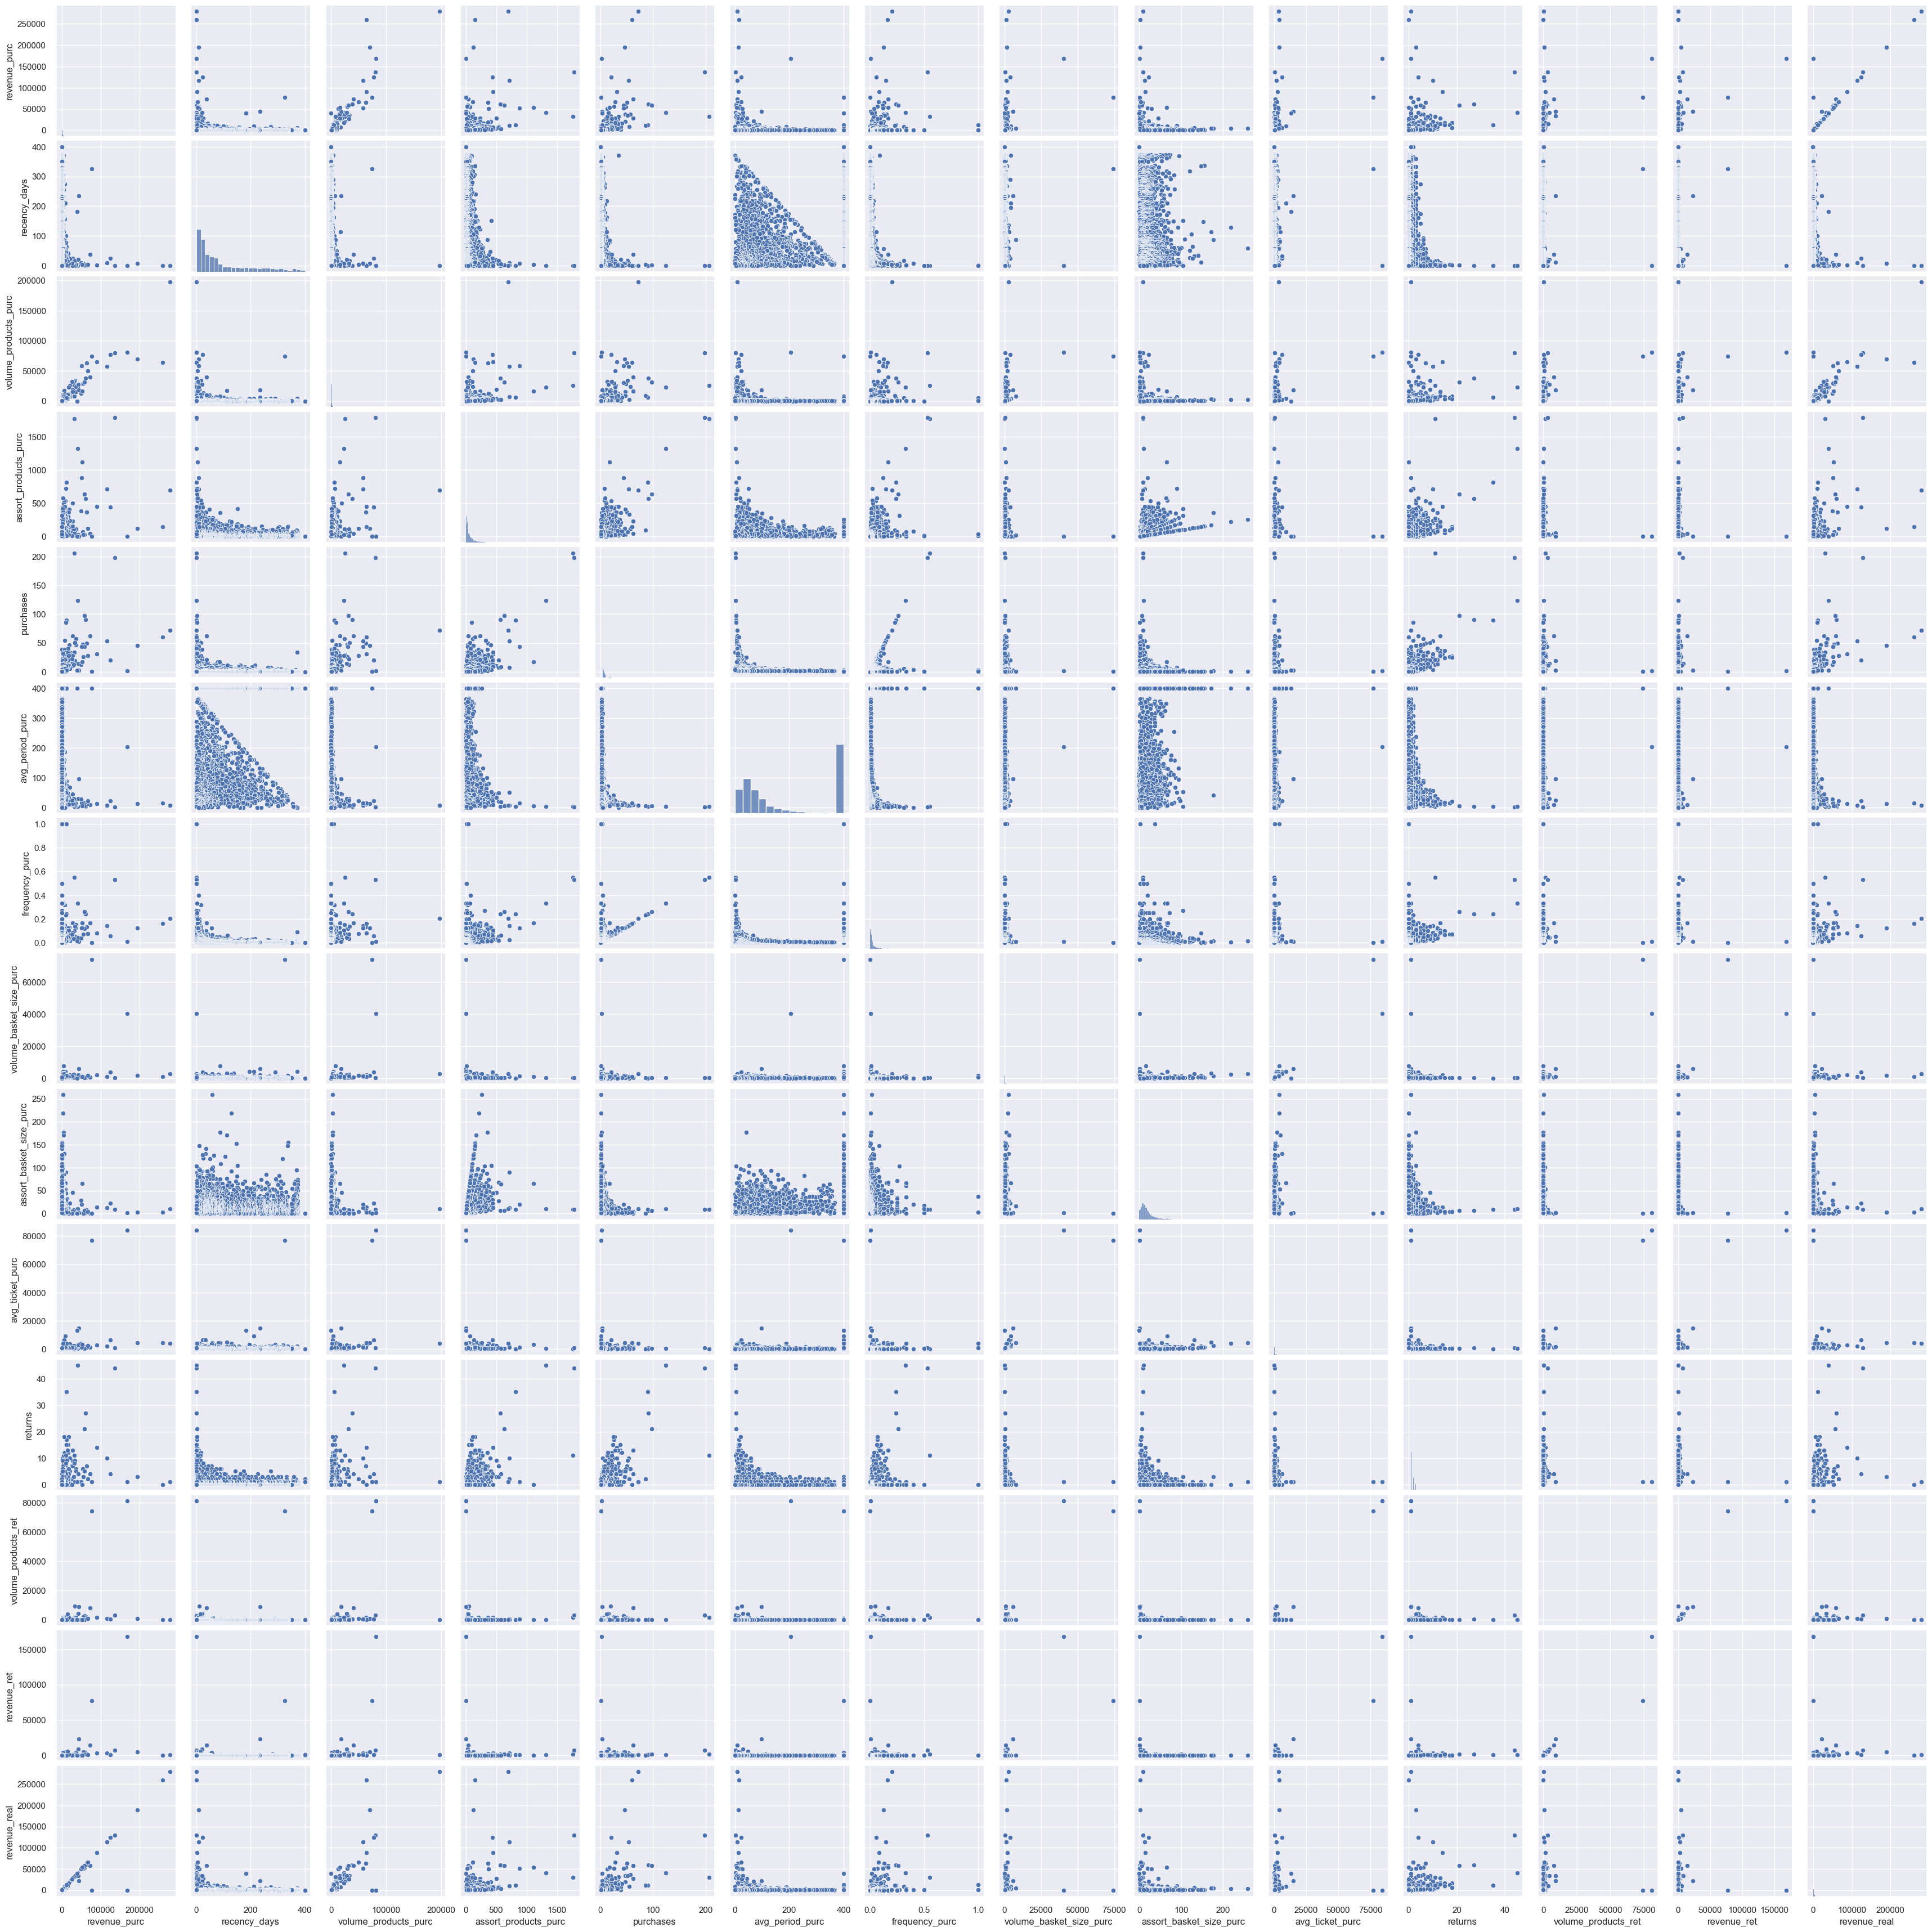

In [72]:
df42 = df4.drop( columns = {'customer_id'} ).copy()

plt.figure( figsize = (25,12) )

sns.pairplot( df42 );

- volume_products_ret têm outliers investigar e baixa variância (irá ajeitar com exclusão de clientes com compras muito altas e logo após devoluções no mesmo dia, suspeita de fraude)
- revenue_ret têm outliers investigar e baixa variância (irá ajeitar com exclusão de clientes com compras muito altas e logo após devoluções no mesmo dia, suspeita de fraude)
- avg_ticket_purc têm outliers investigar e baixa variância (irá ajeitar com exclusão de clientes com compras muito altas e logo após devoluções no mesmo dia, suspeita de fraude)
- volume_basket_size_purc têm outliers investigar e baixa variância (irá ajeitar com exclusão de clientes com compras muito altas e logo após devoluções no mesmo dia, suspeita de fraude)
- volume_products_purc têm outliers investigar (deixar outliers pois não pareceu comportamento anormal de compra)

## 4.3. Embeddings

- Perde (mais difícil) em explicabilidade do porque os clientes foram colocados em cada cluster, se necessitar explicação deve-se trabalhar apenas com a seleção de features.

In [36]:
df43 = df4.drop(columns = 'customer_id').copy()

In [37]:
## Padronizar features numéricas utilizando Min-Max Scaler

mms = pp.MinMaxScaler()

df43['revenue_purc'] = mms.fit_transform( df43[['revenue_purc']] )
df43['recency_days'] = mms.fit_transform( df43[['recency_days']] )
df43['purchases'] = mms.fit_transform( df43[['purchases']] )
df43['avg_ticket_purc'] = mms.fit_transform( df43[['avg_ticket_purc']] )
df43['returns'] = mms.fit_transform( df43[['returns']] )
df43['volume_products_purc'] = mms.fit_transform( df43[['volume_products_purc']] )
df43['assort_products_purc'] = mms.fit_transform( df43[['assort_products_purc']] )
df43['avg_period_purc'] = mms.fit_transform( df43[['avg_period_purc']] )
df43['frequency_purc'] = mms.fit_transform( df43[['frequency_purc']] )
df43['volume_basket_size_purc'] = mms.fit_transform( df43[['volume_basket_size_purc']] )
df43['assort_basket_size_purc'] = mms.fit_transform( df43[['assort_basket_size_purc']] )
df43['volume_products_ret'] = mms.fit_transform( df43[['volume_products_ret']] )
df43['revenue_ret'] = mms.fit_transform( df43[['revenue_ret']] )
df43['revenue_real'] = mms.fit_transform( df43[['revenue_real']] )

X = df43.copy()

### 4.3.1. PCA

<BarContainer object of 14 artists>

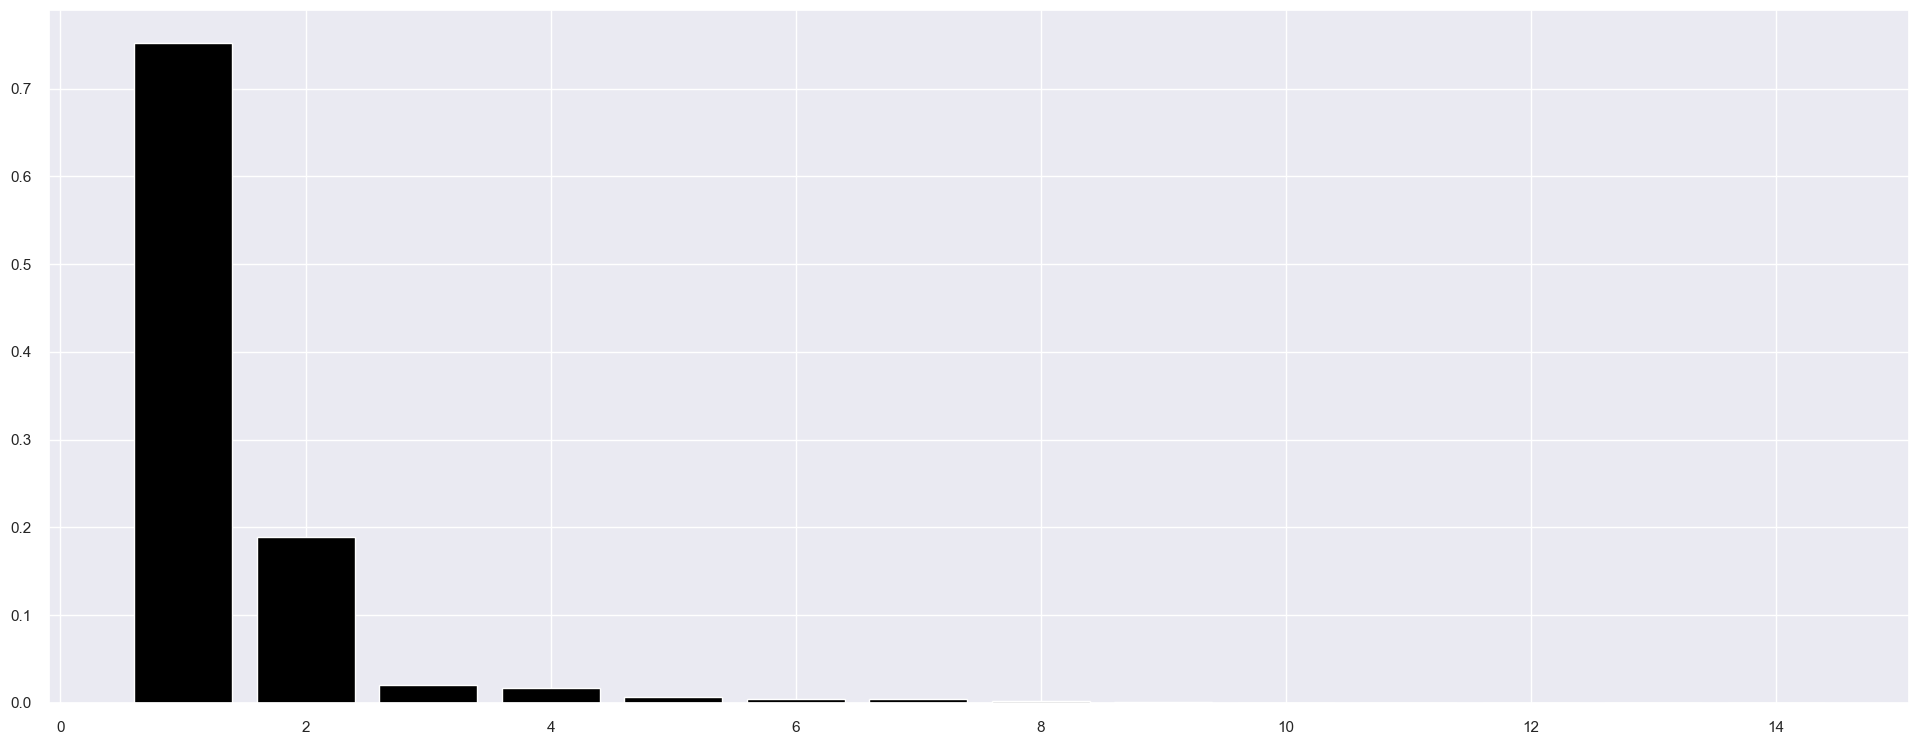

In [38]:
# define model
pca = dp.PCA(n_components = X.shape[1])

# fit model and transform data 
principal_components = pca.fit_transform( X )

# plot explained variable 
features = range( 1 ,pca.n_components_ + 1 )

plt.bar( features, pca.explained_variance_ratio_, color = 'black' )

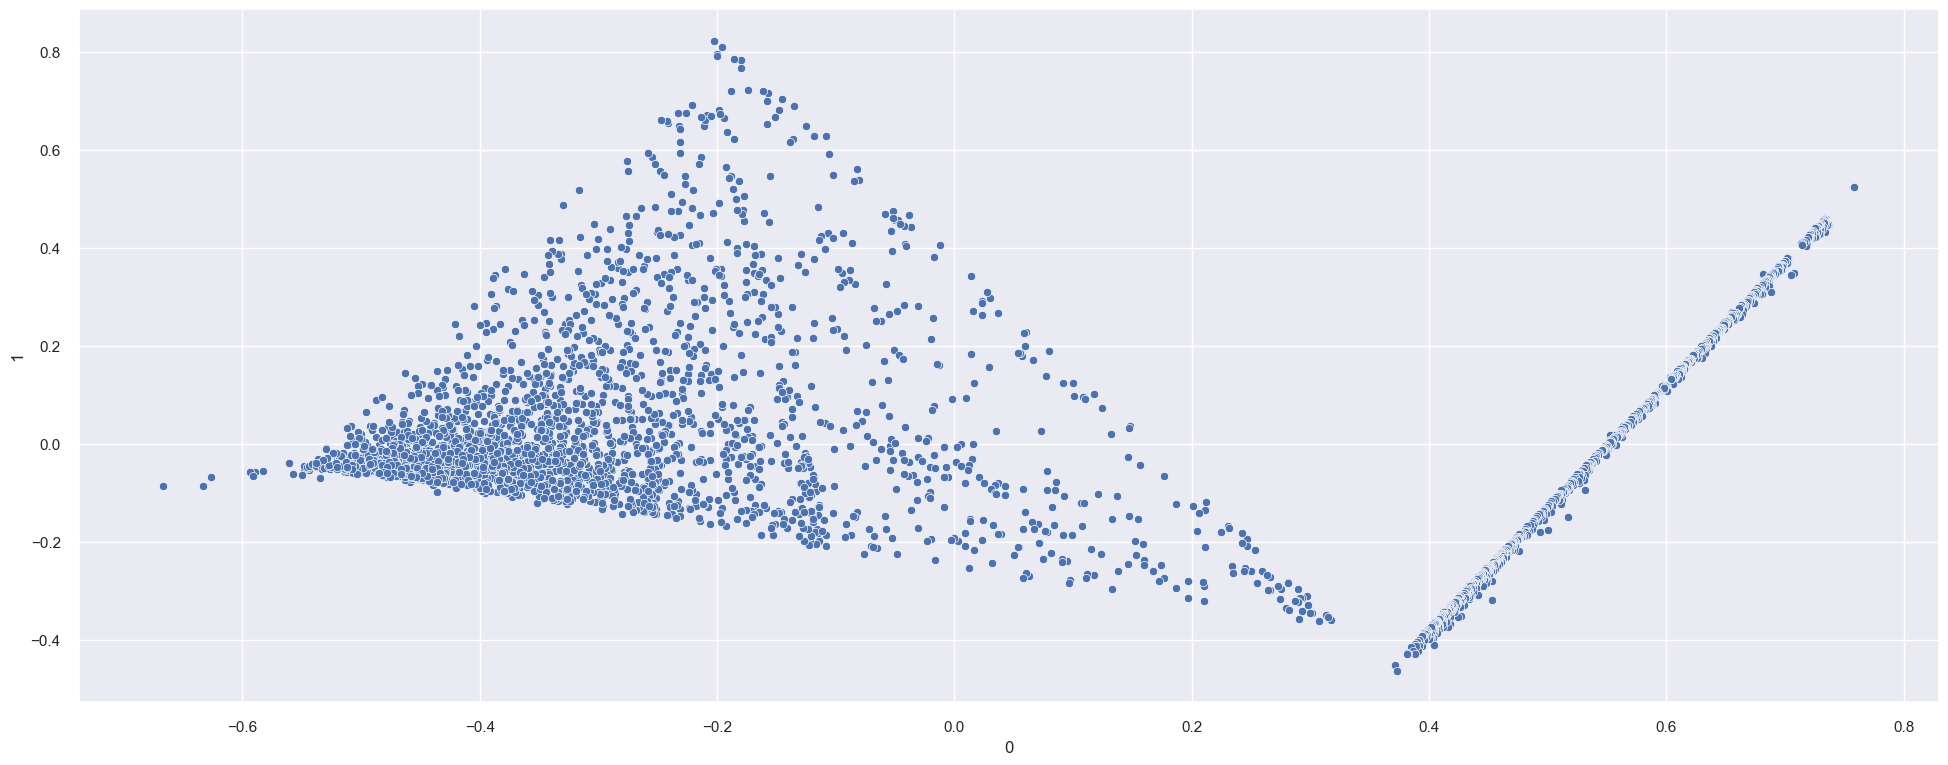

In [39]:
### Plotar a distribuição dos dados com duas componentes principais

df_pca = pd.DataFrame( principal_components )

sns.scatterplot(x = 0, y = 1, data = df_pca);

### 4.3.2. UMAP

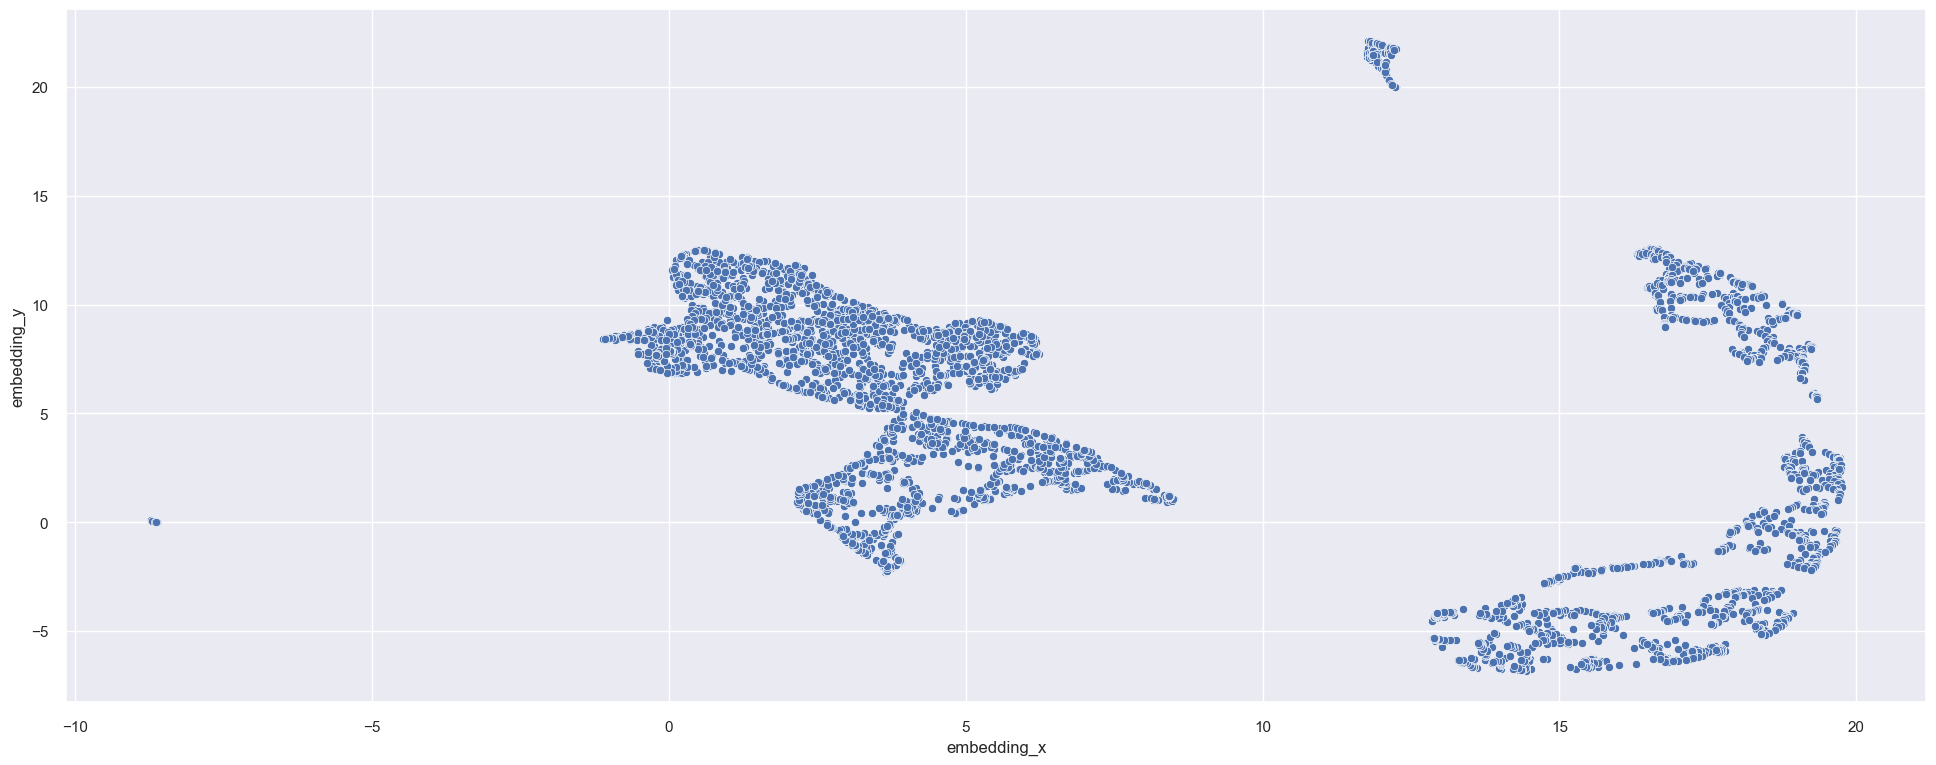

In [40]:
# reducer = projeção de alta dimensionalidade
reducer = umap.UMAP(random_state = 42)

# embedding = espaço projetado em 2D 
embedding = reducer.fit_transform( X )

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot embedding - 

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca );

### 4.3.3. t-SNE

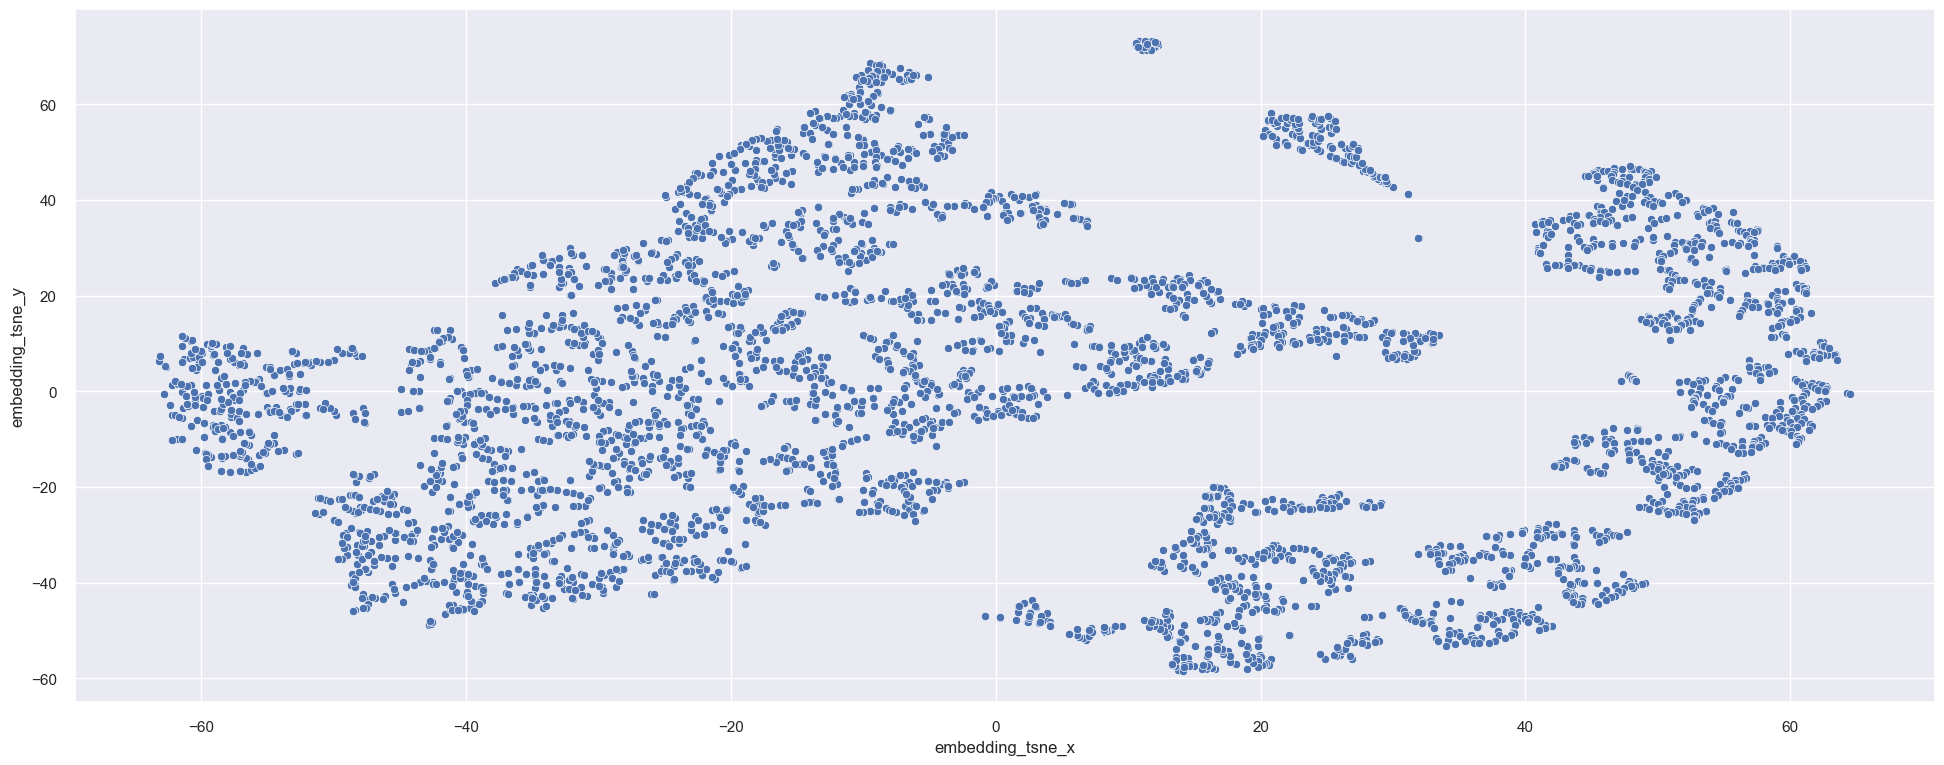

In [41]:
# reducer = projeção de alta dimensionalidade
reducer = mf.TSNE(n_components=2, n_jobs = -1, random_state = 42)

# embedding = espaço projetado em 2D 
embedding = reducer.fit_transform( X )

df_pca['embedding_tsne_x'] = embedding[:,0]
df_pca['embedding_tsne_y'] = embedding[:,1]

# plot embedding - 

sns.scatterplot(x = 'embedding_tsne_x', y = 'embedding_tsne_y', data = df_pca );

### 4.3.4. Tree-Based Embedding 

- Irá se utilizar do modelo de árvores para encontrar uma variável que consegue melhor subdividir as amostras de tal forma que obtenha êxito em predizer a variável resposta. Para isso, deve-se definir uma variável resposta;

In [42]:
# Modelo de árvore não necessita de preparação

# Variáveis preditoras
X = df4.drop(columns = ['customer_id','revenue_real']).copy()
# Variável alvo definida será a receita real = receita compras - receita devoluções
y = df4['revenue_real']

In [43]:
# model definition
rf_model = en.RandomForestRegressor(random_state = 42)

# model fit - ajuste da árvore com os dados de treino passados
rf_model.fit( X, y )

# Leaf - Aplicar os mesmos dados de treino no modelo de árvore formado para verificar a distribuição das amostras nas folhas da árvore
# Linhas representa cada cliente e as colunas a quantidade de árvores construídas pela RF e os valores representam a posição referente a folhas
# que o cliente ficou ao construir as n árvores. 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [44]:
df_leaf.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24  ...    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  5110  5196  5157  5229  5150  5256  5117  5106  5189  5214  5213  5107  5111  5127  5176  5057  5047  5116  5142  5147  5229  5107  5125  5183  5134  ...  5165  5138  5166  5218  5200  5198  5132  5197  5204  5164  5105  5076  5153  5093  5168  5193  5169  5194  5132  5083  5127  5126  5166  5166  5184
1  4783  4856  4847  4917  4822  4911  4853  4813  4884  4893  4900  4812  4814  4816  4892  4751  4756  4808  4809  4853  4936  4777  4805  4883  4828  ...  4858  4817  4872  4898  4858  4909  4814  4921  4864  4854  4816  4760  4833  4784  4868  4867  4880  4892  4788  4769  4826  4834  4850  4878  4837
2  5194  5286  5246  5326  5218  5363  5210  5218  5271  5310  5321  5195  5184  5197  5270  5153  5147  5199  5226  5256  5320  5184  5225  5279  5227  ...  5248  5219  5257  5302  5277  5286  5218  5289  5275  5242  5210  5172  5249  5196  5253  5295  5272  5291  5232  5165  5210  5220  5258  5275  5256
3  3210  3320  3266  3358  3327  3308  3284  3310  3373  3230  3369  3292  3300  3331  3356  3218  3272  3230  3342  3257  3377  3275  3295  3362  3330  ...  3282  3269  3310  3345  3279  3378  3334  3363  3348  3284  3290  3161  3297  3211  3355  3279  3359  3302  3325  3206  3252  3307  3298  3346  3297
4  3156  3246  3201  3333  3358  3334  3176  3225  3356  3127  3336  3335  3198  3266  3288  3201  3178  3015  3217  3175  3291  3250  3278  3330  3081  ...  3530  3333  3209  3371  3258  3301  3471  3336  3319  3004  3209  3087  3188  3263  3325  3159  3230  3221  3238  3139  3235  3177  3132  3271  3226

[5 rows x 100 columns]

In [83]:
## Espaço de embedding definido por um modelo de árvore de regressão tendo a revenue_real como variável resposta 

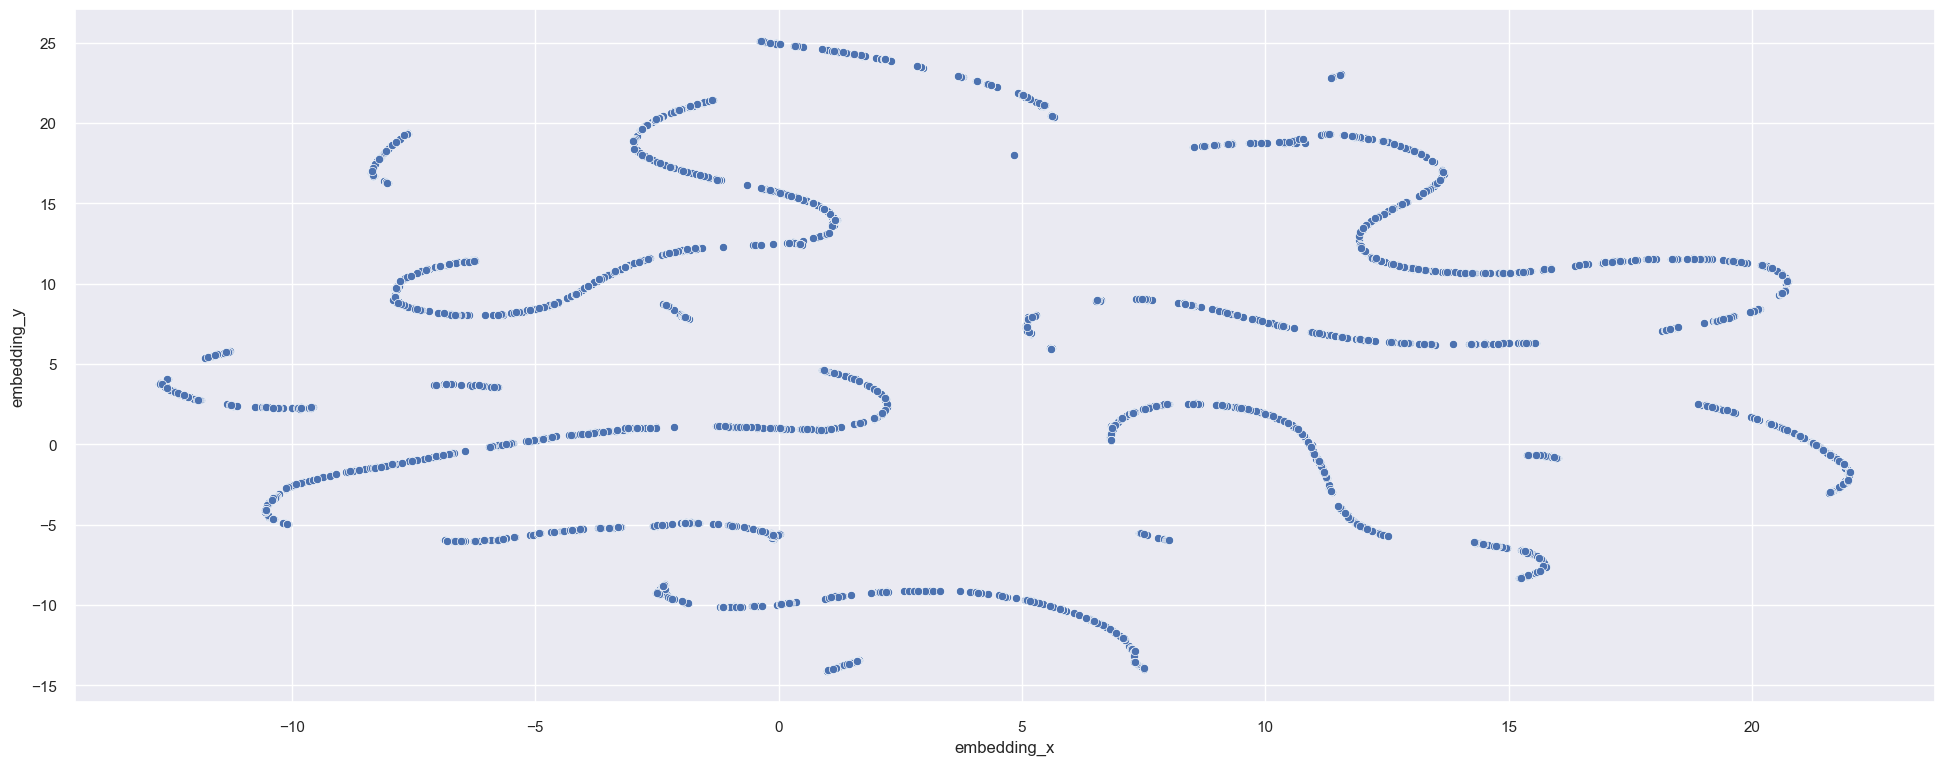

In [45]:
## UMAP para reduzir para duas dimensões a organização espacial dos clientes feita pela árvore

# reducer = projeção de alta dimensionalidade
reducer = umap.UMAP(random_state = 42)

# embedding = espaço projetado em 2D 
embedding = reducer.fit_transform( df_leaf )

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot embedding - 

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca );

## 4.4. Conclusions

A partir da Análise Univariada realizada observou-se que existem muitos clientes que compram pouco (frequência e preço) e poucos clientes que compram muito (frequência e preço), isso ocorre devido ao modelo de negócio que dá origem aos dados, ou seja, um e-commerce que possui uma variedade grande de produtos e de diversos preços, com isso, atrai públicos diversos, alguns fiéis e outros nem tanto.

Com isso, é natural que exista um cluster maior (mais amostras de difícil subdivisão pelo preço e frequência de compra ser muito próximo) e clusters menores que se destacam.

#   5.0 Data Preparation 

In [46]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df5 = df4.copy()

In [86]:
df5.head()

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
0        17850      5391.210       372.000              1733.000                21.000     34.000            1.000           0.091                   50.971                    0.618          158.565    1.000               40.000      102.580      5288.630
1        13047      3232.590        56.000              1390.000               105.000      9.000           52.833           0.024                  154.444                   11.667          359.177    7.000               35.000      143.490      3089.100
2        12583      6705.380         2.000              5028.000               114.000     15.000           26.500           0.040                  335.200                    7.600          447.025    2.000               50.000       76.040      6629.340
3        13748       948.250        95.000               439.000                24.000      5.000           92.667           0.013                   87.800                    4.800          189.650    0.000                0.000        0.000       948.250
4        15100       876.000       333.000                80.000                 1.000      3.000           20.000           0.008                   26.667                    0.333          292.000    3.000               22.000      240.900       635.100

In [47]:
   

mms = pp.MinMaxScaler()

df5['revenue_purc'] = mms.fit_transform( df5[['revenue_purc']] )
df5['recency_days'] = mms.fit_transform( df5[['recency_days']] )
df5['purchases'] = mms.fit_transform( df5[['purchases']] )
df5['avg_ticket_purc'] = mms.fit_transform( df5[['avg_ticket_purc']] )
df5['returns'] = mms.fit_transform( df5[['returns']] )
df5['volume_products_purc'] = mms.fit_transform( df5[['volume_products_purc']] )
df5['assort_products_purc'] = mms.fit_transform( df5[['assort_products_purc']] )
df5['avg_period_purc'] = mms.fit_transform( df5[['avg_period_purc']] )
df5['frequency_purc'] = mms.fit_transform( df5[['frequency_purc']] )
df5['volume_basket_size_purc'] = mms.fit_transform( df5[['volume_basket_size_purc']] )
df5['assort_basket_size_purc'] = mms.fit_transform( df5[['assort_basket_size_purc']] )
df5['volume_products_ret'] = mms.fit_transform( df5[['volume_products_ret']] )
df5['revenue_ret'] = mms.fit_transform( df5[['revenue_ret']] )
df5['revenue_real'] = mms.fit_transform( df5[['revenue_real']] )


df5.head()

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real
0        17850         0.019         0.930                 0.009                 0.012      0.165            0.000           0.091                    0.001                    0.002            0.002    0.022                0.000        0.001         0.023
1        13047         0.012         0.140                 0.007                 0.059      0.044            0.130           0.024                    0.002                    0.045            0.004    0.156                0.000        0.001         0.015
2        12583         0.024         0.005                 0.026                 0.064      0.073            0.064           0.040                    0.005                    0.029            0.005    0.044                0.001        0.000         0.028
3        13748         0.003         0.238                 0.002                 0.013      0.024            0.230           0.013                    0.001                    0.019            0.002    0.000                0.000        0.000         0.008
4        15100         0.003         0.833                 0.000                 0.001      0.015            0.048           0.008                    0.000                    0.001            0.003    0.067                0.000        0.001         0.007

# <font color = 'red'>  6.0 Feature Selection </font>

In [48]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning 

Variar os valores de clusters e avaliar qualidade do agrupamento

In [49]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df7 = df6.copy()

X = df7.drop(columns = 'customer_id')

In [50]:
clusters = list(np.arange(2,10,1))

## 7.1. K-means

In [93]:
# Within-Cluster Sum of Square (WSS)

wss = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    wss.append(kmeans.inertia_)
    
    print(f"{k} cluster: {kmeans.inertia_}")

2 cluster: 345.3549009304292
3 cluster: 222.2789596293241
4 cluster: 162.17010351657427
5 cluster: 134.85083821905874
6 cluster: 119.61564159338135
7 cluster: 108.32348861242505
8 cluster: 98.5853312000908
9 cluster: 91.236218672652


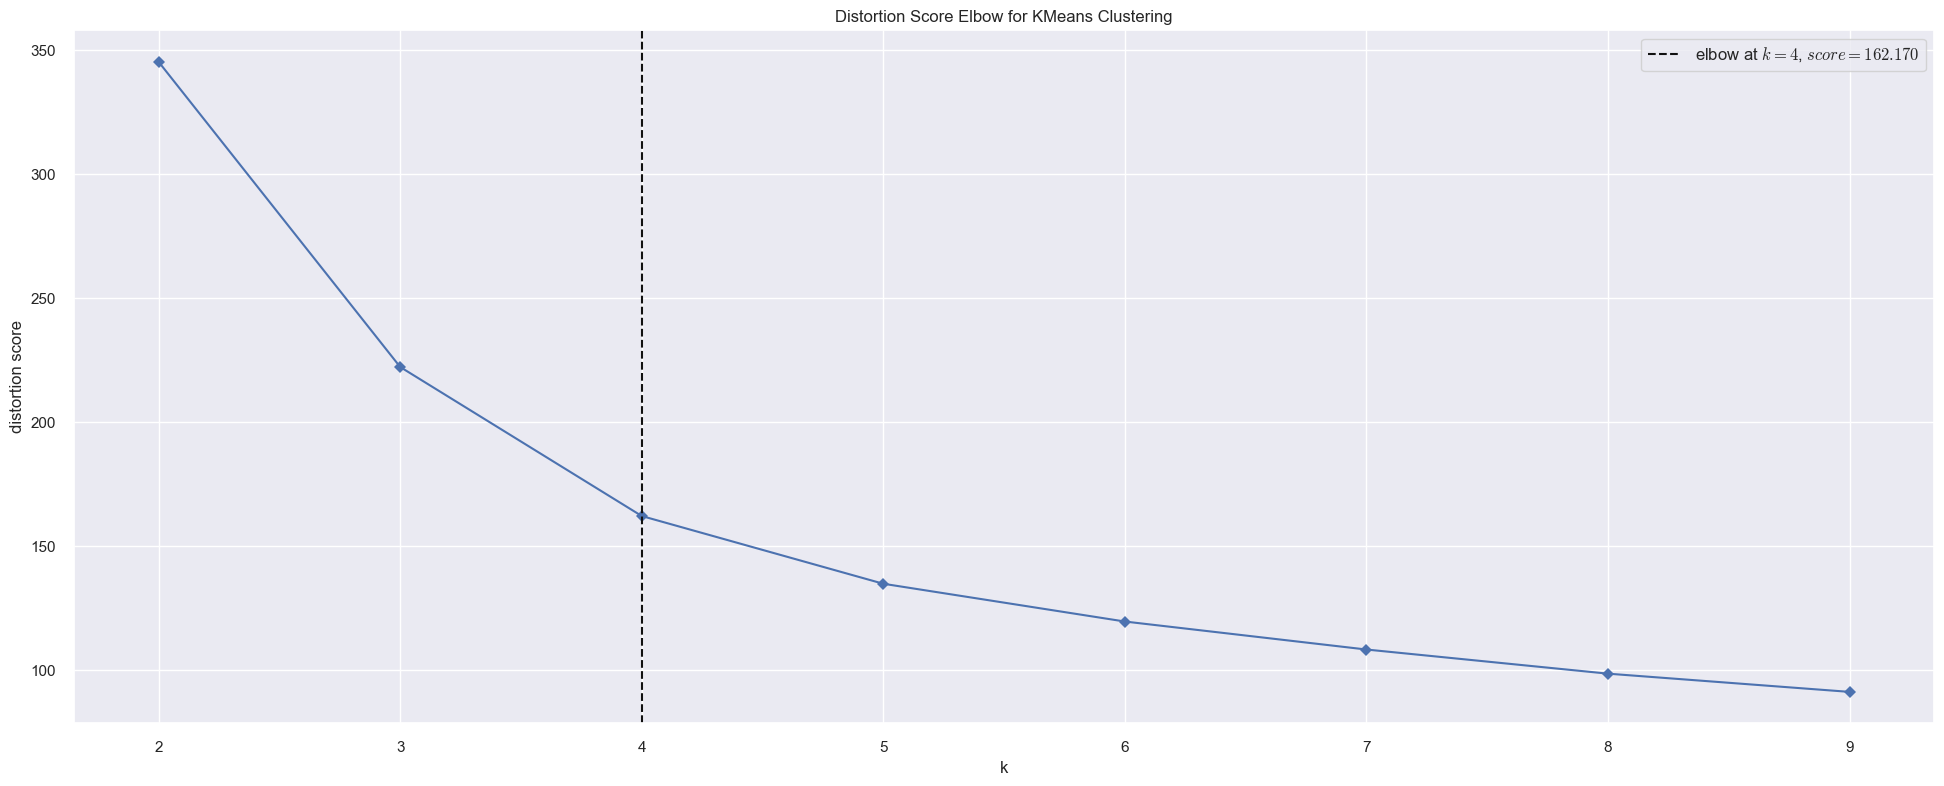

In [94]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, timings = False );
k_means.fit( X );
k_means.show();

- Pela métrica WSS deveria escolher k = 4 , pois é a quantidade de cluster que faz com que a soma das distâncias dos centroídes de cada cluster com cada ponto ao quadrado resulte em um valor com considerável redução com relação a soma das distâncias dos cluster adjacentes. 

- Obviamente assumindo cluster maiores que 4 , o somatório das distâncias será menor pois irá obrigar o algoritmo a criar um novo centroíde, porém a redução de distâncias de cada ponto para o centroíde não é significativa ao ponto de justificar aumentar o número de clusters.

- Se a curva (elbow method) fosse mais suave, significa que a distribuição dos dados no espaço de features está bastante sobreposta (não há clusters naturais formados), não sendo possível a realização de agrupamentos consistentes. -> nesse caso, deve-se ajustar novo espaço de features.

In [51]:
## Silhouette Score (SS)

ss_kmeans = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    ss_avg = mt.silhouette_score(X, kmeans.labels_)
    ss_kmeans.append( ss_avg )
    
    print(f"{k} cluster: {ss_avg}")

2 cluster: 0.633958641095446
3 cluster: 0.6202043153729428
4 cluster: 0.5232213074424991
5 cluster: 0.48259258189758203
6 cluster: 0.4405845204828252
7 cluster: 0.44993467338879845
8 cluster: 0.3645290764931452
9 cluster: 0.35685924340752695


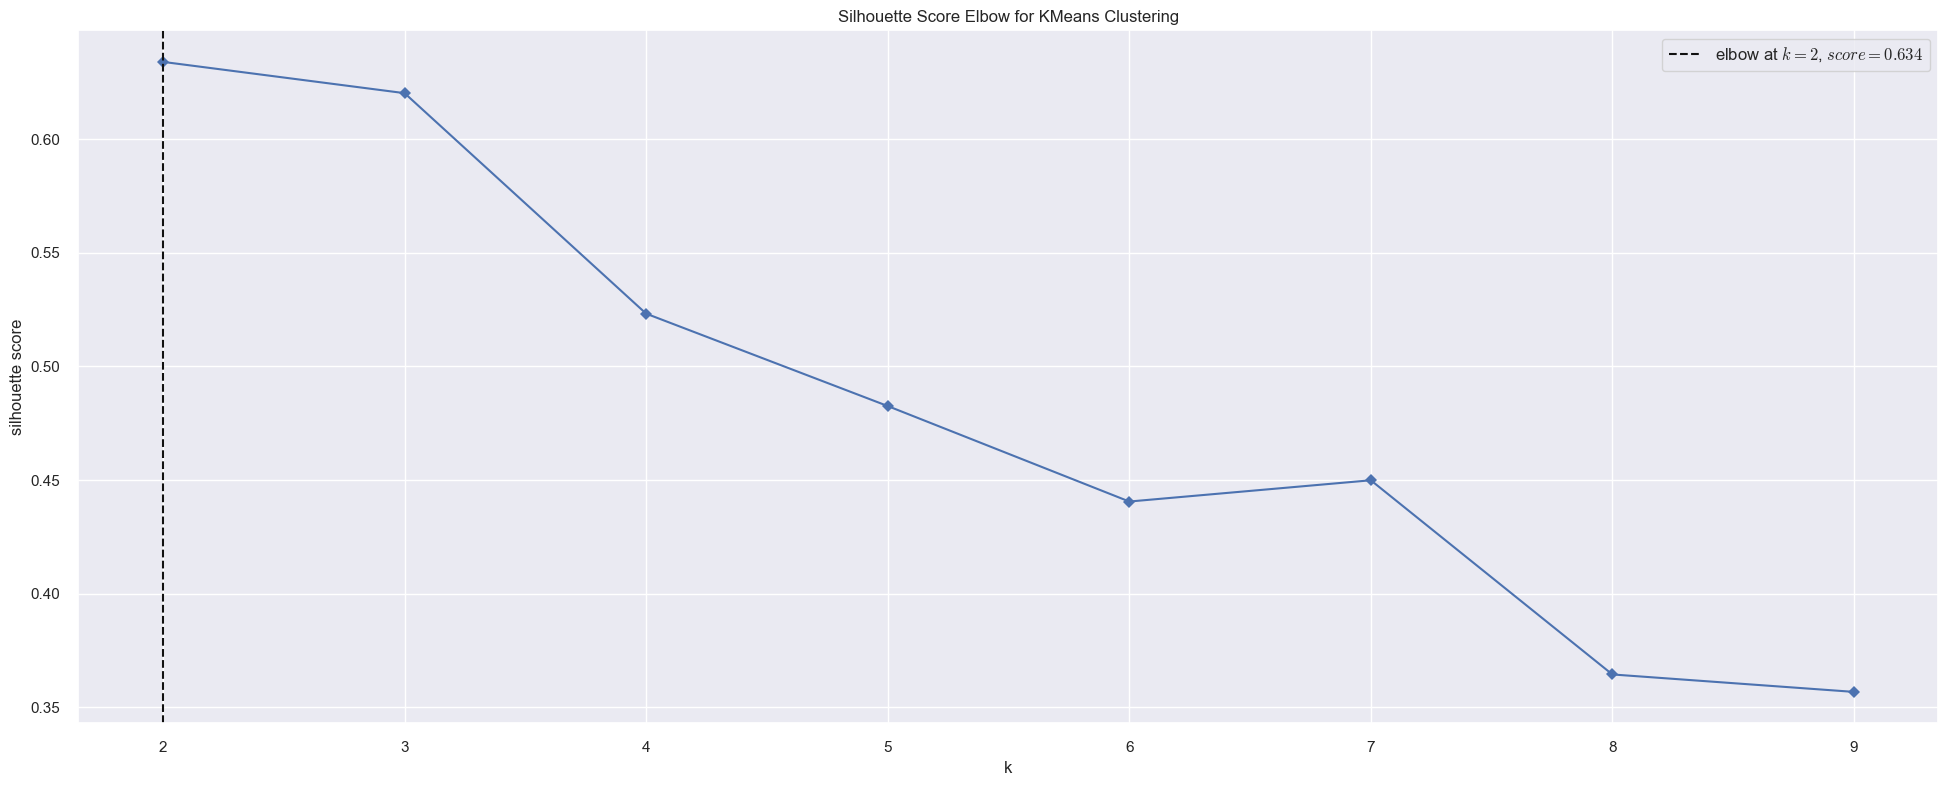

In [96]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, metric = 'silhouette', timings = False );
k_means.fit( X );
k_means.show();

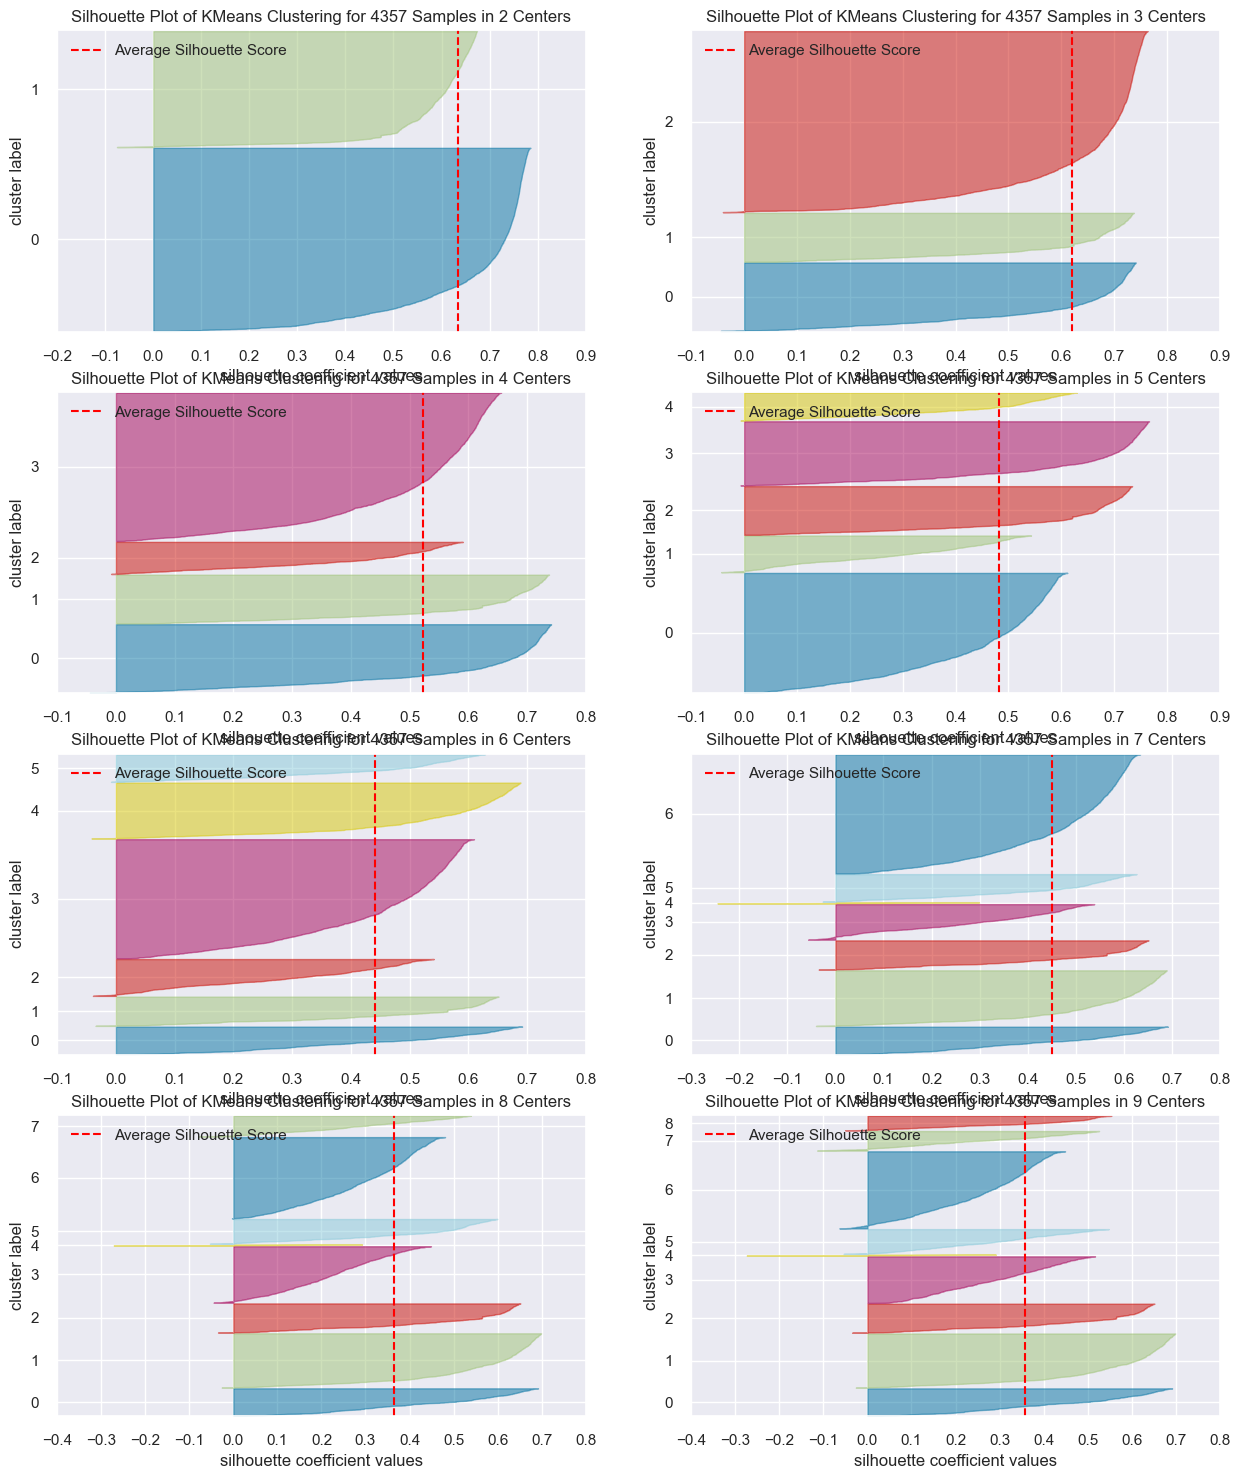

In [97]:
# Silhouette Analysis

fig, ax = plt.subplots(4,2, figsize = (15,18))

for k in clusters:
    
    km = ct.KMeans( n_clusters=k, 
                        init='random', 
                        n_init=10, 
                        random_state=42 )
        
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1, mod])
    visualizer.fit( X )
    visualizer.finalize()

Existe um cluster que possui a maioria das amostras ainda, mas a separação está ocorrendo melhor para mais clusters.

## 7.2. GMM

For n_clusters = 2 The average silhouette_score is : 0.6091086594017256
For n_clusters = 3 The average silhouette_score is : 0.25884611148802894
For n_clusters = 4 The average silhouette_score is : 0.34263282498588543
For n_clusters = 5 The average silhouette_score is : 0.34276841615765247
For n_clusters = 6 The average silhouette_score is : 0.26576943470014347
For n_clusters = 7 The average silhouette_score is : 0.1164046492390462
For n_clusters = 8 The average silhouette_score is : 0.19082471116576136
For n_clusters = 9 The average silhouette_score is : 0.14052856268315167


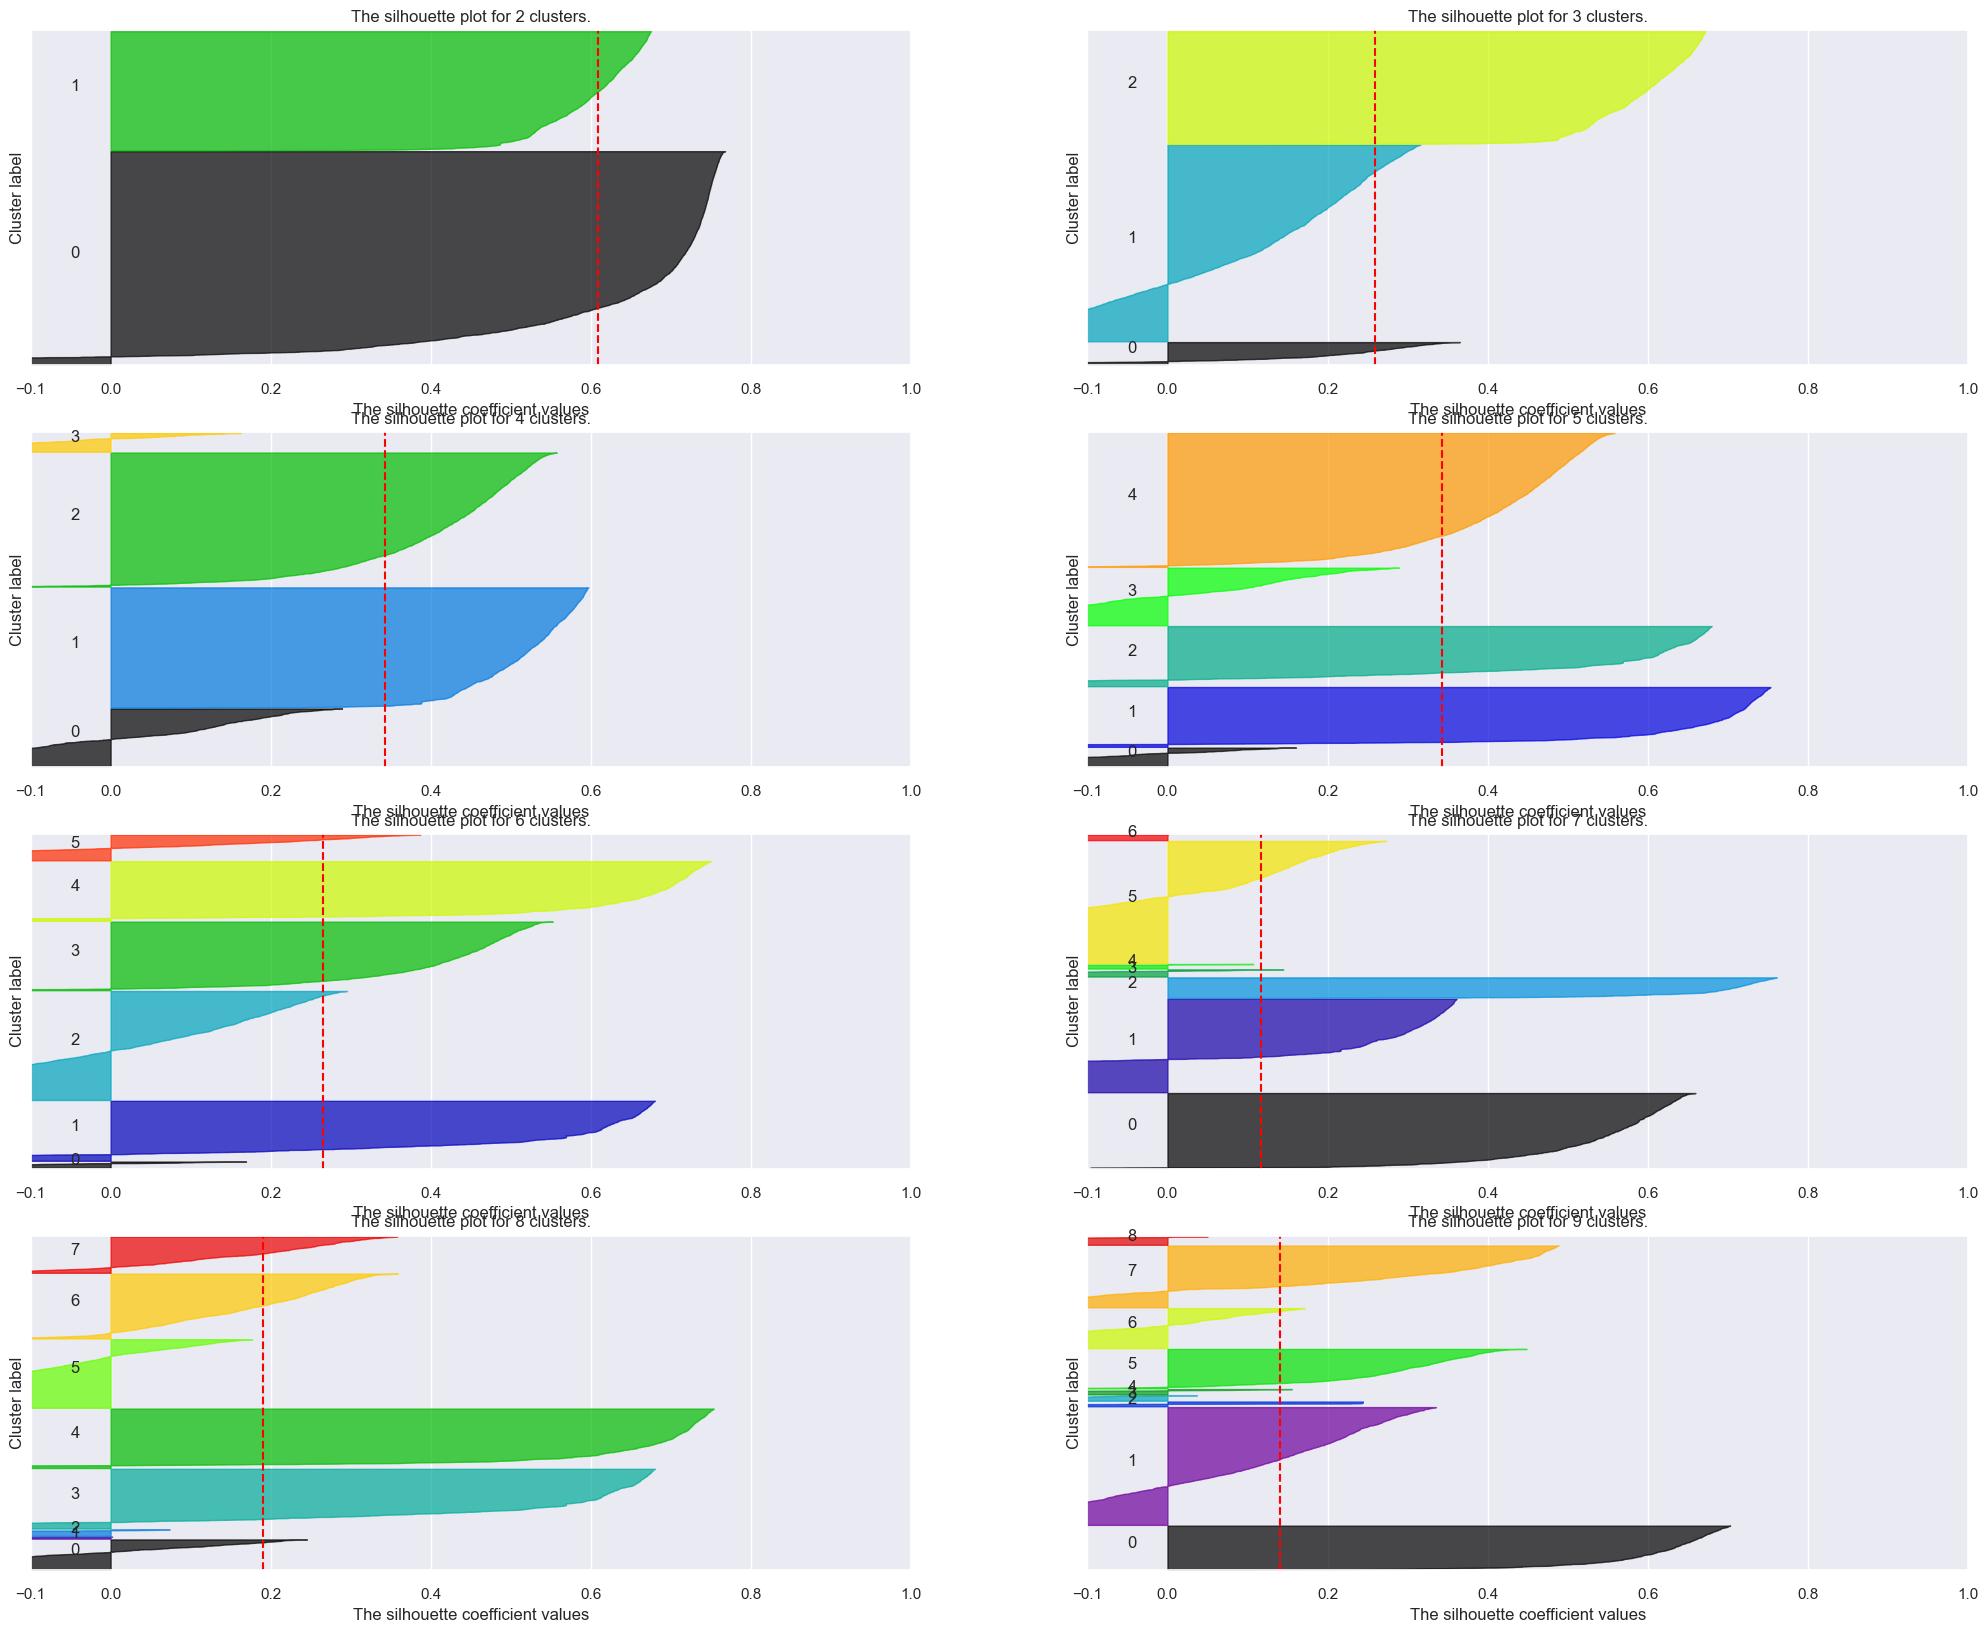

In [153]:
## Silhouette Score (SS) and Analysis

# Create a subplot with 4 row and 2 columns
fig, ax1 = plt.subplots(4, 2)
fig.set_size_inches(25, 20)


ss_gmm = [] 

for n_clusters in clusters:
    
    q, mod = divmod(n_clusters, 2)
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1[q-1, mod].set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1[q-1, mod].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # model definition
    gmm_model = mx.GaussianMixture(n_components = n_clusters)
    # model fit and predict
    labels = gmm_model.fit_predict(X)

    # performance
    silhouette_avg = mt.silhouette_score(X, labels, metric = 'euclidean')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    ss_gmm.append( silhouette_avg )
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = mt.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,
                                    facecolor=color,
                                    edgecolor=color,
                                    alpha=0.7,
                                    )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[q-1, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[q-1, mod].set_title(f"The silhouette plot for {n_clusters} clusters.")
    ax1[q-1, mod].set_xlabel("The silhouette coefficient values")
    ax1[q-1, mod].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[q-1, mod].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[q-1, mod].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Text(0.5, 1.0, 'Silhouette Score for GMM per clusters')

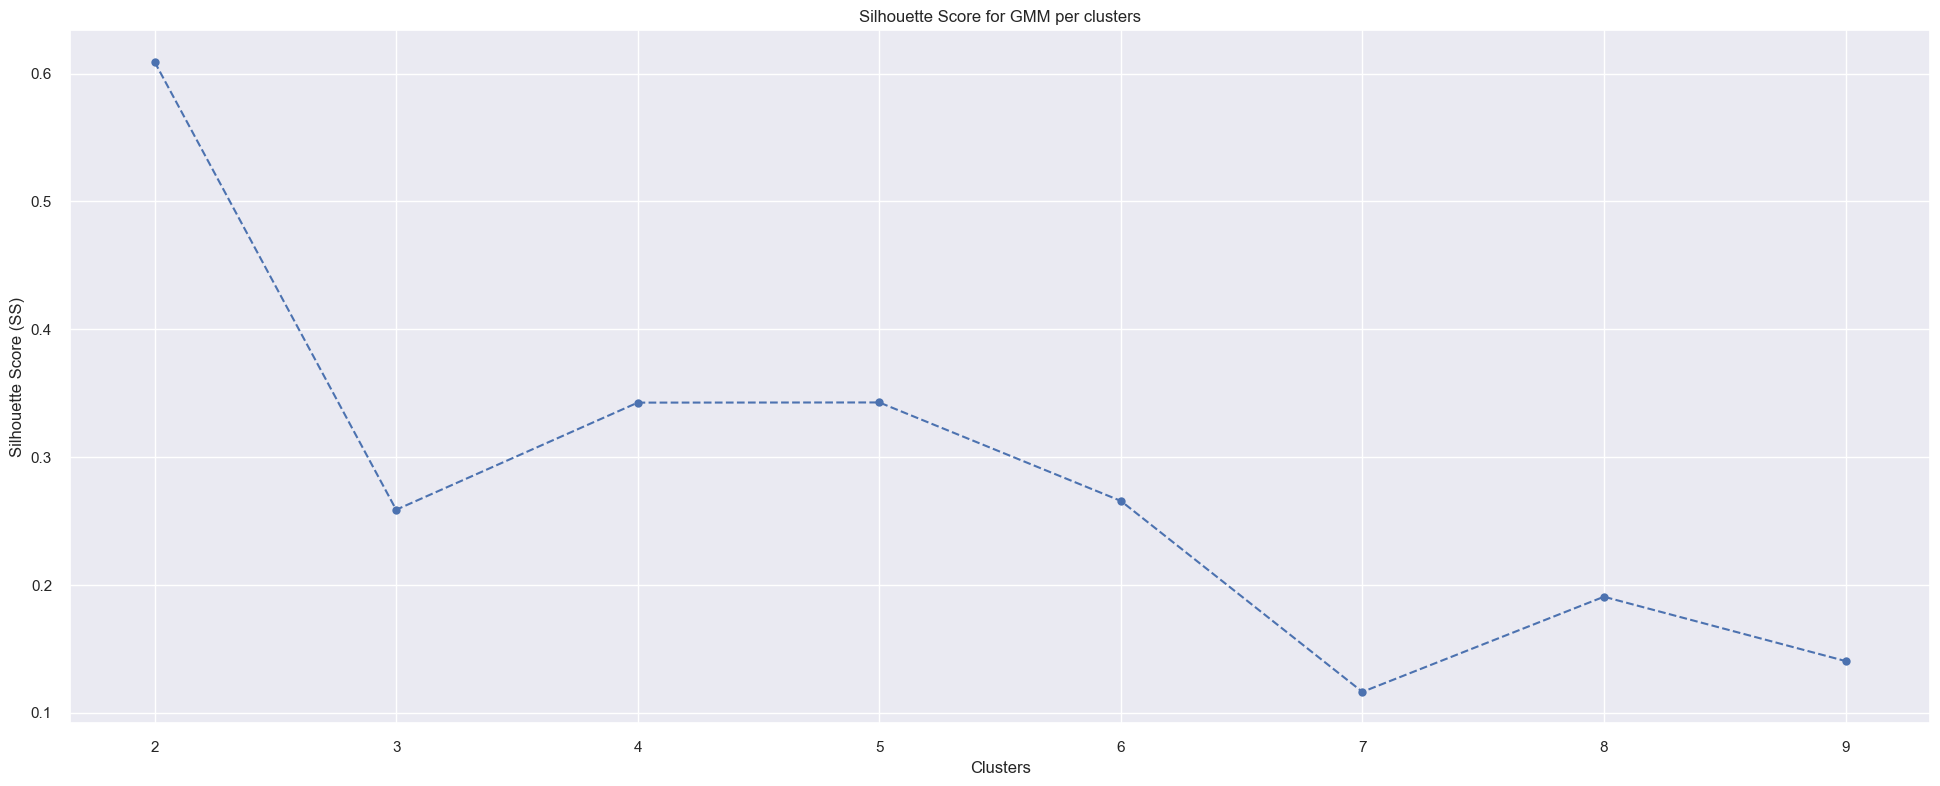

In [154]:
plt.plot(clusters, ss_gmm, linestyle = '--', marker = 'o', color = 'b');

plt.ylabel("Silhouette Score (SS)")
plt.xlabel("Clusters")
plt.title("Silhouette Score for GMM per clusters")

## 7.3. Hierarchical Clustering

In [53]:
# model definition and training 
hc_model = hc.linkage(X, 'ward')

[]

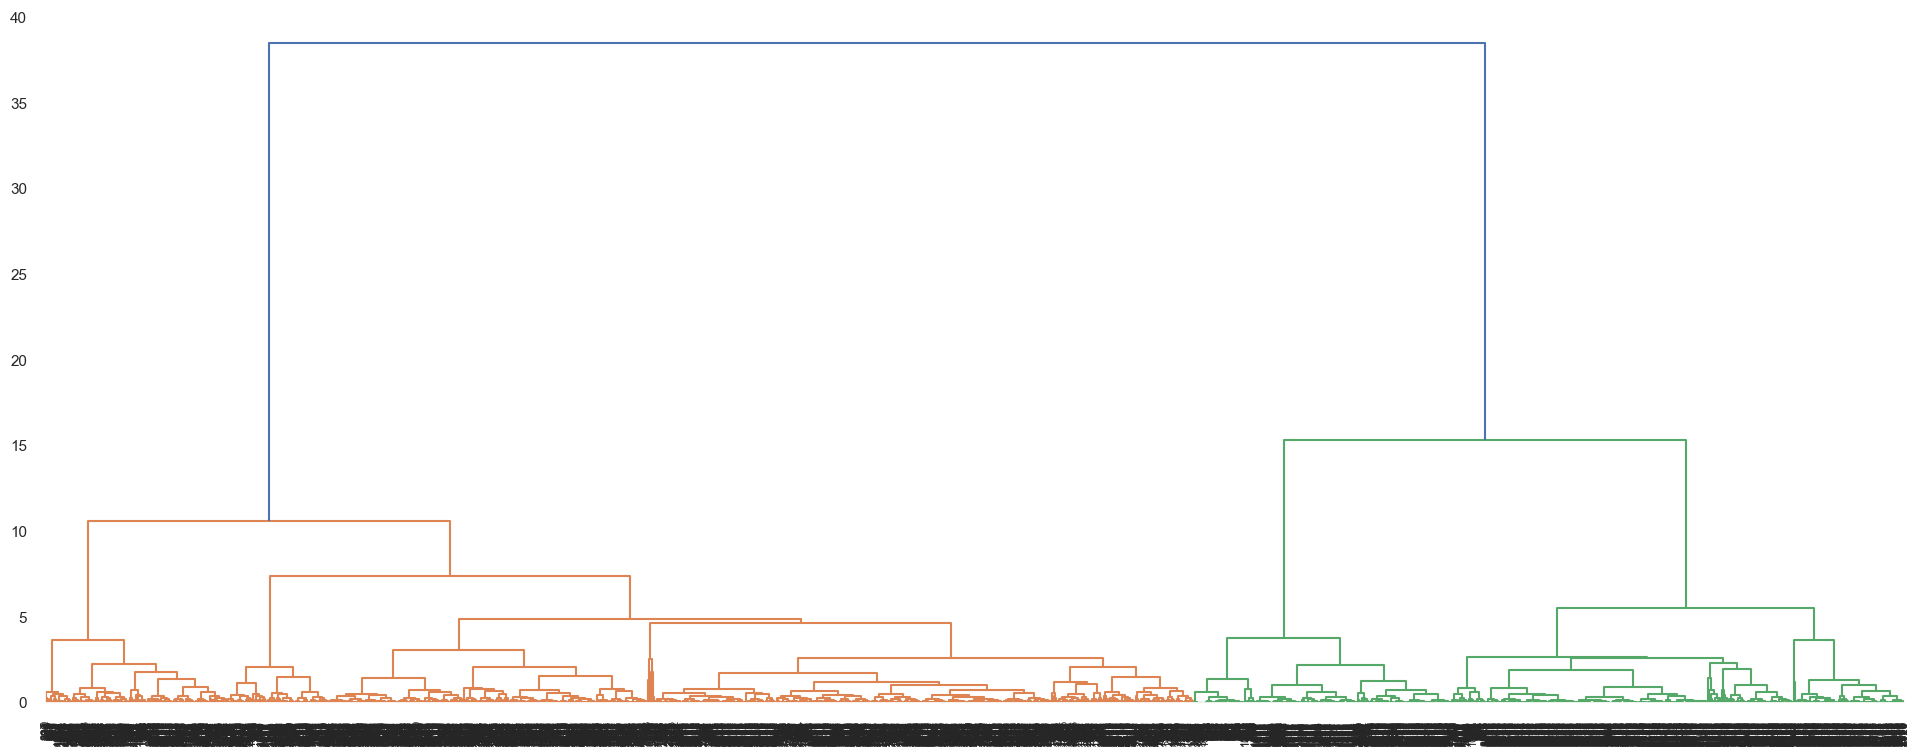

In [54]:
# Dendrograma Completo

hc.dendrogram(
    hc_model,
    leaf_rotation = 90,
    leaf_font_size = 8
)

plt.plot()

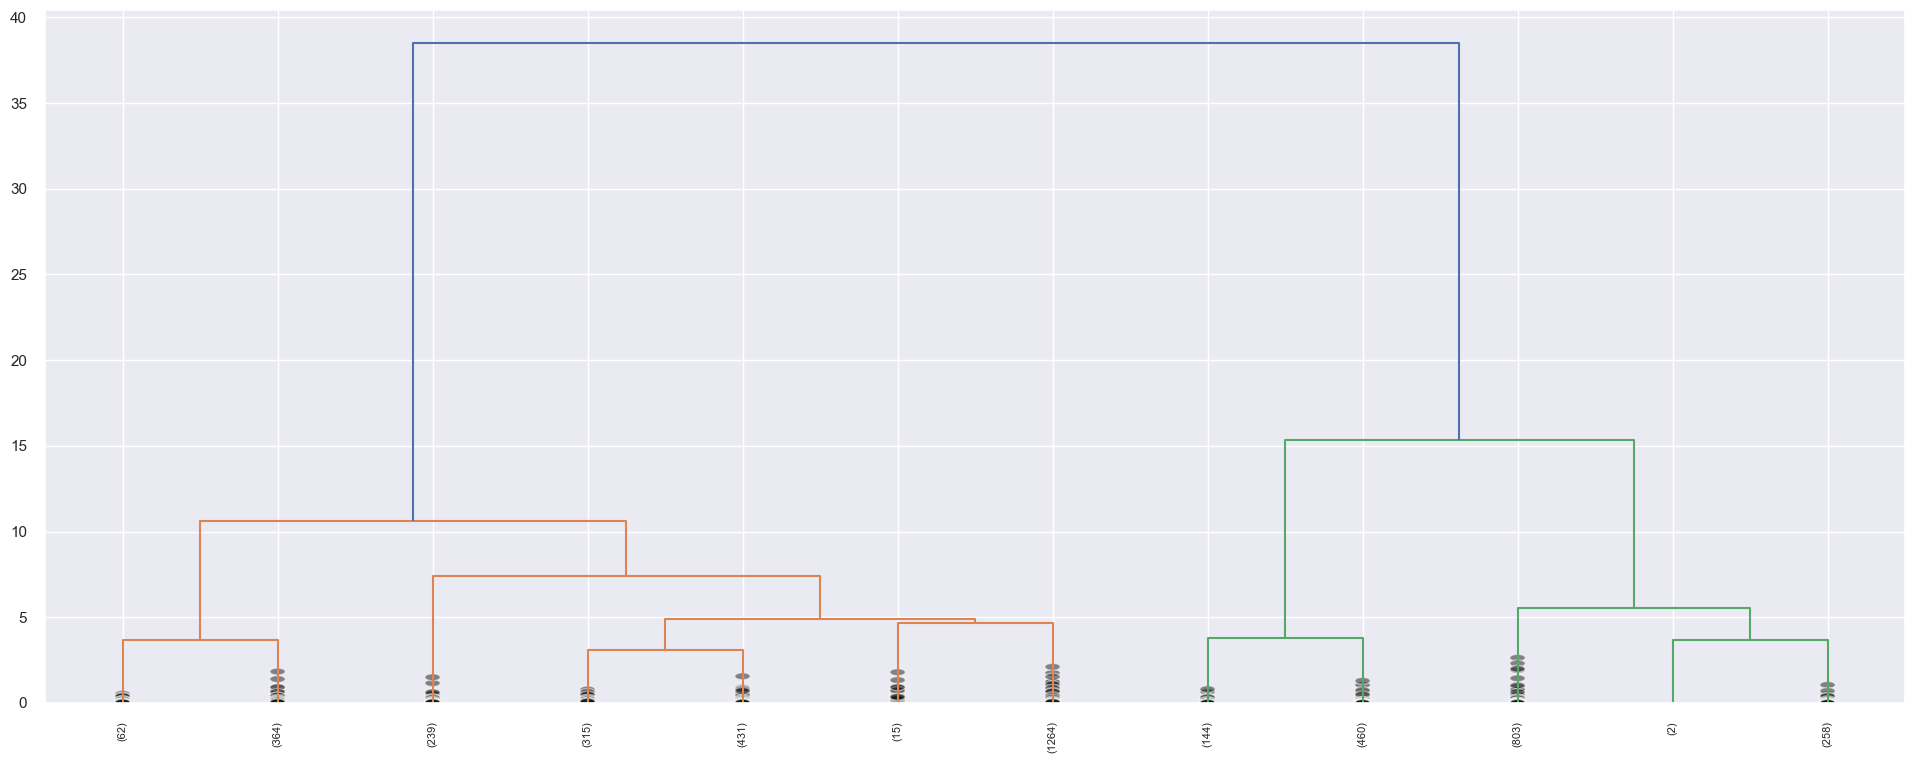

In [55]:
# Dendrograma Acumulado

hc.dendrogram(
    hc_model,
    truncate_mode = 'lastp',
    p = 12,
    leaf_rotation = 90,
    leaf_font_size = 8,
    show_contracted = True
)

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6340034055335189
For n_clusters = 3 The average silhouette_score is : 0.6162972262364107
For n_clusters = 4 The average silhouette_score is : 0.5006972674645839
For n_clusters = 5 The average silhouette_score is : 0.48108217786678026
For n_clusters = 6 The average silhouette_score is : 0.43896612174410793
For n_clusters = 7 The average silhouette_score is : 0.3216167786382275
For n_clusters = 8 The average silhouette_score is : 0.3303018825814475
For n_clusters = 9 The average silhouette_score is : 0.32387501658111995


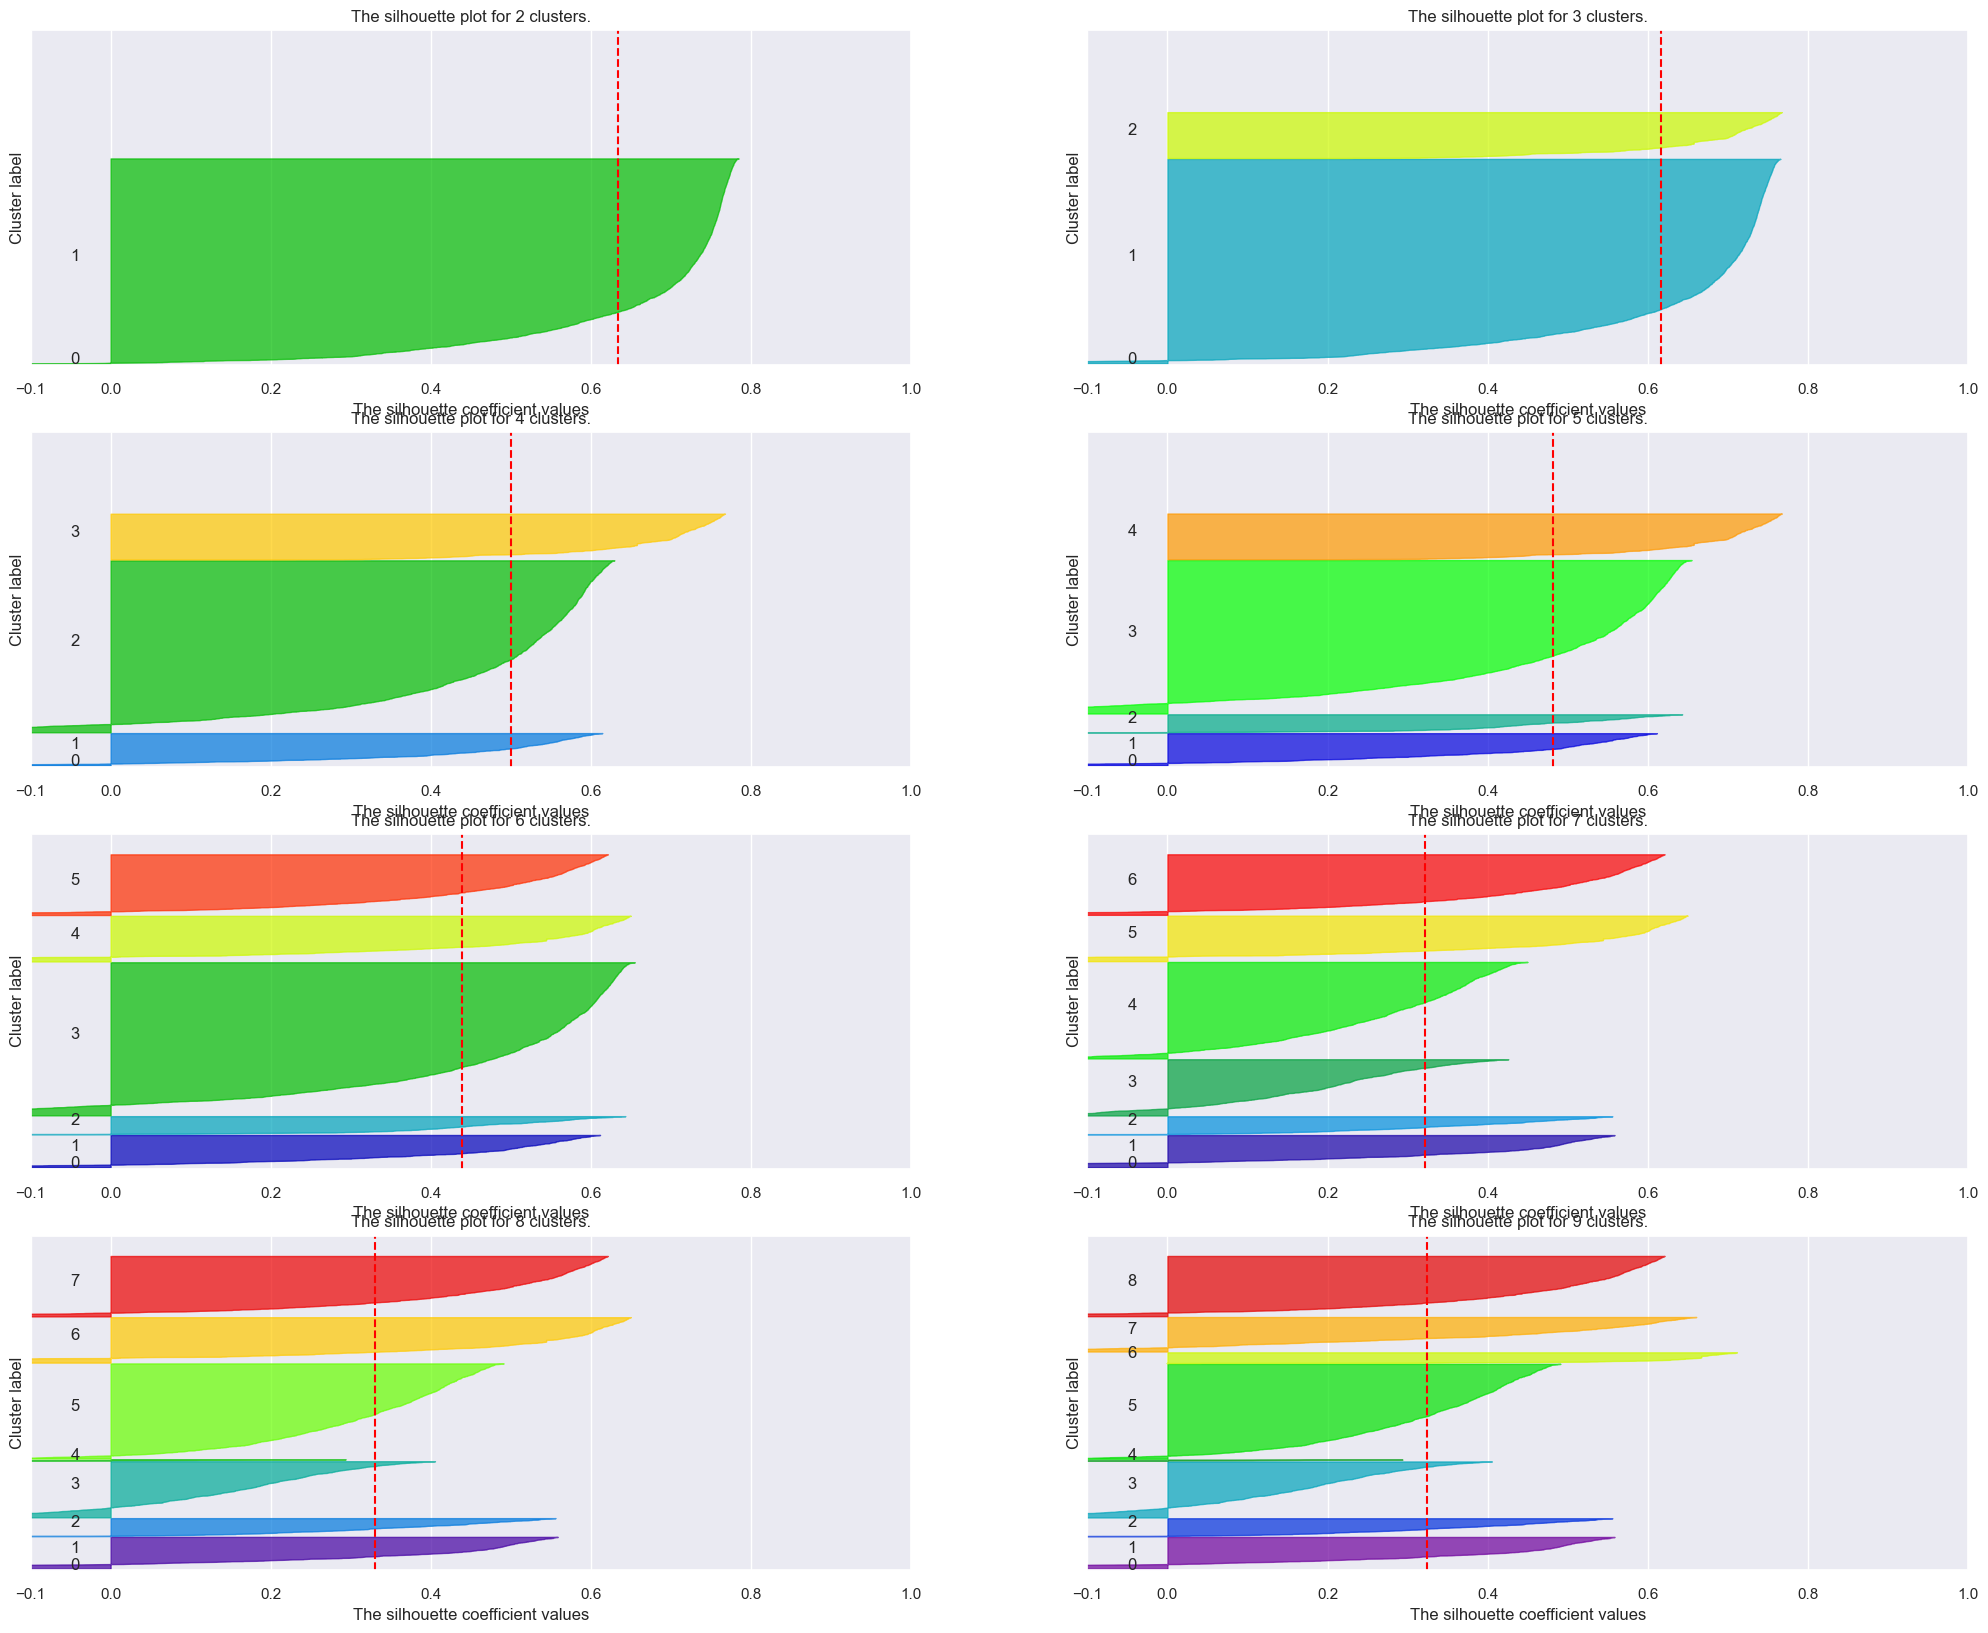

In [155]:
## Silhouette Score (SS) and Analysis

# Create a subplot with 4 row and 2 columns
fig, ax1 = plt.subplots(4, 2)
fig.set_size_inches(25, 20)


ss_hc = [] 

for n_clusters in clusters:
    
    q, mod = divmod(n_clusters, 2)
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1[q-1, mod].set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1[q-1, mod].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    ## model definition and training 
    hc_model = hc.linkage( X, 'ward' )
    
    ## model predict
    labels = hc.fcluster( hc_model , n_clusters , criterion = 'maxclust' )

    # performance
    silhouette_avg = mt.silhouette_score(X, labels, metric = 'euclidean')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    ss_hc.append( silhouette_avg )
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = mt.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,
                                    facecolor=color,
                                    edgecolor=color,
                                    alpha=0.7,
                                    )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[q-1, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[q-1, mod].set_title(f"The silhouette plot for {n_clusters} clusters.")
    ax1[q-1, mod].set_xlabel("The silhouette coefficient values")
    ax1[q-1, mod].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[q-1, mod].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[q-1, mod].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

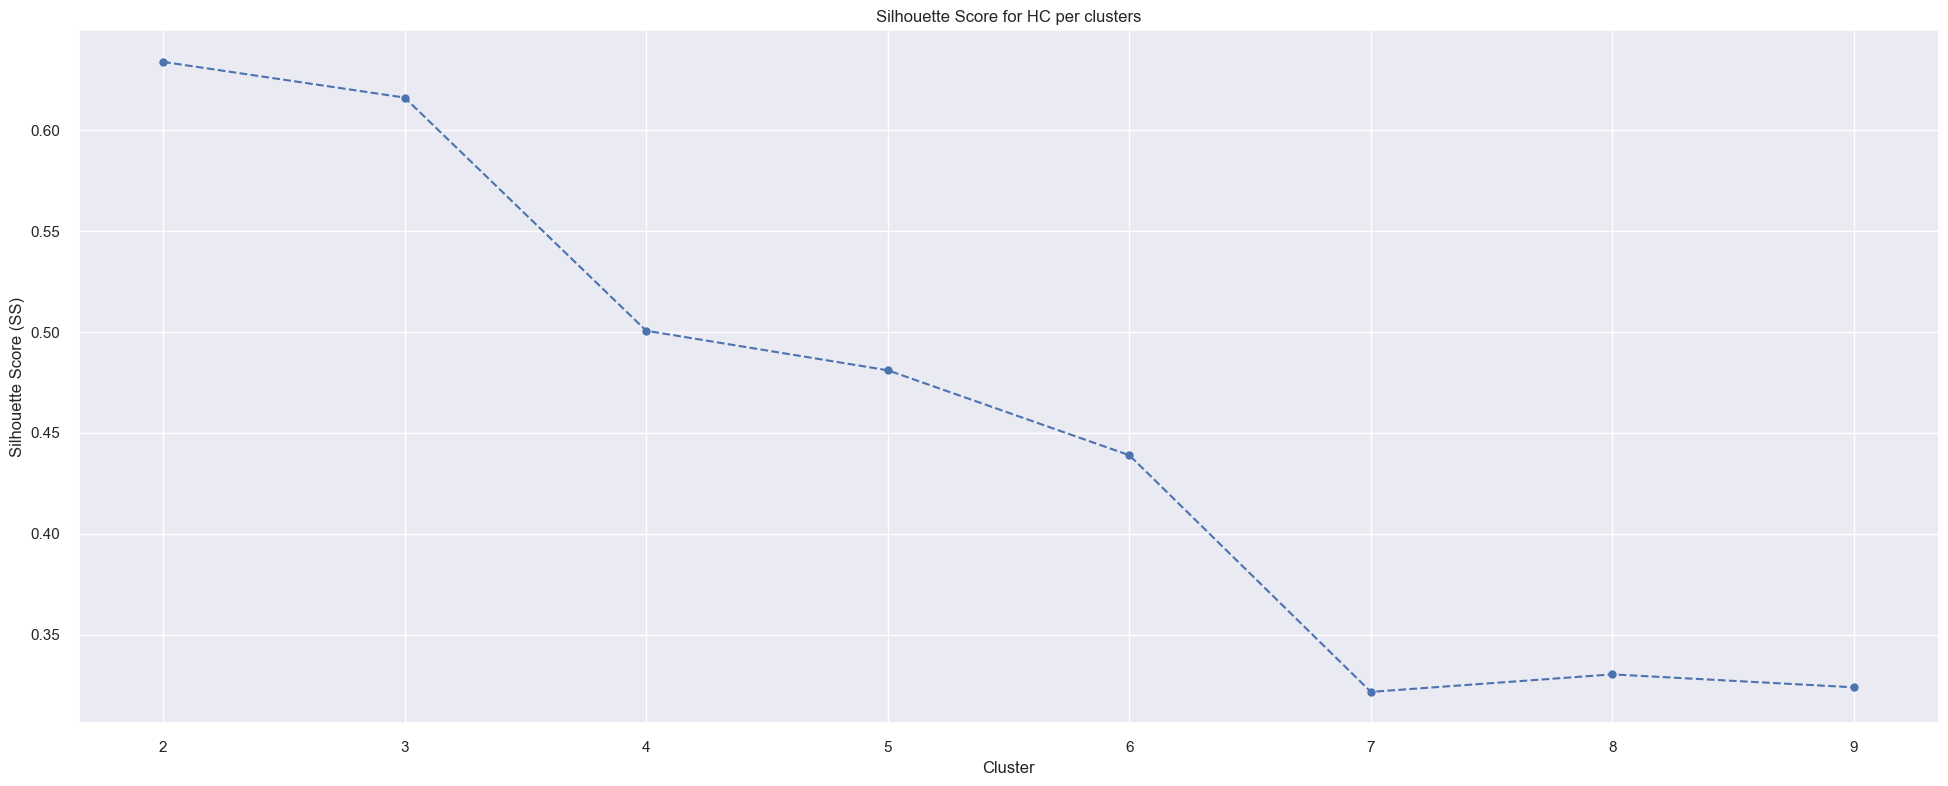

In [156]:
plt.plot(clusters, ss_hc, linestyle = '--', marker = 'o', color = 'b')

plt.xlabel("Cluster")
plt.ylabel("Silhouette Score (SS)")
plt.title("Silhouette Score for HC per clusters");

## 7.4. DBSCAN

In [173]:
eps = 0.1 # raio de densidade 
min_samples = 5

# model definition 
dbscan_model = ct.DBSCAN( eps = eps, min_samples = min_samples )

# model fit and predict 
labels = dbscan_model.fit_predict( X )

# k cluster find
clu = len( np.unique ( labels) ) - 1 

# model performance 
ss_db = mt.silhouette_score( X, labels, metric = 'euclidean' )
print(f"SS: {ss_db} - {clu} Clusters")
print("Cluster únicos:")
print( np.unique ( labels) )

SS: 0.5795053554788728 - 2 Clusters
Cluster únicos:
[-1  0  1]


- 0,15 ele encontra 2 clusters e algumas amostras como ruído ou outlier;
- 0,10 ele encontra 3 clusters e algumas amostras como ruído ou outlier.

In [174]:
ss_db = [0.5795, 0.5194, 0.3197, 0.0, 0.0, 0.0, 0.0, 0.0]

**Método para encontrar valor raio DBSCAN:**

In [175]:
# calcular a distância de cada amostra aos seus vizinhos (n_neighbors) mais próximos
neighbors = NearestNeighbors( n_neighbors = min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

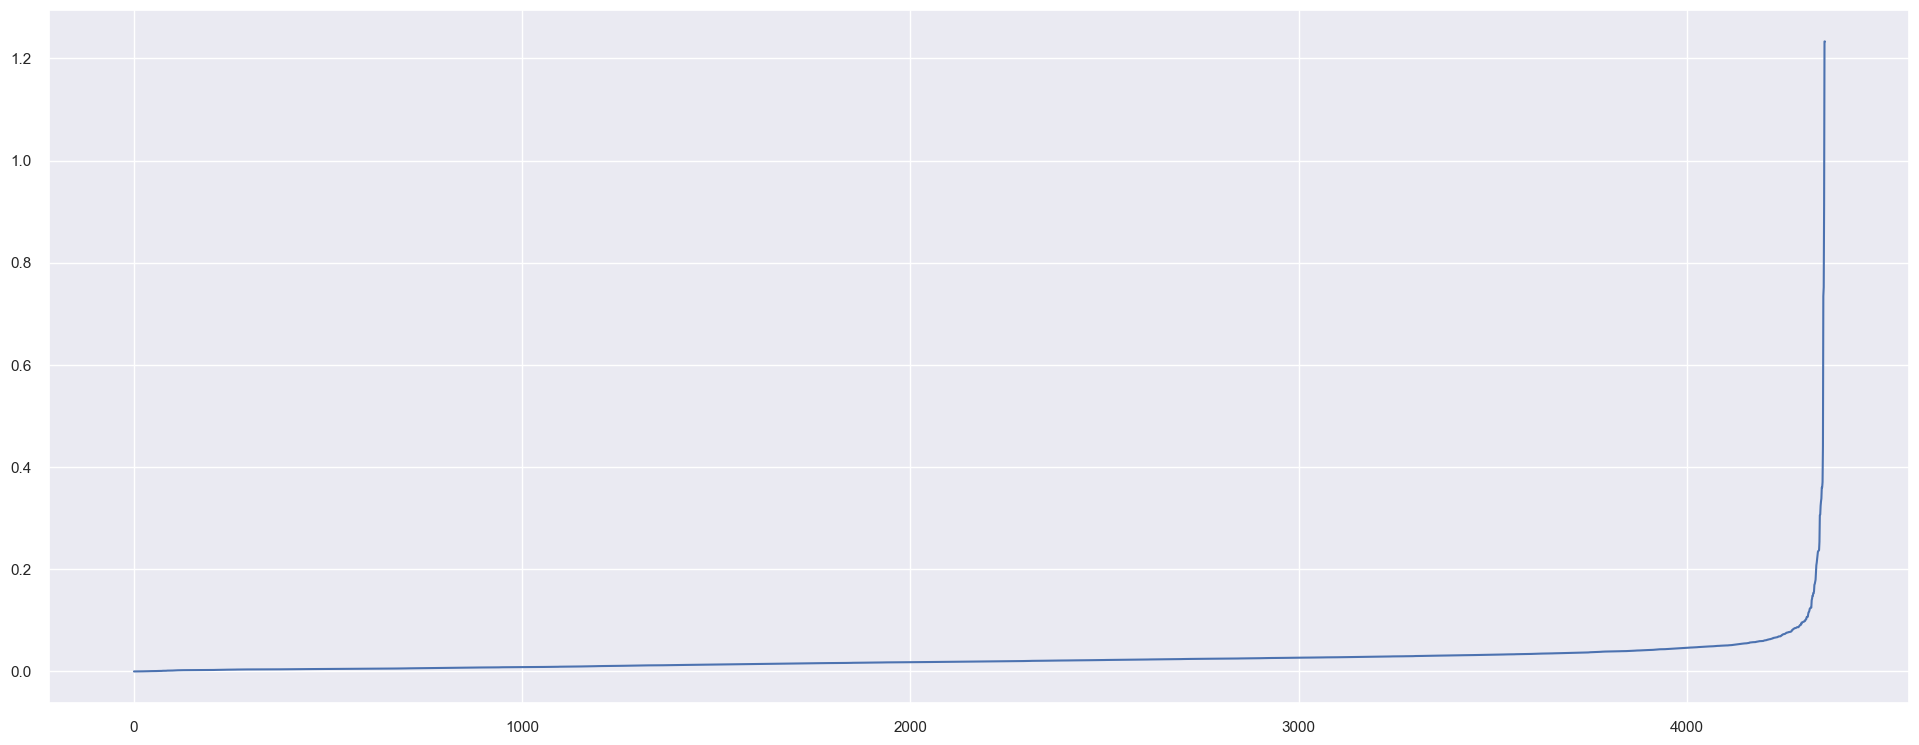

In [176]:
# gráfico das distâncias de cada amostra com relação a seu vizinho mais próximo ordenadas

# ordenando distances
distances = np.sort( distances, axis = 0 )
# pegando distância ao vizinho mais próximo de cada amostra
distances_one = distances[:,1]
# plot - completo 
plt.plot( distances_one );

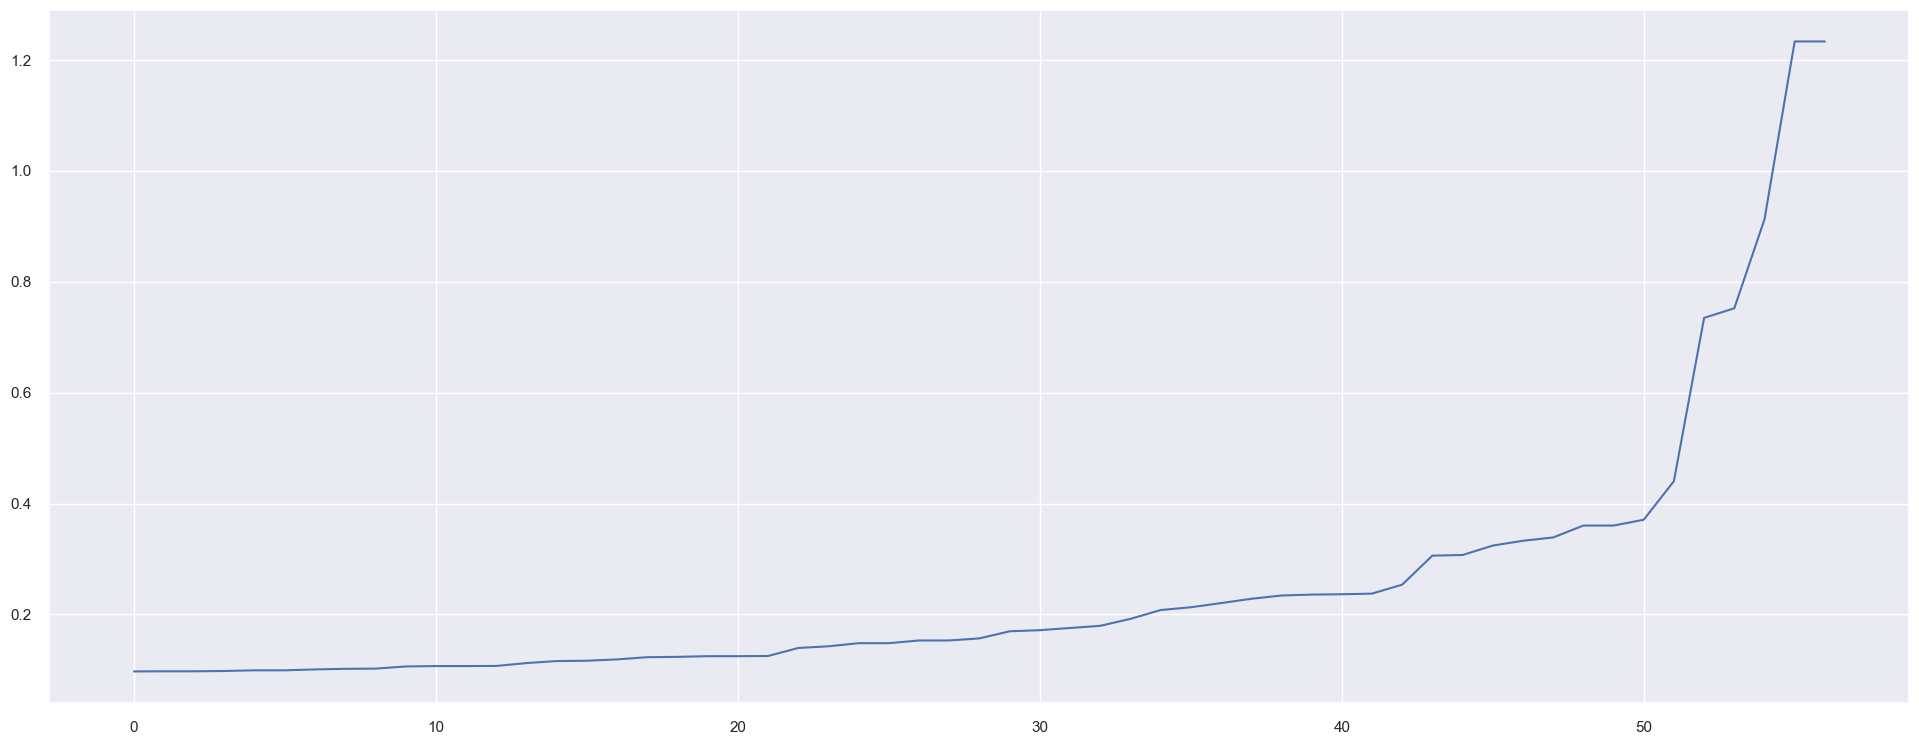

In [177]:
# plot - zoom acima da amostra 4300
plt.plot( distances_one[4300:] );

Valor para usar como raio segundo a literatura é próximo da curva do cotovelo, nesse caso seria 0,15.

## 7.5. Results

In [178]:
df_results = pd.DataFrame({'K-means': ss_kmeans ,
                           'GMM' :    ss_gmm,
                           'HC':      ss_hc, 
                           'DBSCAN':  ss_db}).T

df_results.columns = clusters

In [179]:
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

- Como adotou-se a métrica Silhouette Score para avaliação e ela é melhor para 2 clusters, entende-se que a melhor segmentação (+ coeso e separado) se dá com 2 clusters por enquanto. 

#   8.0 Model Training 

## 8.1. <s> K-means </s>

In [49]:
# model definition 
k = 2
rs = 42

kmeans = ct.KMeans( n_clusters= k, 
                    init='random', 
                    n_init=10, 
                    max_iter=300,
                    random_state=rs )

# model fit 
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [50]:
# WSS (Within-Cluster Sum of Square)
print("WSS: {}".format(kmeans.inertia_))

## SS (Silhouette Score)
print("SS: {}".format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS: 6595.7111220045
SS: 0.5483545593942902


## 8.2. Hierarchical Clustering

In [180]:
# model definition 
k = 2


## model definition and training 
hc_model = hc.linkage( X, 'ward' )
    
## model predict
labels = hc.fcluster( hc_model , k , criterion = 'maxclust' )


In [181]:
## SS (Silhouette Score)
print("SS: {}".format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

SS: 0.6340034055335189


#  9.0 Cluster Analysis 


In [182]:
# Pegar o conjunto de dados antes e depois de fazer a normalização, padronização
df9_before = df4.copy()
df9_after = df7.copy()
df9_before['cluster'] = labels
df9_after['cluster'] = labels
df9_before.head()

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real  cluster
0        17850      5391.210       372.000              1733.000                21.000     34.000            1.000           0.091                   50.971                    0.618          158.565    1.000               40.000      102.580      5288.630        1
1        13047      3232.590        56.000              1390.000               105.000      9.000           52.833           0.024                  154.444                   11.667          359.177    7.000               35.000      143.490      3089.100        1
2        12583      6705.380         2.000              5028.000               114.000     15.000           26.500           0.040                  335.200                    7.600          447.025    2.000               50.000       76.040      6629.340        1
3        13748       948.250        95.000               439.000                24.000      5.000           92.667           0.013                   87.800                    4.800          189.650    0.000                0.000        0.000       948.250        1
4        15100       876.000       333.000                80.000                 1.000      3.000           20.000           0.008                   26.667                    0.333          292.000    3.000               22.000      240.900       635.100        1

In [183]:
df9_after.head()

customer_id  revenue_purc  recency_days  volume_products_purc  assort_products_purc  purchases  avg_period_purc  frequency_purc  volume_basket_size_purc  assort_basket_size_purc  avg_ticket_purc  returns  volume_products_ret  revenue_ret  revenue_real  cluster
0        17850         0.019         0.930                 0.009                 0.012      0.165            0.000           0.091                    0.001                    0.002            0.002    0.022                0.000        0.001         0.023        1
1        13047         0.012         0.140                 0.007                 0.059      0.044            0.130           0.024                    0.002                    0.045            0.004    0.156                0.000        0.001         0.015        1
2        12583         0.024         0.005                 0.026                 0.064      0.073            0.064           0.040                    0.005                    0.029            0.005    0.044                0.001        0.000         0.028        1
3        13748         0.003         0.238                 0.002                 0.013      0.024            0.230           0.013                    0.001                    0.019            0.002    0.000                0.000        0.000         0.008        1
4        15100         0.003         0.833                 0.000                 0.001      0.015            0.048           0.008                    0.000                    0.001            0.003    0.067                0.000        0.001         0.007        1

## 9.1. Visualization Inspection

Visualização dos cluster até 3 dimensões, se maior que 3, usar outras técnicas 

In [48]:
# fig = px.scatter_3d(df9, x = 'recency_days', y = 'frequency_total', z = 'gross_revenue_total', color = 'cluster')
# fig.show()

AttributeError: module 'plotly.validators.layout.template' has no attribute 'LayoutValidator'

In [56]:
## NÃO POSSO USAR MAIS A VISUALIZAÇÃO DOS DADOS POIS ALGORITMO ESTÁ CONSTRUÍDO COM 4 DIMENSÕES

# fig = go.Figure(data=[go.Scatter3d(x=df9['recency_days'], y=df9['frequency_total'], z=df9['gross_revenue_total'],
#                                    mode='markers', marker=dict(size=12,color=df9['cluster'],colorscale='Viridis', opacity=0.8))])
# fig.show()

## 9.2. Silhouette Analysis

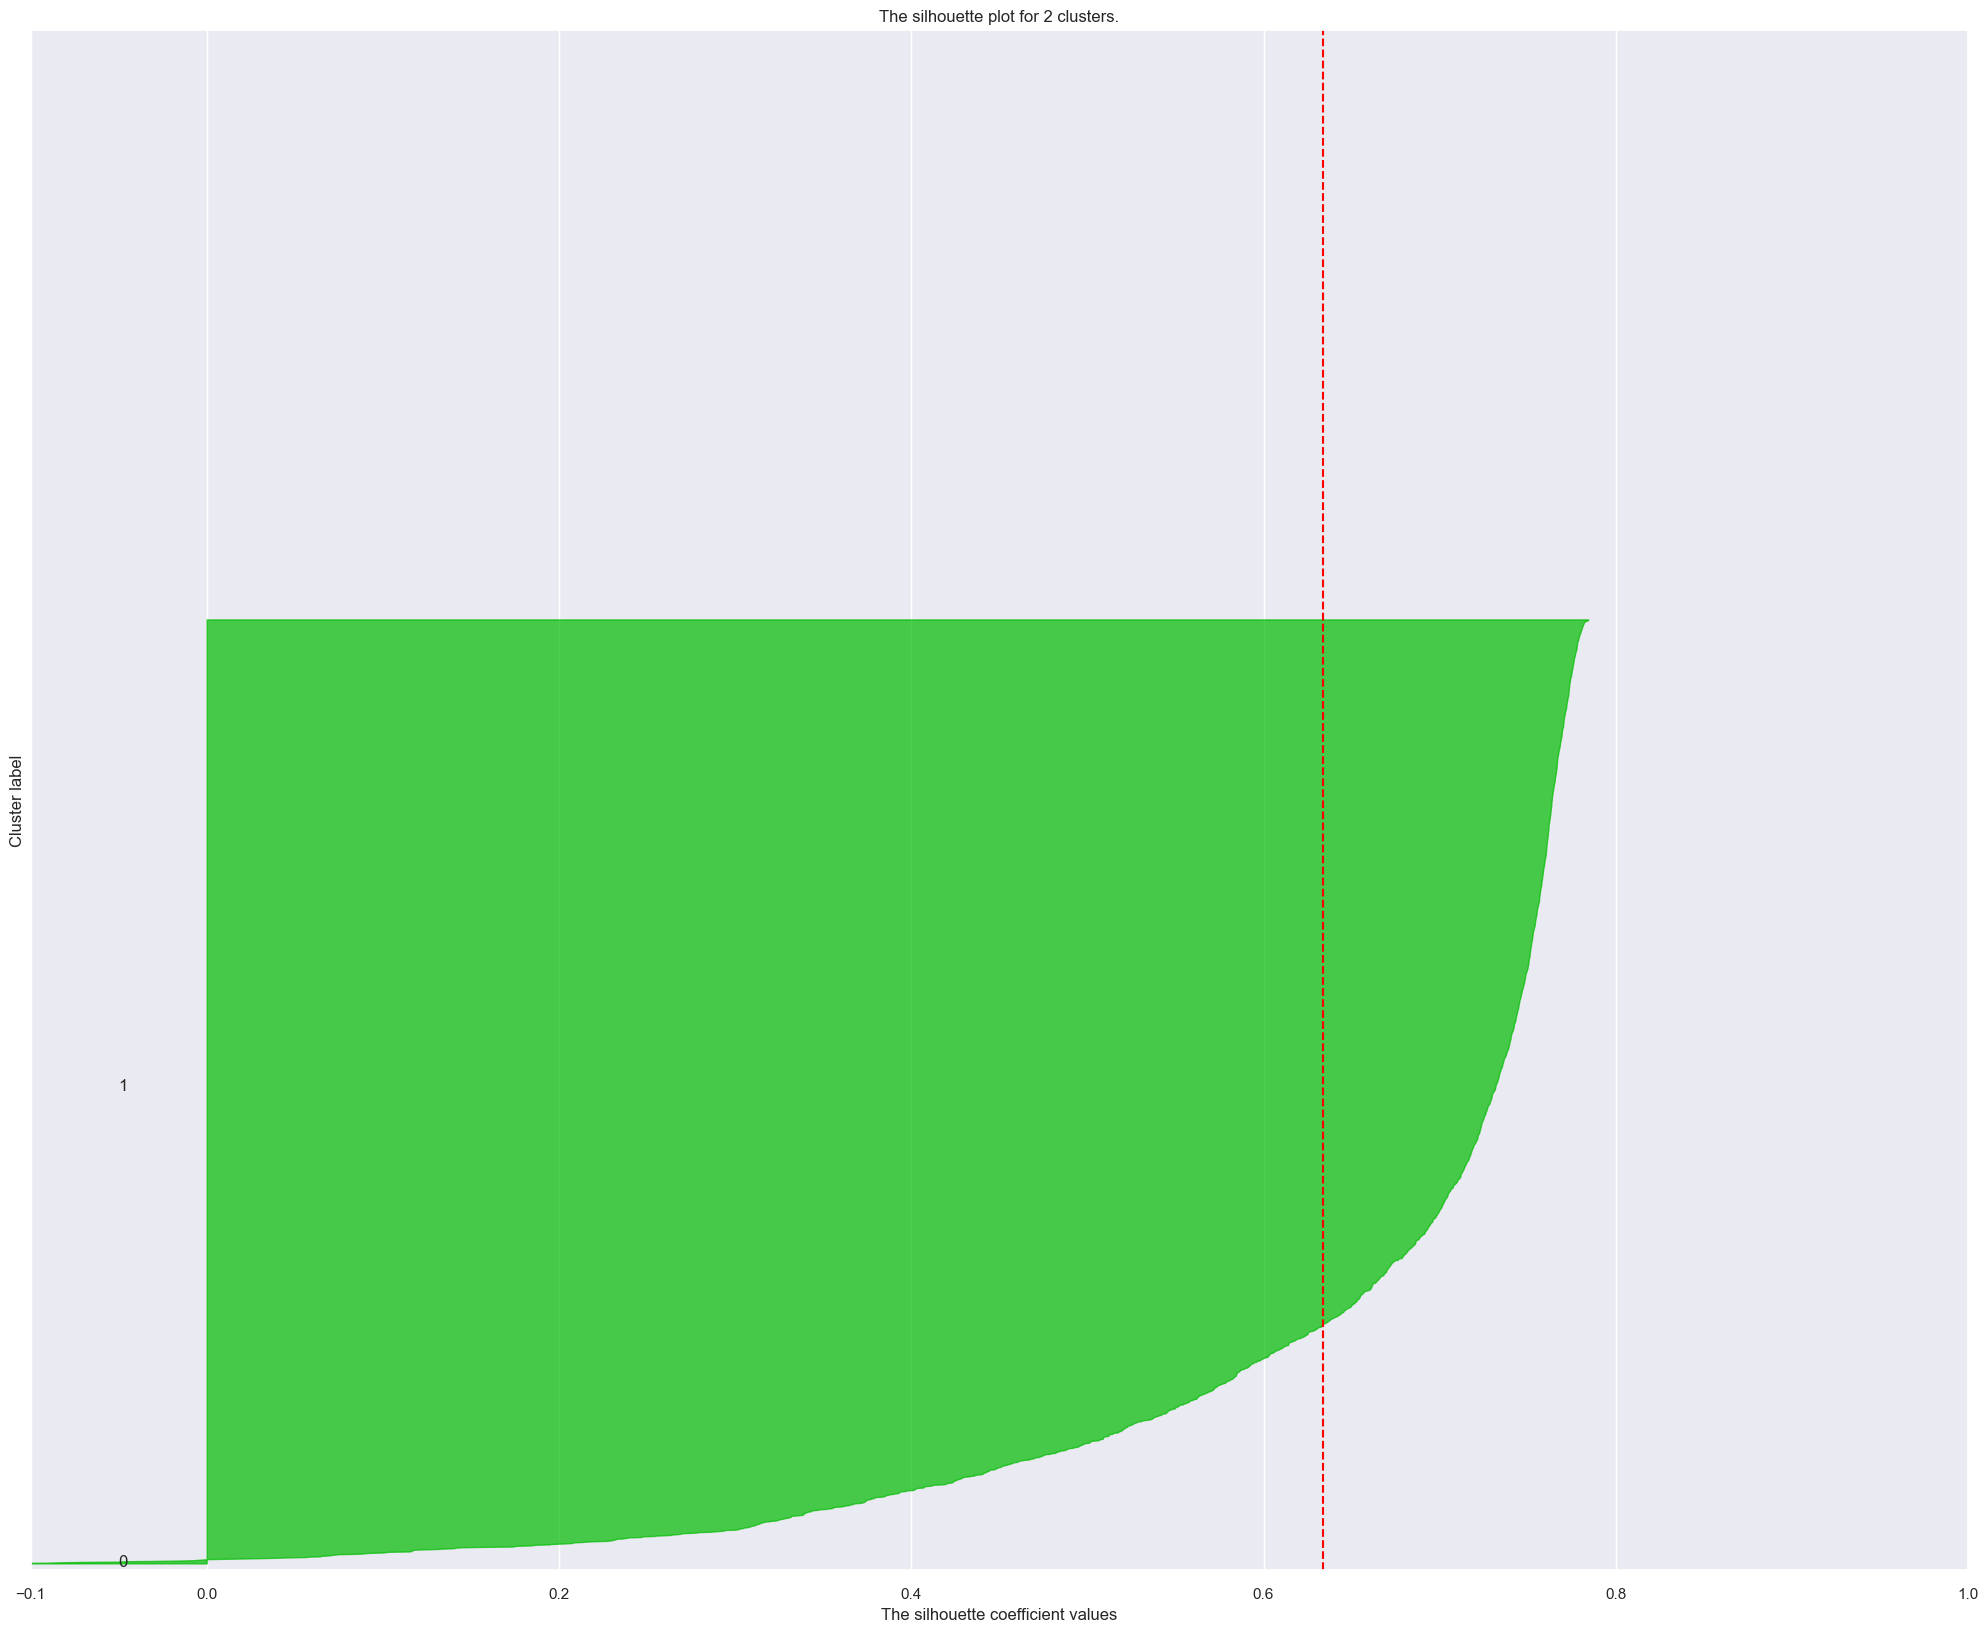

In [188]:
## Silhouette Score (SS) and Analysis

# Create a subplot 
fig, ax1 = plt.subplots()
fig.set_size_inches(25, 20)


n_clusters = 2
    
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

## model definition and training 
hc_model = hc.linkage( X, 'ward' )

## model predict
labels = hc.fcluster( hc_model , n_clusters , criterion = 'maxclust' )

# performance
silhouette_avg = mt.silhouette_score(X, labels, metric = 'euclidean')

# Compute the silhouette scores for each sample
sample_silhouette_values = mt.silhouette_samples(X, labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,
                                facecolor=color,
                                edgecolor=color,
                                alpha=0.7,
                                )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title(f"The silhouette plot for {n_clusters} clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

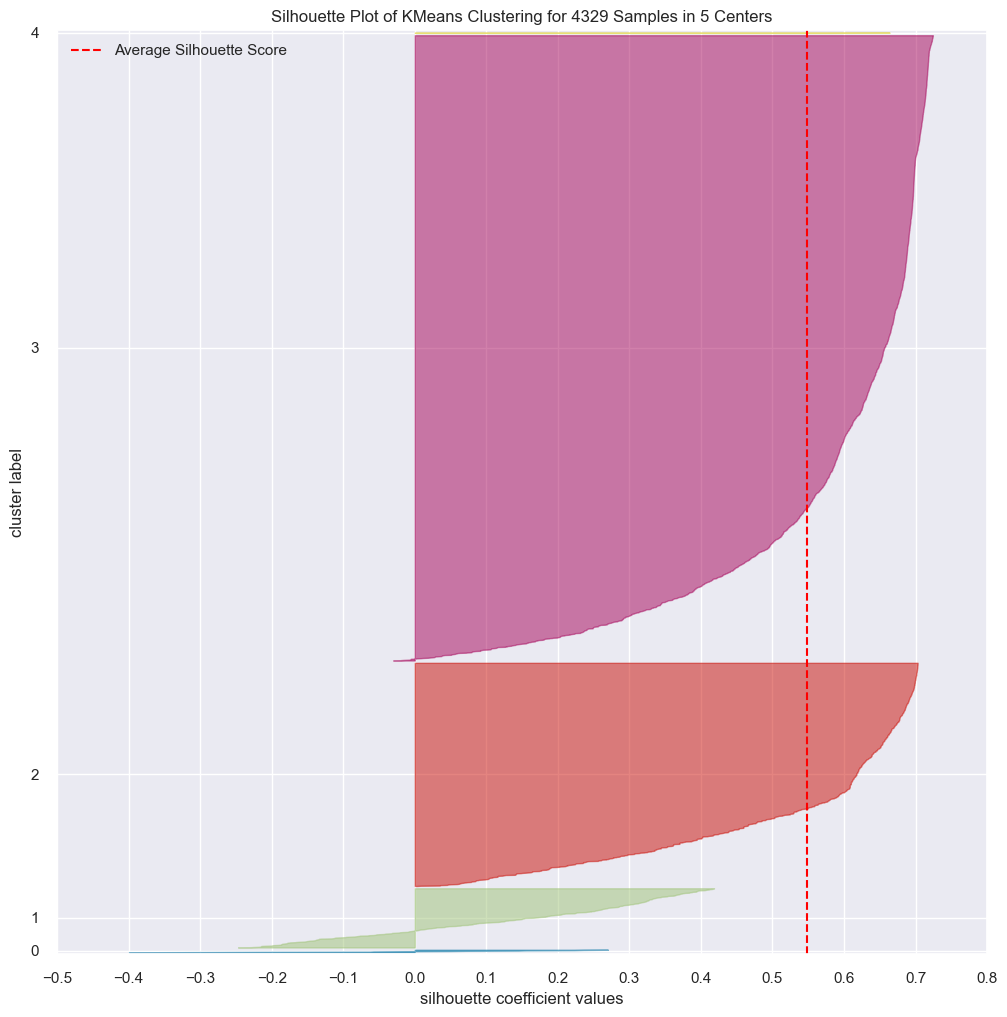

In [53]:
#fig, ax1 = plt.subplots(figsize = (12,12))

#kmeans = ct.KMeans( n_clusters= k,init='random', n_init=10, max_iter=300,random_state=rs )

#visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax1)
#visualizer.fit( X ) 
#visualizer.finalize()

- Clusters 0 possuem clientes (amostras) com coeficiente de silhueta menor que 0, o que significa que essas amostras não percentem ao cluster que lhe foi atribuído. Melhorar clusterização.

## 9.3. Pair plot 2d Features

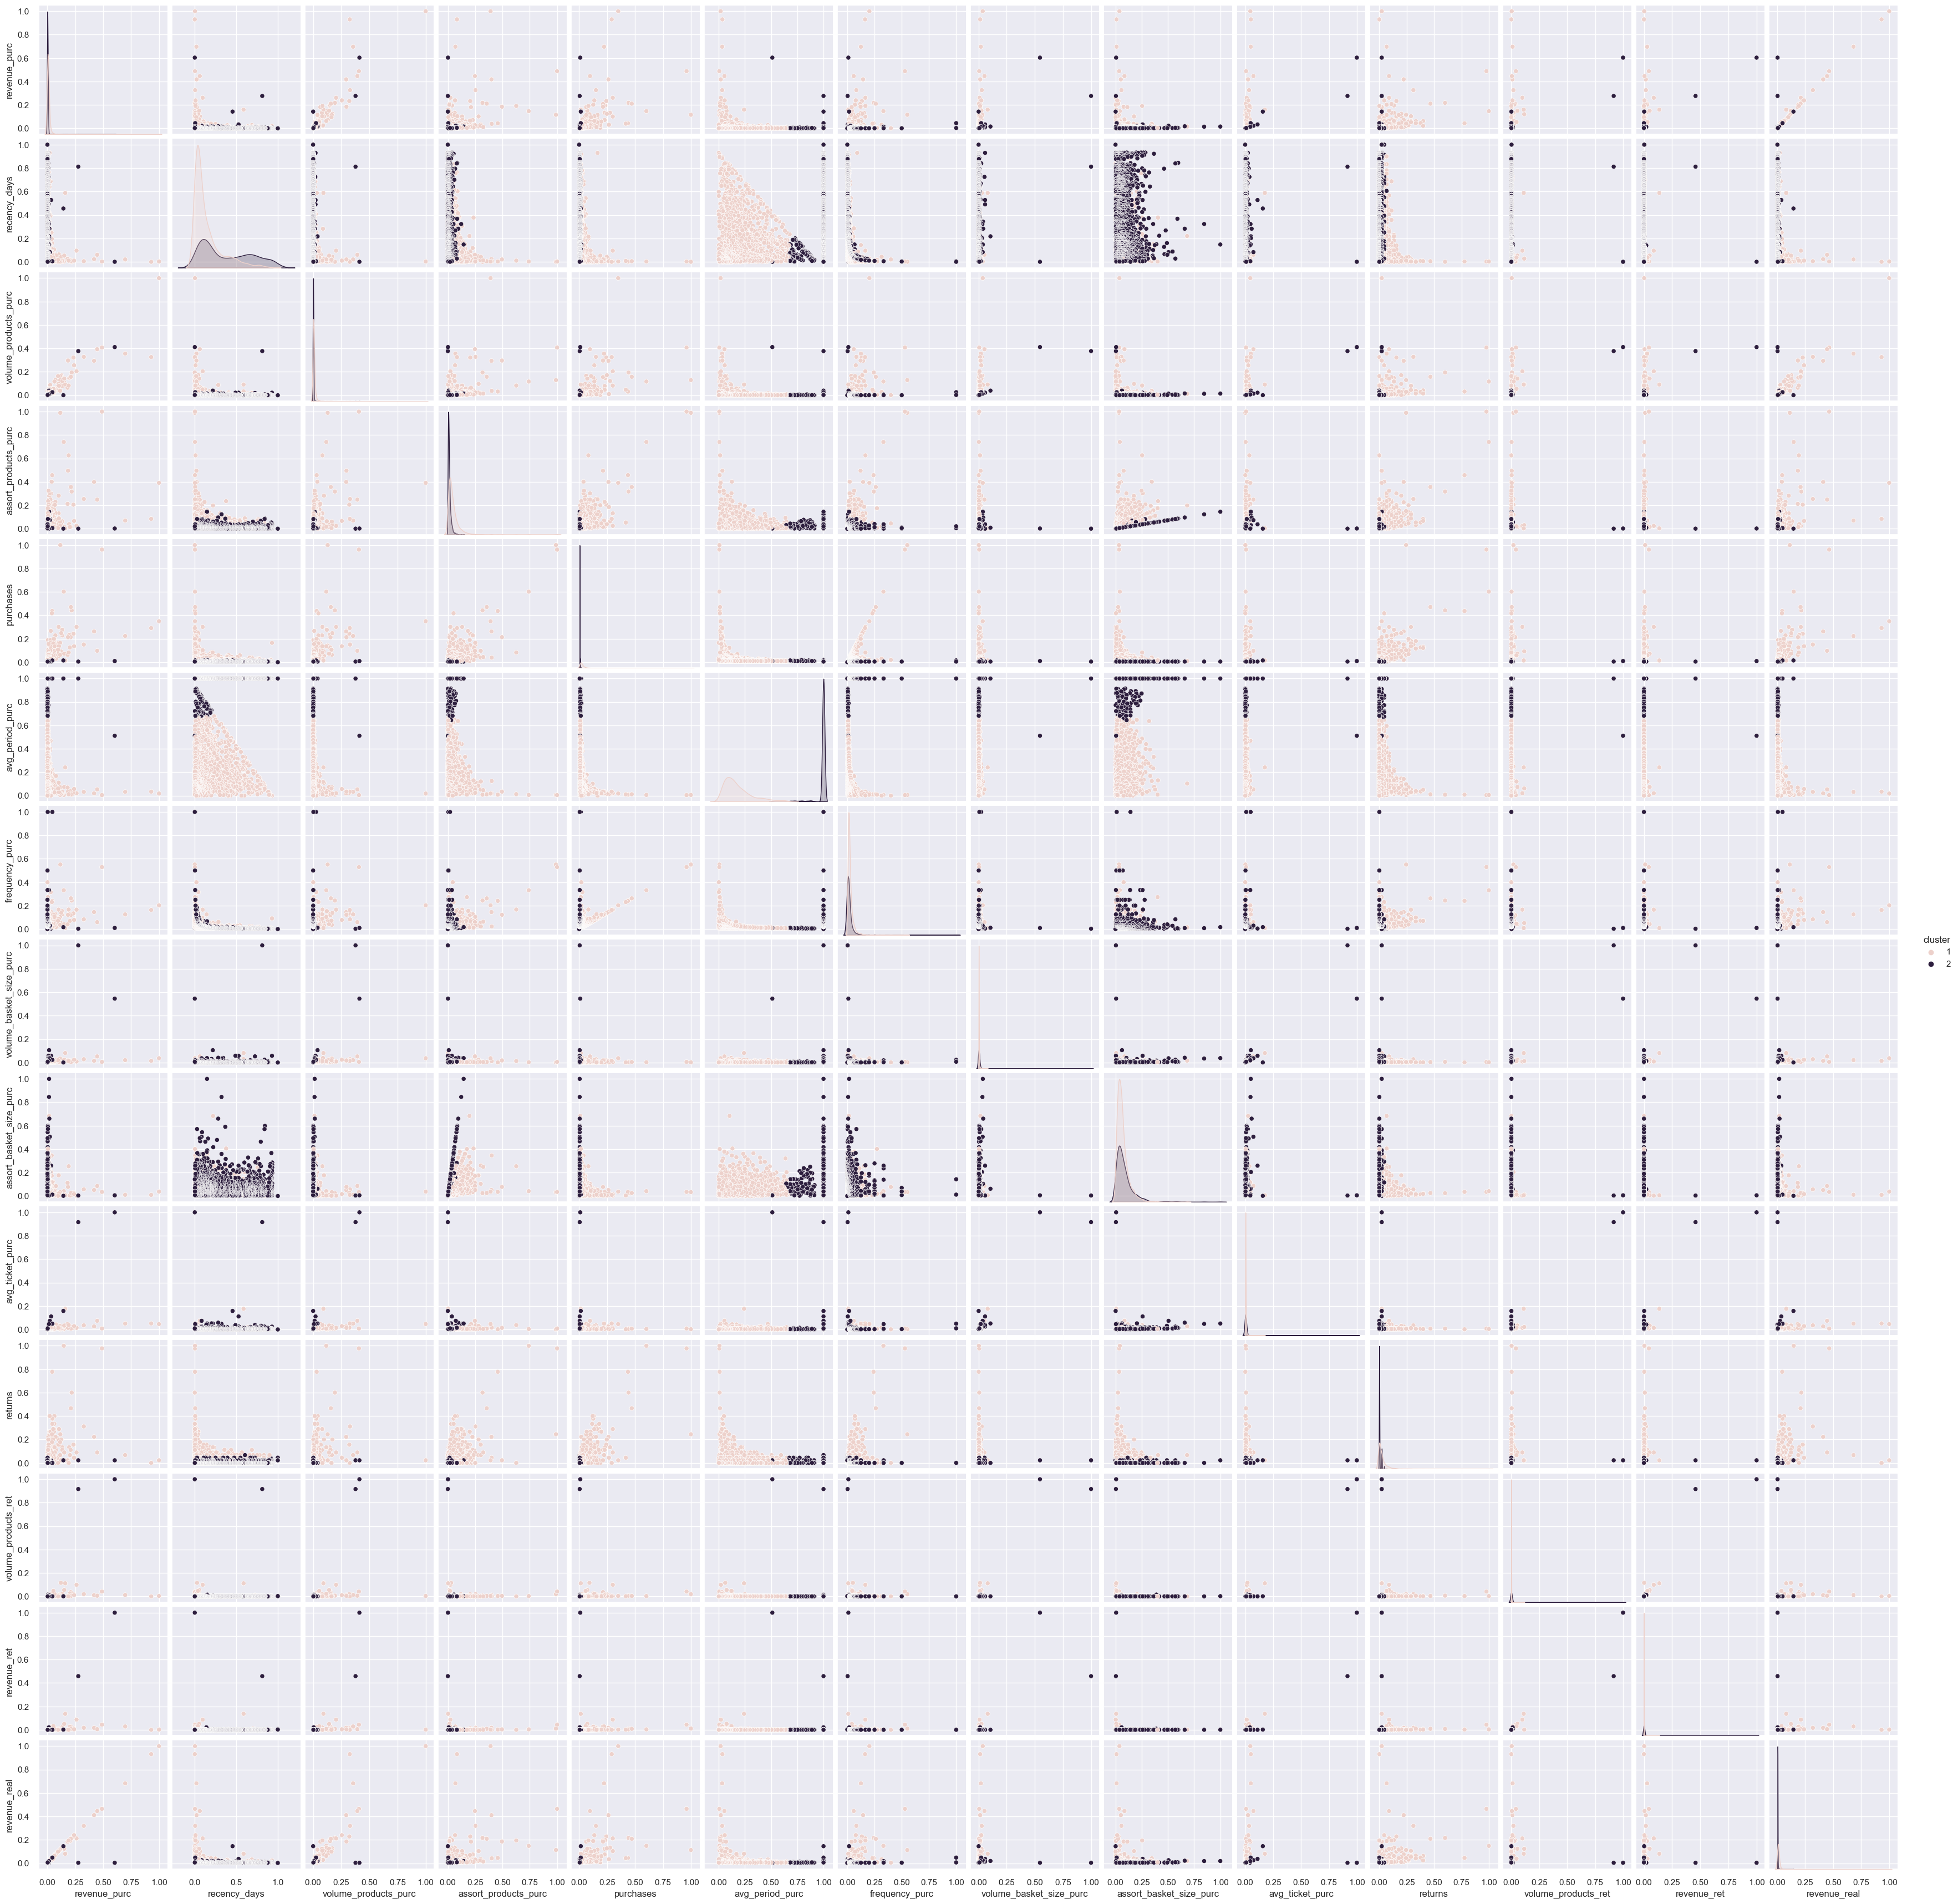

In [184]:
df_viz = df9_after.drop(columns = 'customer_id')

sns.pairplot(df_viz, hue = 'cluster');

Objetivo é avaliar as features que podem estar mais bagunçando do que auxiliando a criar grupos. O risco que se corre ao excluir features olhando apenas para essa visualização de cluster dois a dois é eliminar alguma feature pela aparente bagunça que causa misturada com apenas outra e ela ser uma feature relevante que em alta dimensionalidade cria clusters coesos e separados.

## 9.4. Redução de dimensionalidade com UMAP

In [185]:
## REDUÇÃO DE DIMENSIONALIDADE: | Feature Engineering | Transformação de variáveis

## Machine Learning - Manifold - Aprendizado por topologia
    ## Métodos UMAP - t-SNE 
## Machine Learning - Matrix - Espaço de distância - Espaço de Hilbert - 9 condições - Colorários
    ## Método PCA 

# reducer = projeção de alta dimensionalidade
reducer = umap.UMAP(random_state = 42)

# embedding = espaço projetado em 2D 
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

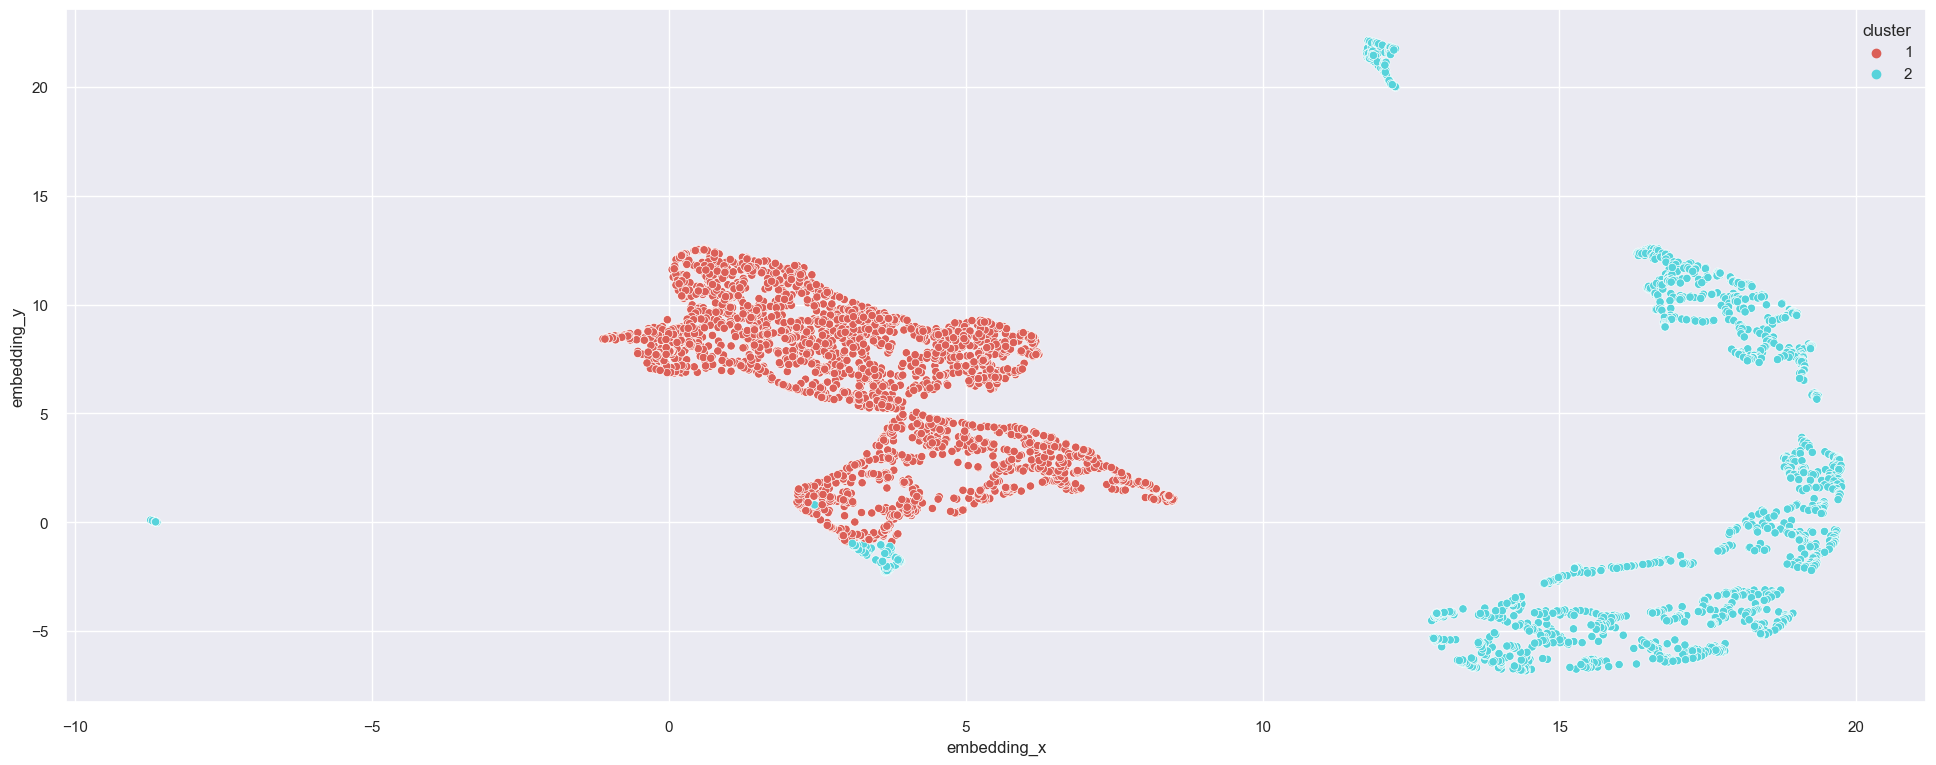

In [186]:
# plot embedding - clusters projetados de alta dimensionalidade

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = sns.color_palette('hls', n_colors = df_viz['cluster'].nunique()),
                data = df_viz );

**Interpretação:** não significa que em alta dimensionalidade os cluster estão nessa distância um do outro, como é uma projeção, possui o intuito  de verificar se no espaço projetado existem cluster misturados, assim sendo, existe uma alta probabilidade de estarem também no espaço de alta dimensionalidade.

## 9.5. Cluster Profile

<font color = 'red'> **Relatório:** </font> Não documentado pois resultado da Silhouette Score da clusterização não ficou satisfatório

In [57]:
## Number of customer 

df_cluster = df9_before[['customer_id','cluster']].groupby(by = 'cluster').count().reset_index().rename(columns = {'customer_id':'n_customer'})
df_cluster['perc_customer'] = 100 * (df_cluster['n_customer'] / df_cluster['n_customer'].sum())


## Avg gross_revenue
df_reve = df9_before[['gross_revenue','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'gross_revenue':'mean_revenue'})

## Avg recency_days 
df_rece = df9_before[['recency_days','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'recency_days':'mean_recency_days'})

## Avg purchases
df_freq = df9_before[['purchases','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'purchases':'mean_purchases'})

## avg_ticket 
df_ticket = df9_before[['avg_ticket','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'avg_ticket':'mean_ticket'})

## Avg returns
df_return = df9_before[['returns','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'returns':'mean_returns'})

## join tables
df_c_profile = df_cluster.merge(df_reve, on = 'cluster', how = 'left').merge(df_rece, on = 'cluster', how = 'left').merge(df_freq, on = 'cluster', how = 'left').merge(df_ticket, on = 'cluster', how = 'left').merge(df_return, on = 'cluster', how = 'left')

df_c_profile


cluster  n_customer  perc_customer  mean_revenue  mean_recency_days  mean_purchases  mean_ticket  mean_returns
0        0          13          0.300    113826.606              6.692          88.538      159.240        16.846
1        1         282          6.514      9215.010             16.578          17.507       44.667         4.933
2        2        1061         24.509       555.168            248.767           1.558       55.956         0.272
3        3        2971         68.630      1293.899             43.762           3.584       29.307         0.488
4        4           2          0.046    122828.050            162.500           1.500    66670.550         1.000



### CLUSTER 0: (Candidato à Insiders)

        - Quantidade de clientes: 6 (0,14%)
        - Média de faturamento total gerado: US 182.181,9 
        - Média da recência: 7,167 dias
        - Média de transações no período total: 89 
        - Média do ticket médio: US 253,6

### CLUSTER 1:

        - Quantidade de clientes: 31 (0,71%)
        - Média de faturamento total gerado: US 40.543,5 
        - Média da recência: 13,3 dias
        - Média de transações no período total: 53,29
        - Média do ticket médio: US 201,9

### CLUSTER 2:

        - Quantidade de clientes: 4.335 (99,15%)
        - Média de faturamento total gerado: US 1.372,6 
        - Média da recência: 92,25 dias
        - Média de transações no período total: 4,6
        - Média do ticket médio: US 27,3

**Análise:**

- Quantidade de amostras em cada cluster muito desequilibrada

# <font color = 'red'>  10.0 Deploy to production </font>